In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install venn
from venn import venn
%matplotlib inline
import tqdm
from utils import parse_date, parse_year

In [2]:
# 定义一个转换为科学计数法的函数
def to_scientific(x):
    """只允许比较符为>或<,不允许=、≥和≤"""
    x = str(x)
    value_str = x.split('<')[-1].split('>')[-1].strip()
    comparison_str =  x.replace(value_str,'')
    formatted_x = f"{comparison_str}{float(value_str):.4e}"
    return formatted_x

# read & merge

In [3]:
filepaths = {
    'SKEMPI v2.0': './processed_data/SKEMPI v2.0.xlsx',
    'SAbDab': './processed_data/SAbDab.xlsx',
    'Affinity Benchmark v5.5': './processed_data/Affinity Benchmark v5.5.xlsx',#'Structural Affinity Benchmark Version 2'
    'PDBbind v2020': './processed_data/PDBbind v2020.xlsx',
    'ATLAS': './processed_data/ATLAS.xlsx',
}
save_dir = "figures_of_PPB-Affinity"
dpi = 350
suffix = "tiff"

df_dict=dict()
for name, filepath in filepaths.items():
    df_subset = pd.read_excel(filepath,dtype={'Affinity PubMed ID':str, 'PDB PubMed ID':str})
    # 'Resolution(Å)'取值NMR的，改为np.nan
    df_subset['Resolution(Å)'].replace('NMR',np.nan, inplace=True)
    # Mutations
    df_subset['PDB'] = df_subset['PDB'].apply(lambda x: x.upper())
    # chains sorted and normalized
    df_subset['Ligand Chains'] = df_subset['Ligand Chains'].apply(lambda x: ', '.join(sorted(list(set([chain.strip() for chain in x.split(',')])))) if isinstance(x,str) else x)
    df_subset['Receptor Chains'] = df_subset['Receptor Chains'].apply(lambda x: ', '.join(sorted(list(set([chain.strip() for chain in x.split(',')])))) if isinstance(x,str) else x)
    # muataion standardization
    if name=='SKEMPI v2.0':
        df_subset['Mutation(s)_PDB'] = df_subset['Mutation(s)_PDB'].apply(lambda x: ', '.join(sorted([mut.strip() for mut in x.split(',')])) if isinstance(x,str) else x)
        df_subset['Mutation(s)_cleaned'] = df_subset['Mutation(s)_cleaned'].apply(lambda x: ', '.join(sorted([mut.strip() for mut in x.split(',')])) if isinstance(x,str) else x)
    else:
        if 'Mutations' not in df_subset.columns:
            df_subset.insert(loc=0, column='Mutations',value=np.nan)
        df_subset['Mutations'] = df_subset['Mutations'].apply(lambda x: ', '.join(sorted([mut.strip() for mut in x.split(',')])) if isinstance(x,str) else x)
    df_dict[name] = df_subset

    
# 'Complex ID'
for name in df_dict.keys():
    for ind in tqdm.tqdm(df_dict[name].index, desc=name):
        pdb = df_dict[name].loc[ind, 'PDB']
        df_dict[name]['Ligand Chains'] = df_dict[name]['Ligand Chains'].fillna('')
        df_dict[name]['Receptor Chains'] = df_dict[name]['Receptor Chains'].fillna('')
        ligand = [item.strip() for item in df_dict[name].loc[ind, 'Ligand Chains'].split(',')]
        receptor = [item.strip() for item in df_dict[name].loc[ind, 'Receptor Chains'].split(',')]
        chains = ', '.join(sorted( set(ligand).union(set(receptor))))
        affinity_PMID = df_dict[name]['Affinity PubMed ID'].loc[ind]
        affinity = to_scientific( df_dict[name]['KD(M)'].loc[ind] )
        if name=='SKEMPI v2.0':
            muts_PDB = df_dict[name]['Mutation(s)_PDB'].fillna('').loc[ind]
            muts_cleaned = df_dict[name]['Mutation(s)_cleaned'].fillna('').loc[ind]
        else:
            muts = df_dict[name]['Mutations'].fillna('').loc[ind]
#         df_dict[name].loc[ind,'Complex ID'] = f"{pdb}:{chains}:{muts}:KD(M)_{affinity}:PMID={affinity_PMID}"
#         df_dict[name].loc[ind,'Complex ID'] = f"{pdb}:{chains}:{muts}:KD(M)_{affinity}"
        if name=='SKEMPI v2.0':
            df_dict[name].loc[ind,'Complex ID'] = f"{pdb}:{chains}:{muts_PDB}:PMID={affinity_PMID}"  
            df_dict[name].loc[ind,'Complex ID PDB'] = f"{pdb}:{chains}:{muts_PDB}:PMID={affinity_PMID}" 
            df_dict[name].loc[ind,'Complex ID cleaned'] = f"{pdb}:{chains}:{muts_cleaned}:PMID={affinity_PMID}" 
        else:
            df_dict[name].loc[ind,'Complex ID'] = f"{pdb}:{chains}:{muts}:PMID={affinity_PMID}"   

# temporarily    
df_dict['SKEMPI v2.0']['Mutations'] = df_dict['SKEMPI v2.0']['Mutation(s)_PDB']

# merge
dfs = [df for df in df_dict.values()]
df_merge = pd.concat(dfs,ignore_index=True)
df_merge.drop(columns=['Unnamed: 0'], inplace=True)
df_merge.drop_duplicates(subset=['Complex ID'], keep='first', inplace=True)
df_merge['KD(M)'] = df_merge['KD(M)'].apply(lambda x: float(str(x).split('<')[-1].split('>')[-1].strip()))
df_merge['KD(M)'].astype(float)
df_merge['dG(kcal/mol)'] = (8.314/4184)*(273.15 + 25.0) * np.log(df_merge['KD(M)'])
# df_merge['Affinity Release Date'] = df_merge['Affinity Release Date'].astype(str).apply(parse_date)

df_merge.drop_duplicates(subset=['Complex ID'], keep='first', inplace=True)
# display(df_merge)
print(f">>> After merge teh source data sets, we get {len(df_merge)} records in df_merge.")


# # 统计'PDB','Ligand Chains','Receptor Chains','Mutations'均相同，但是PMID、亲和力不同的样本
# df_gps = df_merge.groupby(by=['PDB','Ligand Chains','Receptor Chains','Mutations'])
# tmp = []
# for name_gp, df_gp in df_gps:
#     if len(df_gp)>1:# and len(set(df_gp['Source Data Set'].values.tolist()))>1:
#         display(df_gp.loc[:,['Complex ID','Complex ID cleaned', 'Source Data Set','PDB','KD(M)','Affinity PubMed ID','Affinity Method','Temperature(K)']])
#         tmp.append(set(df_gp['Source Data Set'].values.tolist()))
        
        
# recover to cleaned
df_merge.loc[df_merge['Source Data Set']=='SKEMPI v2.0','Mutations'] = df_merge.loc[df_merge['Source Data Set']=='SKEMPI v2.0','Mutation(s)_cleaned']
df_merge.loc[df_merge['Source Data Set']=='SKEMPI v2.0','Complex ID'] = df_merge.loc[df_merge['Source Data Set']=='SKEMPI v2.0','Complex ID cleaned']

ATLAS: 100%|██████████| 637/637 [00:00<00:00, 1317.15it/s]


>>> After merge teh source data sets, we get 12062 records in df_merge.


# unique 

### unique PDB

<Figure size 2240x1680 with 0 Axes>

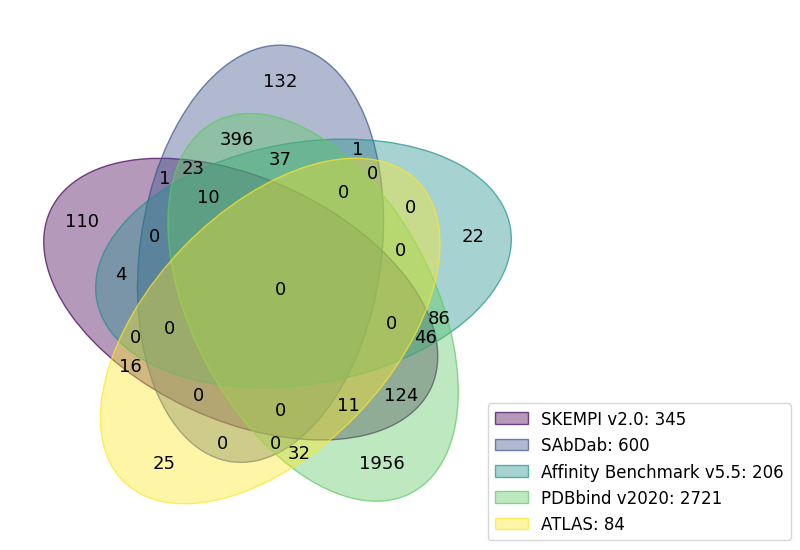

In [4]:
from venn import venn
%matplotlib inline

plt.figure(dpi=dpi)
# unique PDB的韦恩图
dataset_uniquePDB_dict = {name: set(df_dict[name].PDB.apply(lambda x: x.upper())) for name in df_dict.keys()}

venn(dataset_uniquePDB_dict, figsize=(8, 8))#, legend_loc='lower right')

num1 = 0.9# num1=0表示legend位于图像的左侧垂直线# num1=1表示legend位于图像的右侧垂直线
num2 = 0# num2=10表示表示legend位于图像下侧水平线,1表示上侧水平线
num3 = 3
num4 = 0
labels = [ f"{name}: {len(dataset_uniquePDB_dict[name])}" for name in dataset_uniquePDB_dict.keys()]

plt.legend( labels=labels, 
           bbox_to_anchor=(num1, num2), loc=num3, borderaxespad=num4, 
           fontsize=12,
          )
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f'Venn Diagram of Unique PDB Codes for Source Datasets.{suffix}'), dpi=dpi  )
plt.show()

### unique complex

<Figure size 2240x1680 with 0 Axes>

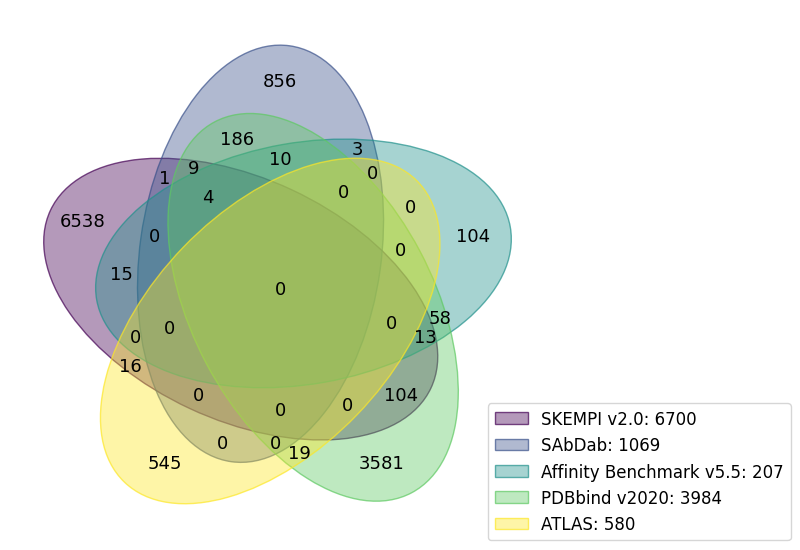

In [5]:
plt.figure(dpi=dpi)

dataset_uniqueSample_dict = {name: set(df_dict[name]['Complex ID'].values.tolist())  for name in df_dict.keys()}

venn(dataset_uniqueSample_dict, figsize=(8, 8))#, legend_loc='lower right')
num1 = 0.9# num1=0表示legend位于图像的左侧垂直线# num1=1表示legend位于图像的右侧垂直线
num2 = 0# num2=10表示表示legend位于图像下侧水平线,1表示上侧水平线
num3 = 3
num4 = 0
labels = [ f"{name}: {len(dataset_uniqueSample_dict[name])}" for name in dataset_uniqueSample_dict.keys()]

plt.legend( labels=labels, 
           bbox_to_anchor=(num1, num2), loc=num3, borderaxespad=num4, 
           fontsize=12,
          )
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f'Venn Diagram of Unique Samples in the Source Datasets.{suffix}'), dpi=dpi  )
plt.show()

In [6]:
# name = 'SKEMPI v2.0'
# for ID in set(df_dict[name]['Complex ID'].values.tolist()):
#     df_tmp = df_dict[name][df_dict[name]['Complex ID']==ID]
#     if len(df_tmp)>1:
#         print(ID)
#         display(df_tmp)

In [7]:
PDB_all = set([])
for subset in dataset_uniquePDB_dict.values():
    PDB_all = PDB_all.union(subset)
print(f"PDB总数：{len(PDB_all)}")

Sample_all = set([])
for subset in dataset_uniqueSample_dict.values():
    Sample_all = Sample_all.union(subset)
print(f"样本总数：{len(Sample_all)}")

PDB总数：3032
样本总数：12062


# Affinity value

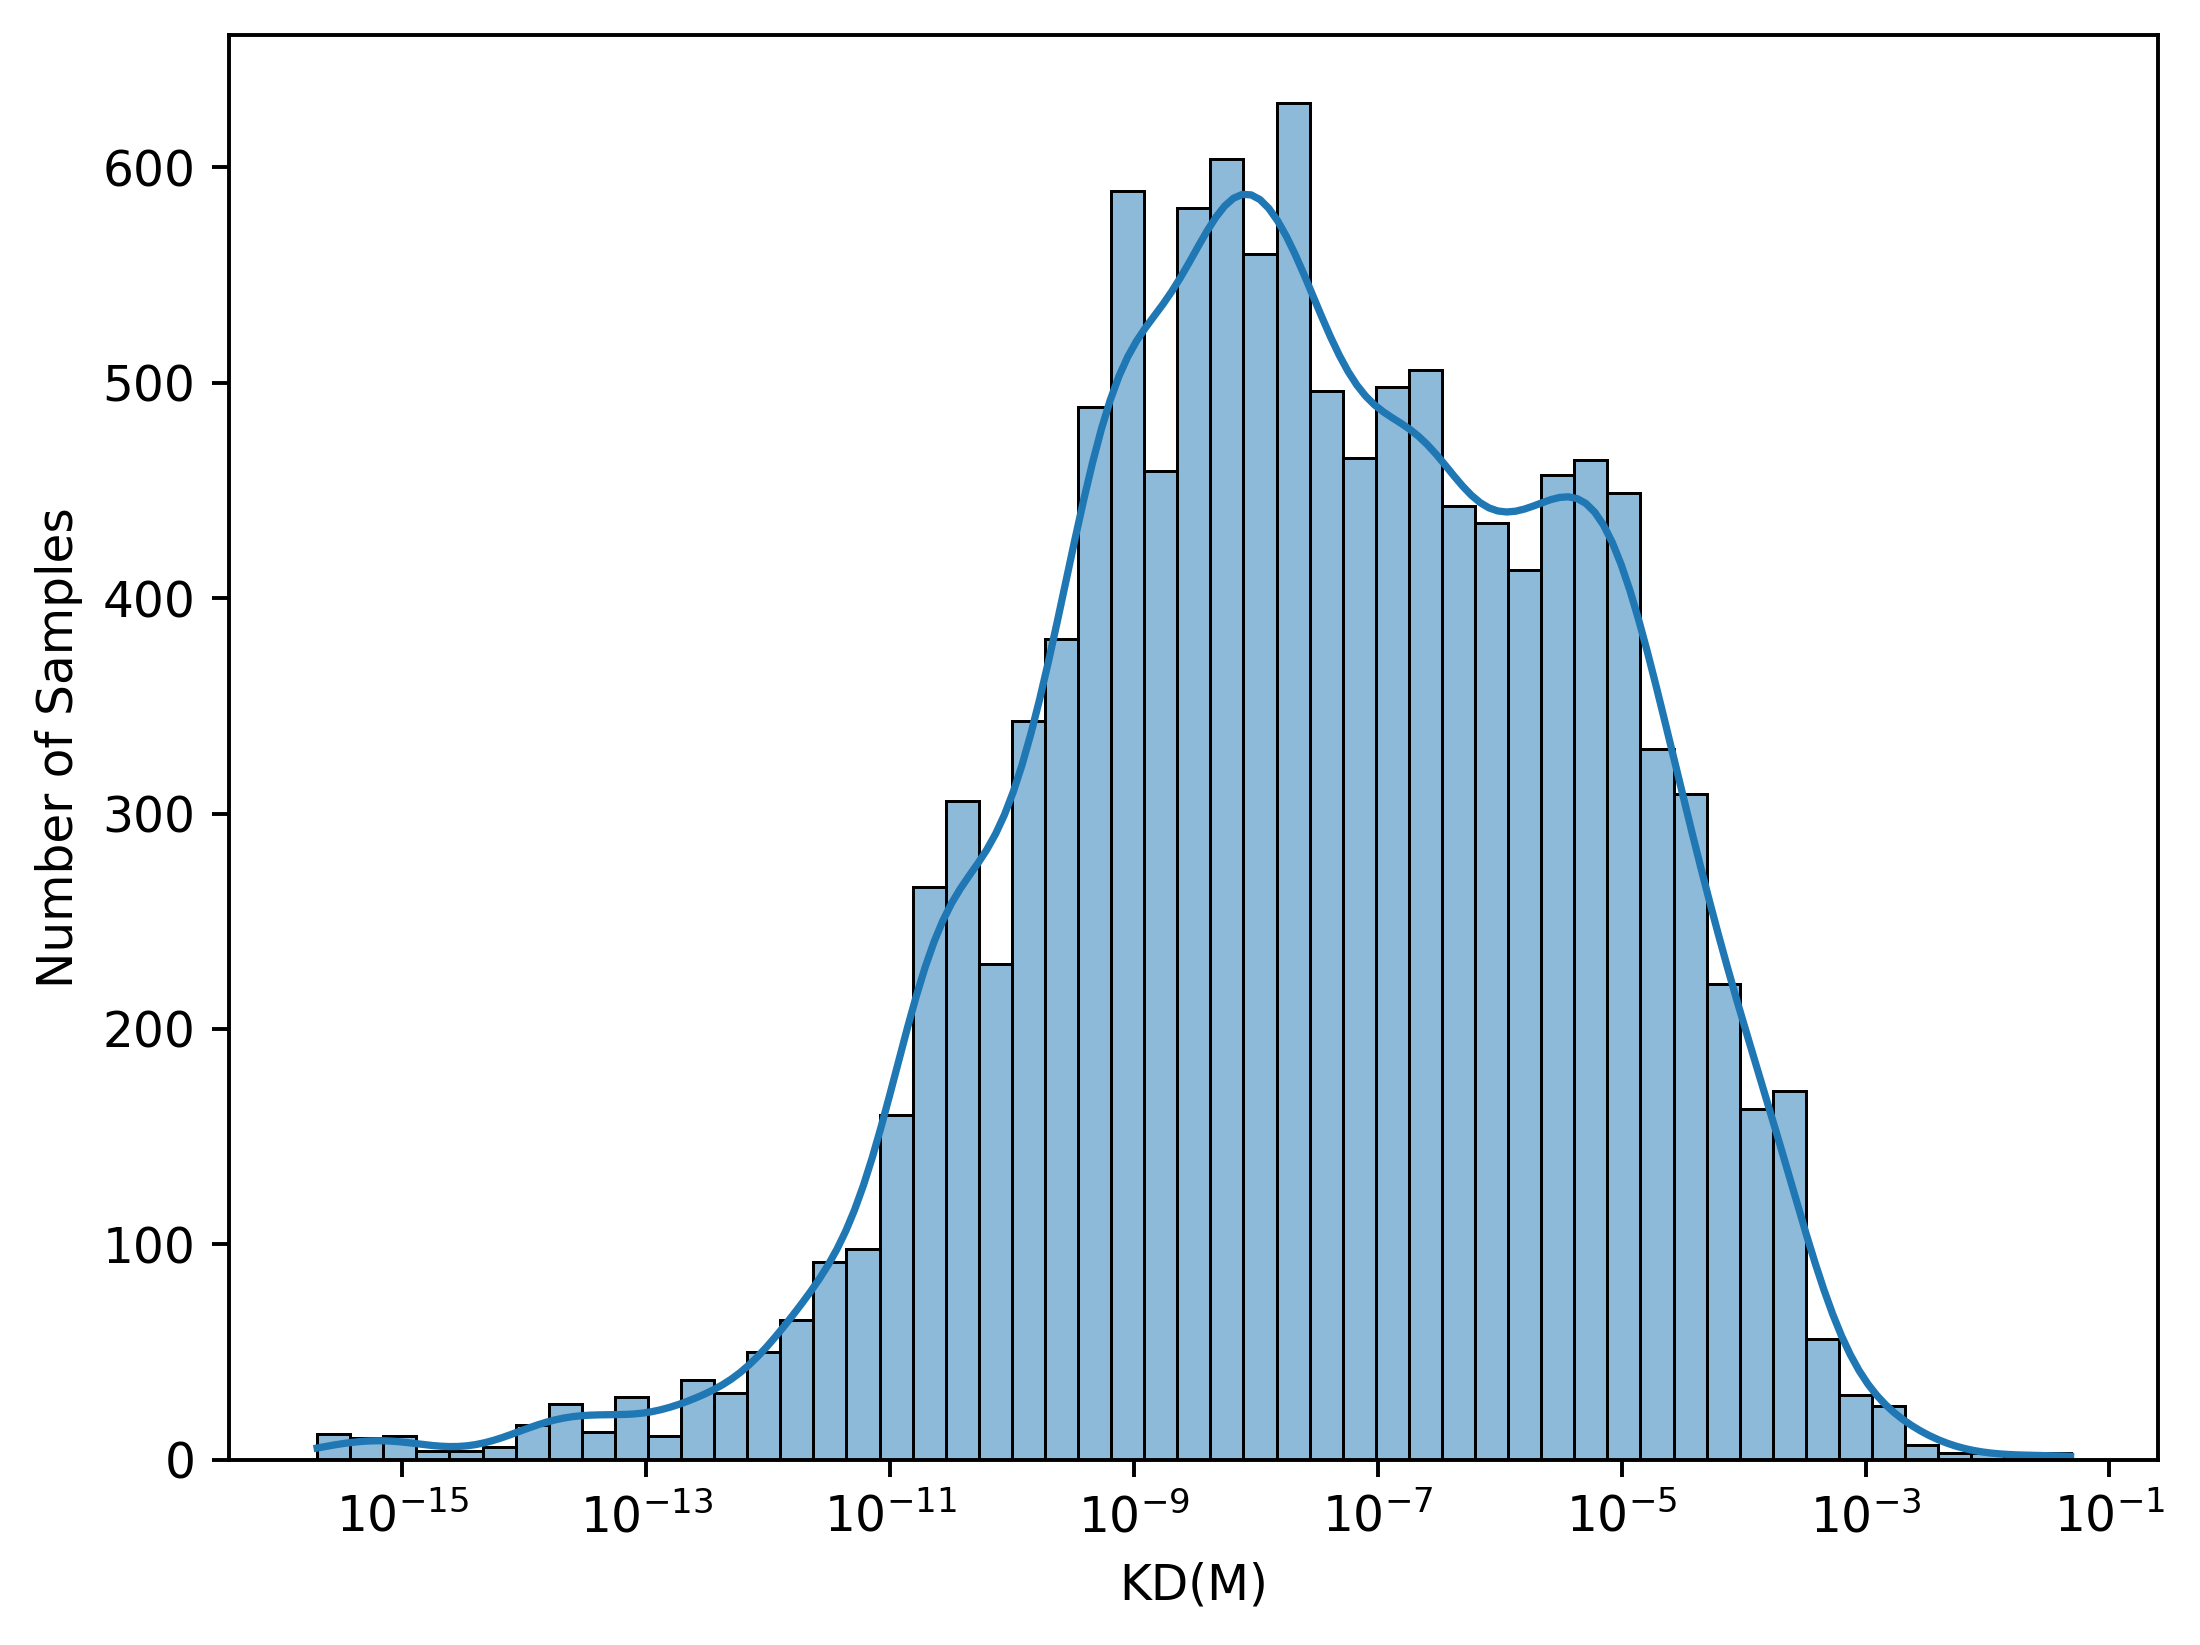

In [8]:
plt.figure(dpi=dpi)
sns.histplot(data=df_merge, x="KD(M)", kde=True, log_scale=True)
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

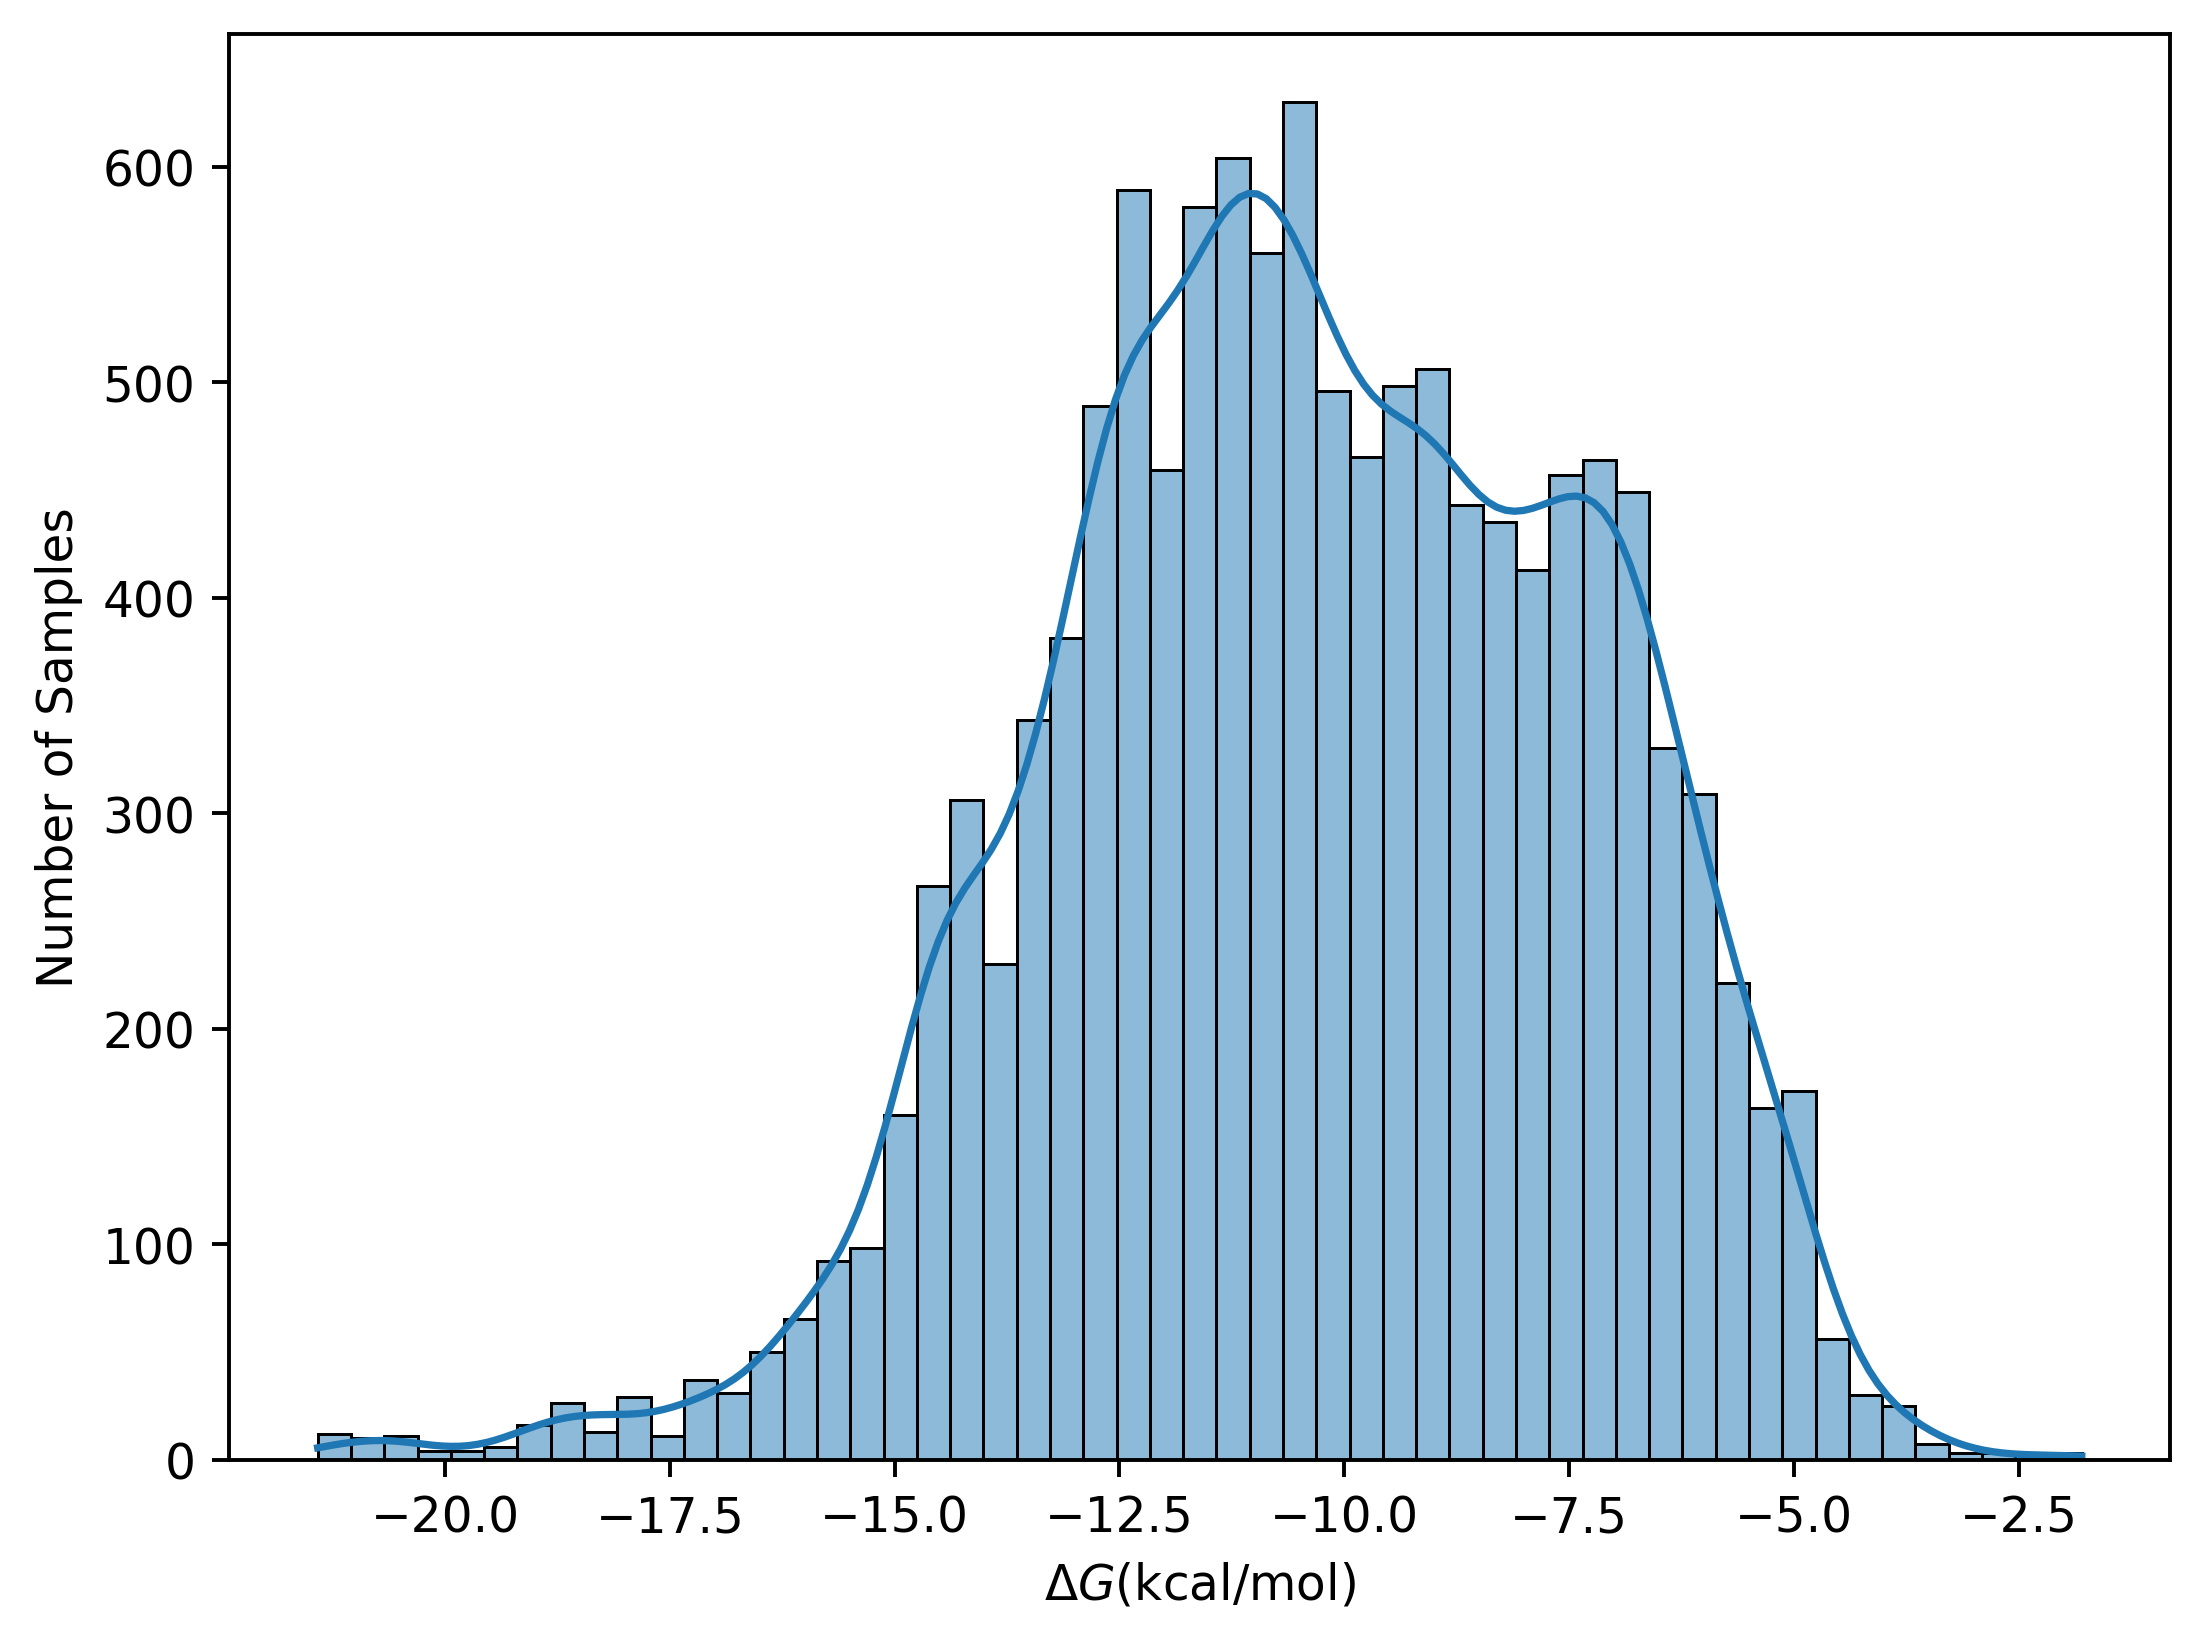

In [9]:
plt.figure(dpi=dpi)
sns.histplot(data=df_merge, x="dG(kcal/mol)", kde=True, log_scale=False)
plt.xlabel(r'$\Delta G$(kcal/mol)')
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f'Affinity Distribution of All Included Samples.{suffix}'), dpi=dpi  )
plt.show()

In [10]:
# plt.figure(dpi=dpi)
# sns.histplot(data=df_merge[df_merge['Source Data Set']!='SKEMPI v2.0'], x="dG(kcal/mol)", kde=True, log_scale=False, label='others')
# sns.histplot(data=df_merge[df_merge['Source Data Set']=='SKEMPI v2.0'], x="dG(kcal/mol)", kde=True, log_scale=False, label='SKEMPI v2.0')
# plt.legend()
# plt.ylabel("Number of Samples")
# plt.tight_layout()
# plt.show()

In [11]:
# plt.figure(dpi=dpi)
# sns.histplot(data=df_merge[df_merge['Source Data Set']!='SKEMPI v2.0'], x="dG(kcal/mol)", kde=True, log_scale=False, alpha=0.5, label='others')
# sns.histplot(data=df_merge[df_merge['Source Data Set']=='SKEMPI v2.0'], x="dG(kcal/mol)", kde=True, log_scale=False, alpha=0.5, label='SKEMPI v2.0')
# plt.legend()
# plt.ylabel("Number of Samples")
# plt.tight_layout()
# plt.show()

# Resolution & Method

## Resolution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


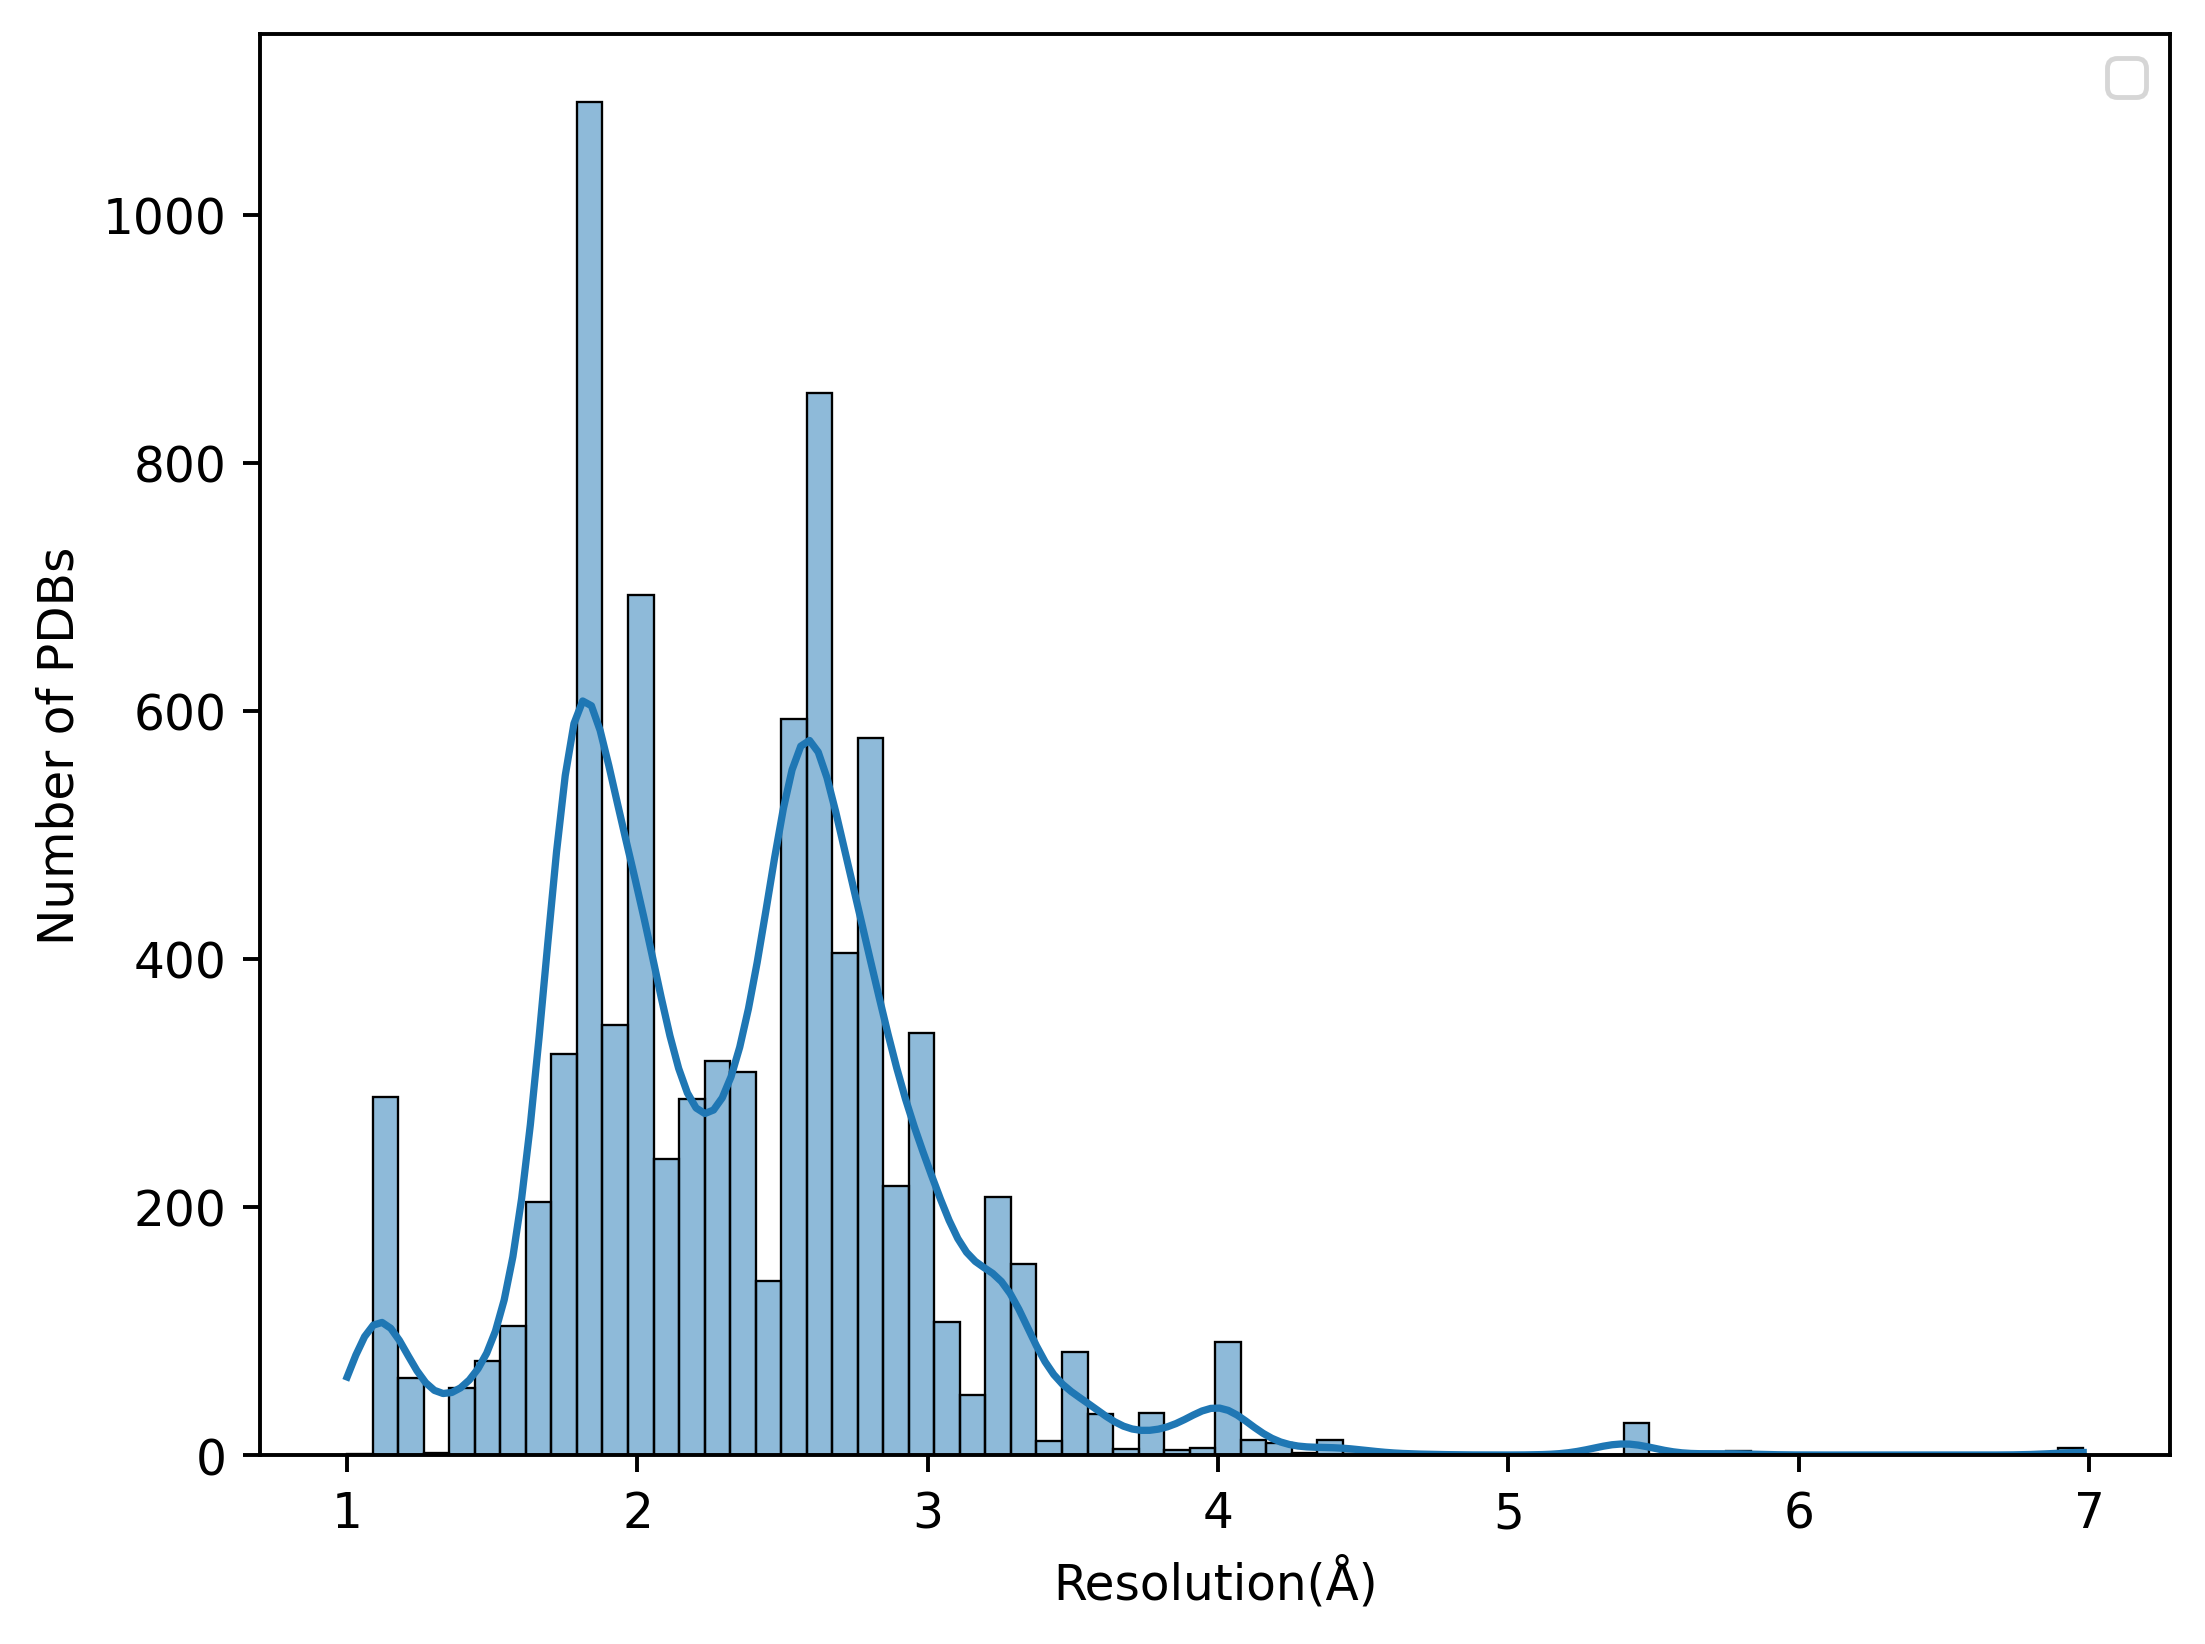

In [12]:
df_merge_wResolution = df_merge[df_merge["Resolution(Å)"].apply(lambda x: isinstance(x,float))]

plt.figure(dpi=dpi)
sns.histplot(data=df_merge_wResolution, x="Resolution(Å)", kde=True, log_scale=False, alpha=0.5)
plt.legend()
plt.ylabel("Number of PDBs")
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f'Distribution of PDB Resolution in the Dataset.{suffix}'), dpi=dpi  )
plt.show()

## Structure Method

### pie3

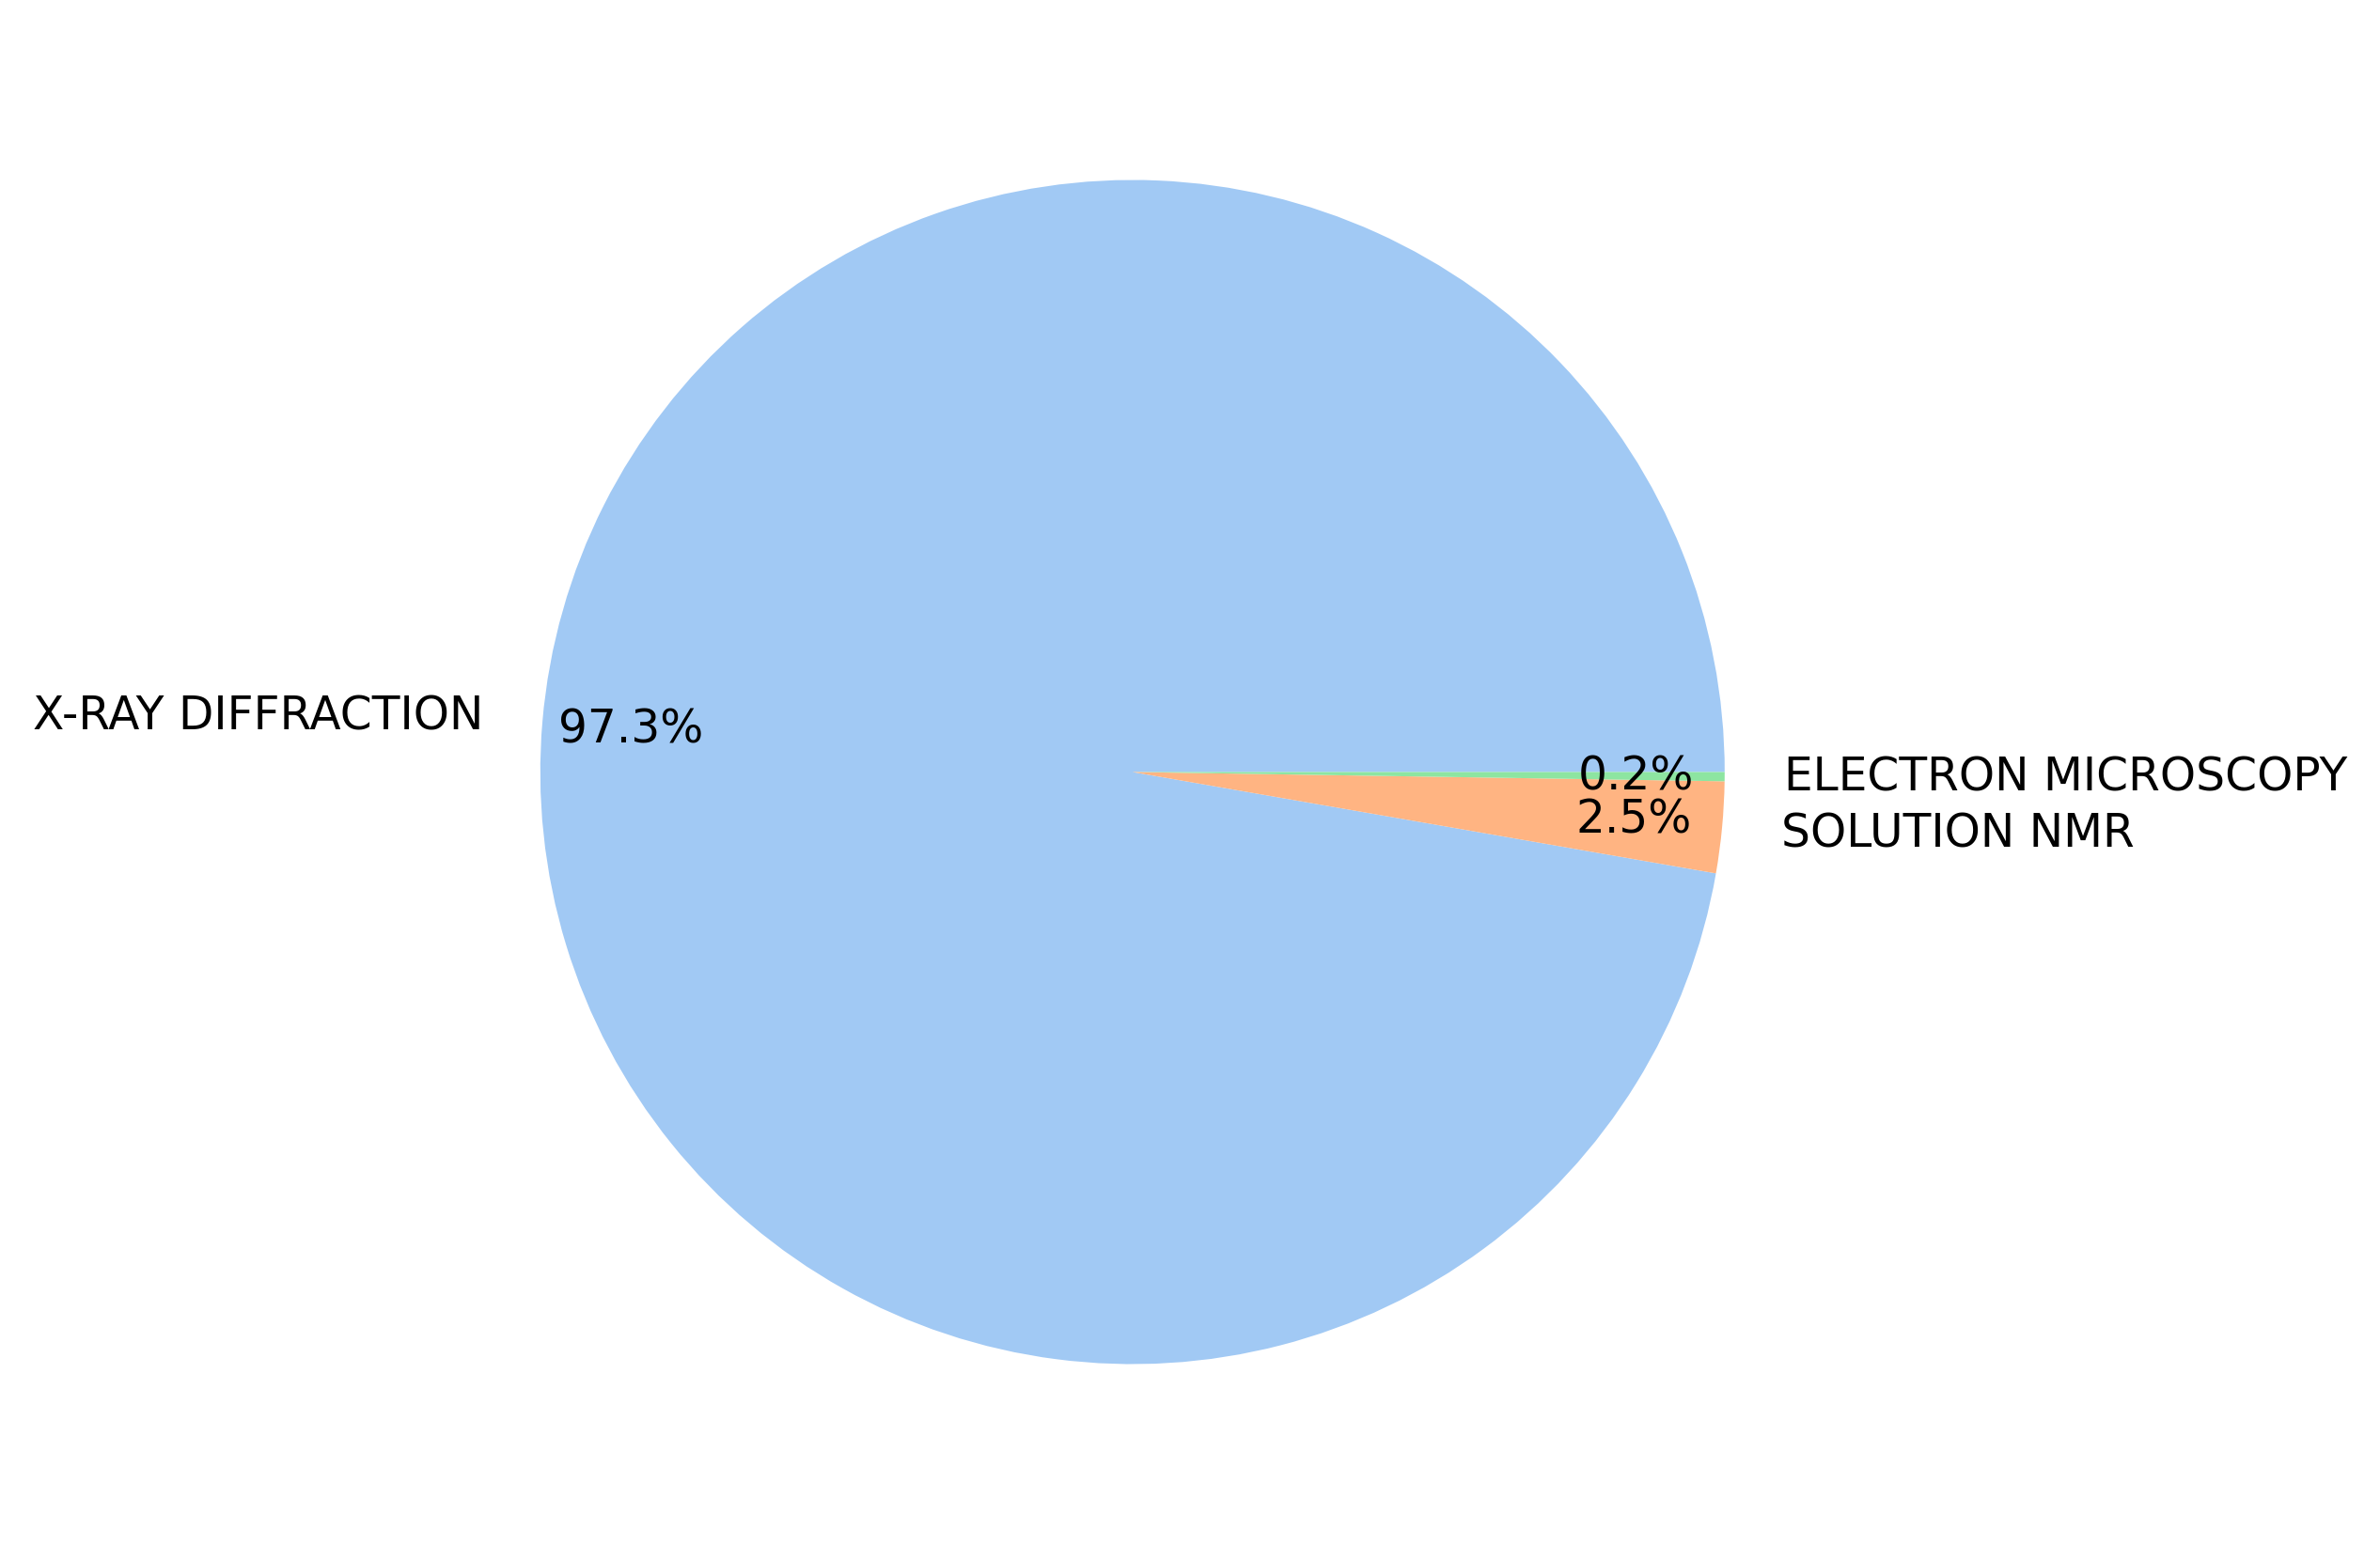

In [13]:
colors = sns.color_palette('pastel')#('viridis')#pastel
value_counts = df_merge["Structure Method"].value_counts()
x = value_counts.values
labels = value_counts.index

plt.figure(dpi=dpi)
plt.pie(value_counts, colors=colors, labels=labels, autopct='%1.1f%%', pctdistance=0.85)
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f'Structural Determination Methods for Each Sample in the Dataset.{suffix}'), dpi=dpi  )
plt.show()

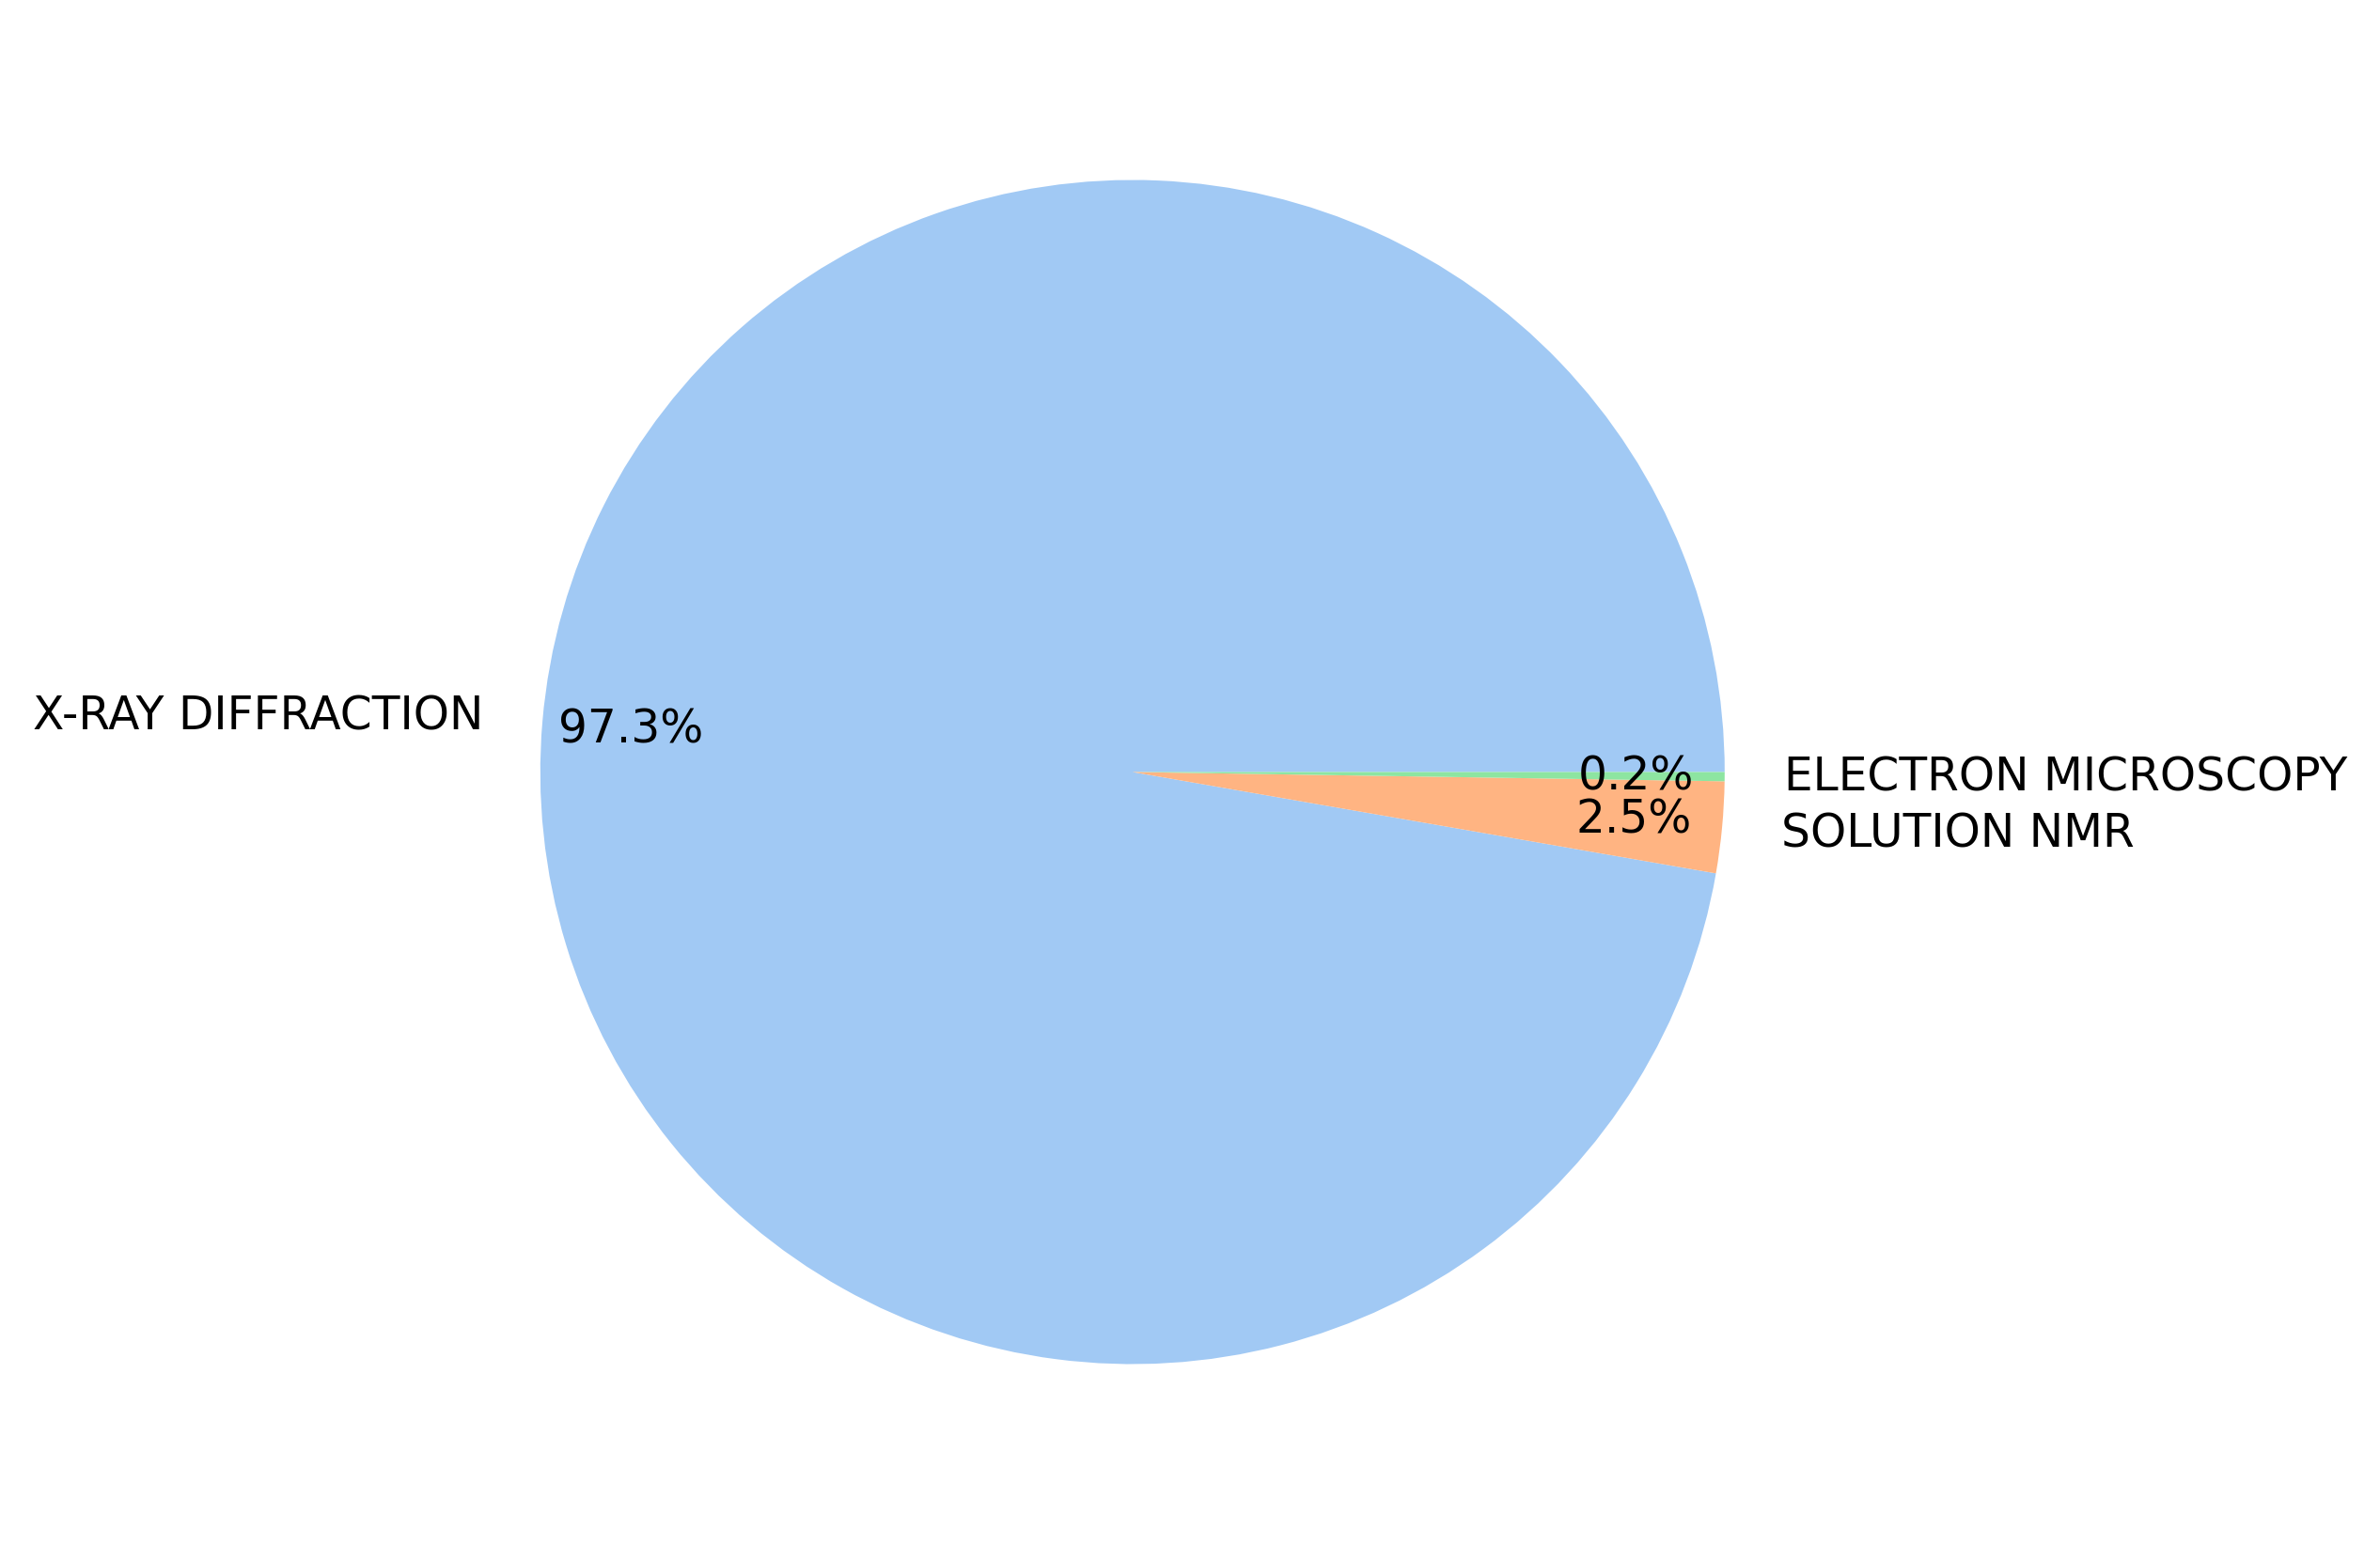

In [14]:
# 除去Unknown后，剩余部分样本的结构测定方法
colors = sns.color_palette('pastel')#('viridis')#pastel
value_counts = df_merge[df_merge["Structure Method"]!='Unknown']["Structure Method"].value_counts()
x = value_counts.values
labels = value_counts.index

plt.figure(dpi=dpi)
plt.pie(value_counts, colors=colors, labels=labels, autopct='%1.1f%%', pctdistance=0.85)
plt.tight_layout()
plt.show()

/tmp/ipykernel_177634/4035659457.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_tmp, x='Structure Method', y='Resolution(Å)', palette=palette)#, inner="point")
/tmp/ipykernel_177634/4035659457.py:6: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(data=df_tmp, x='Structure Method', y='Resolution(Å)', palette=palette)#, inner="point")


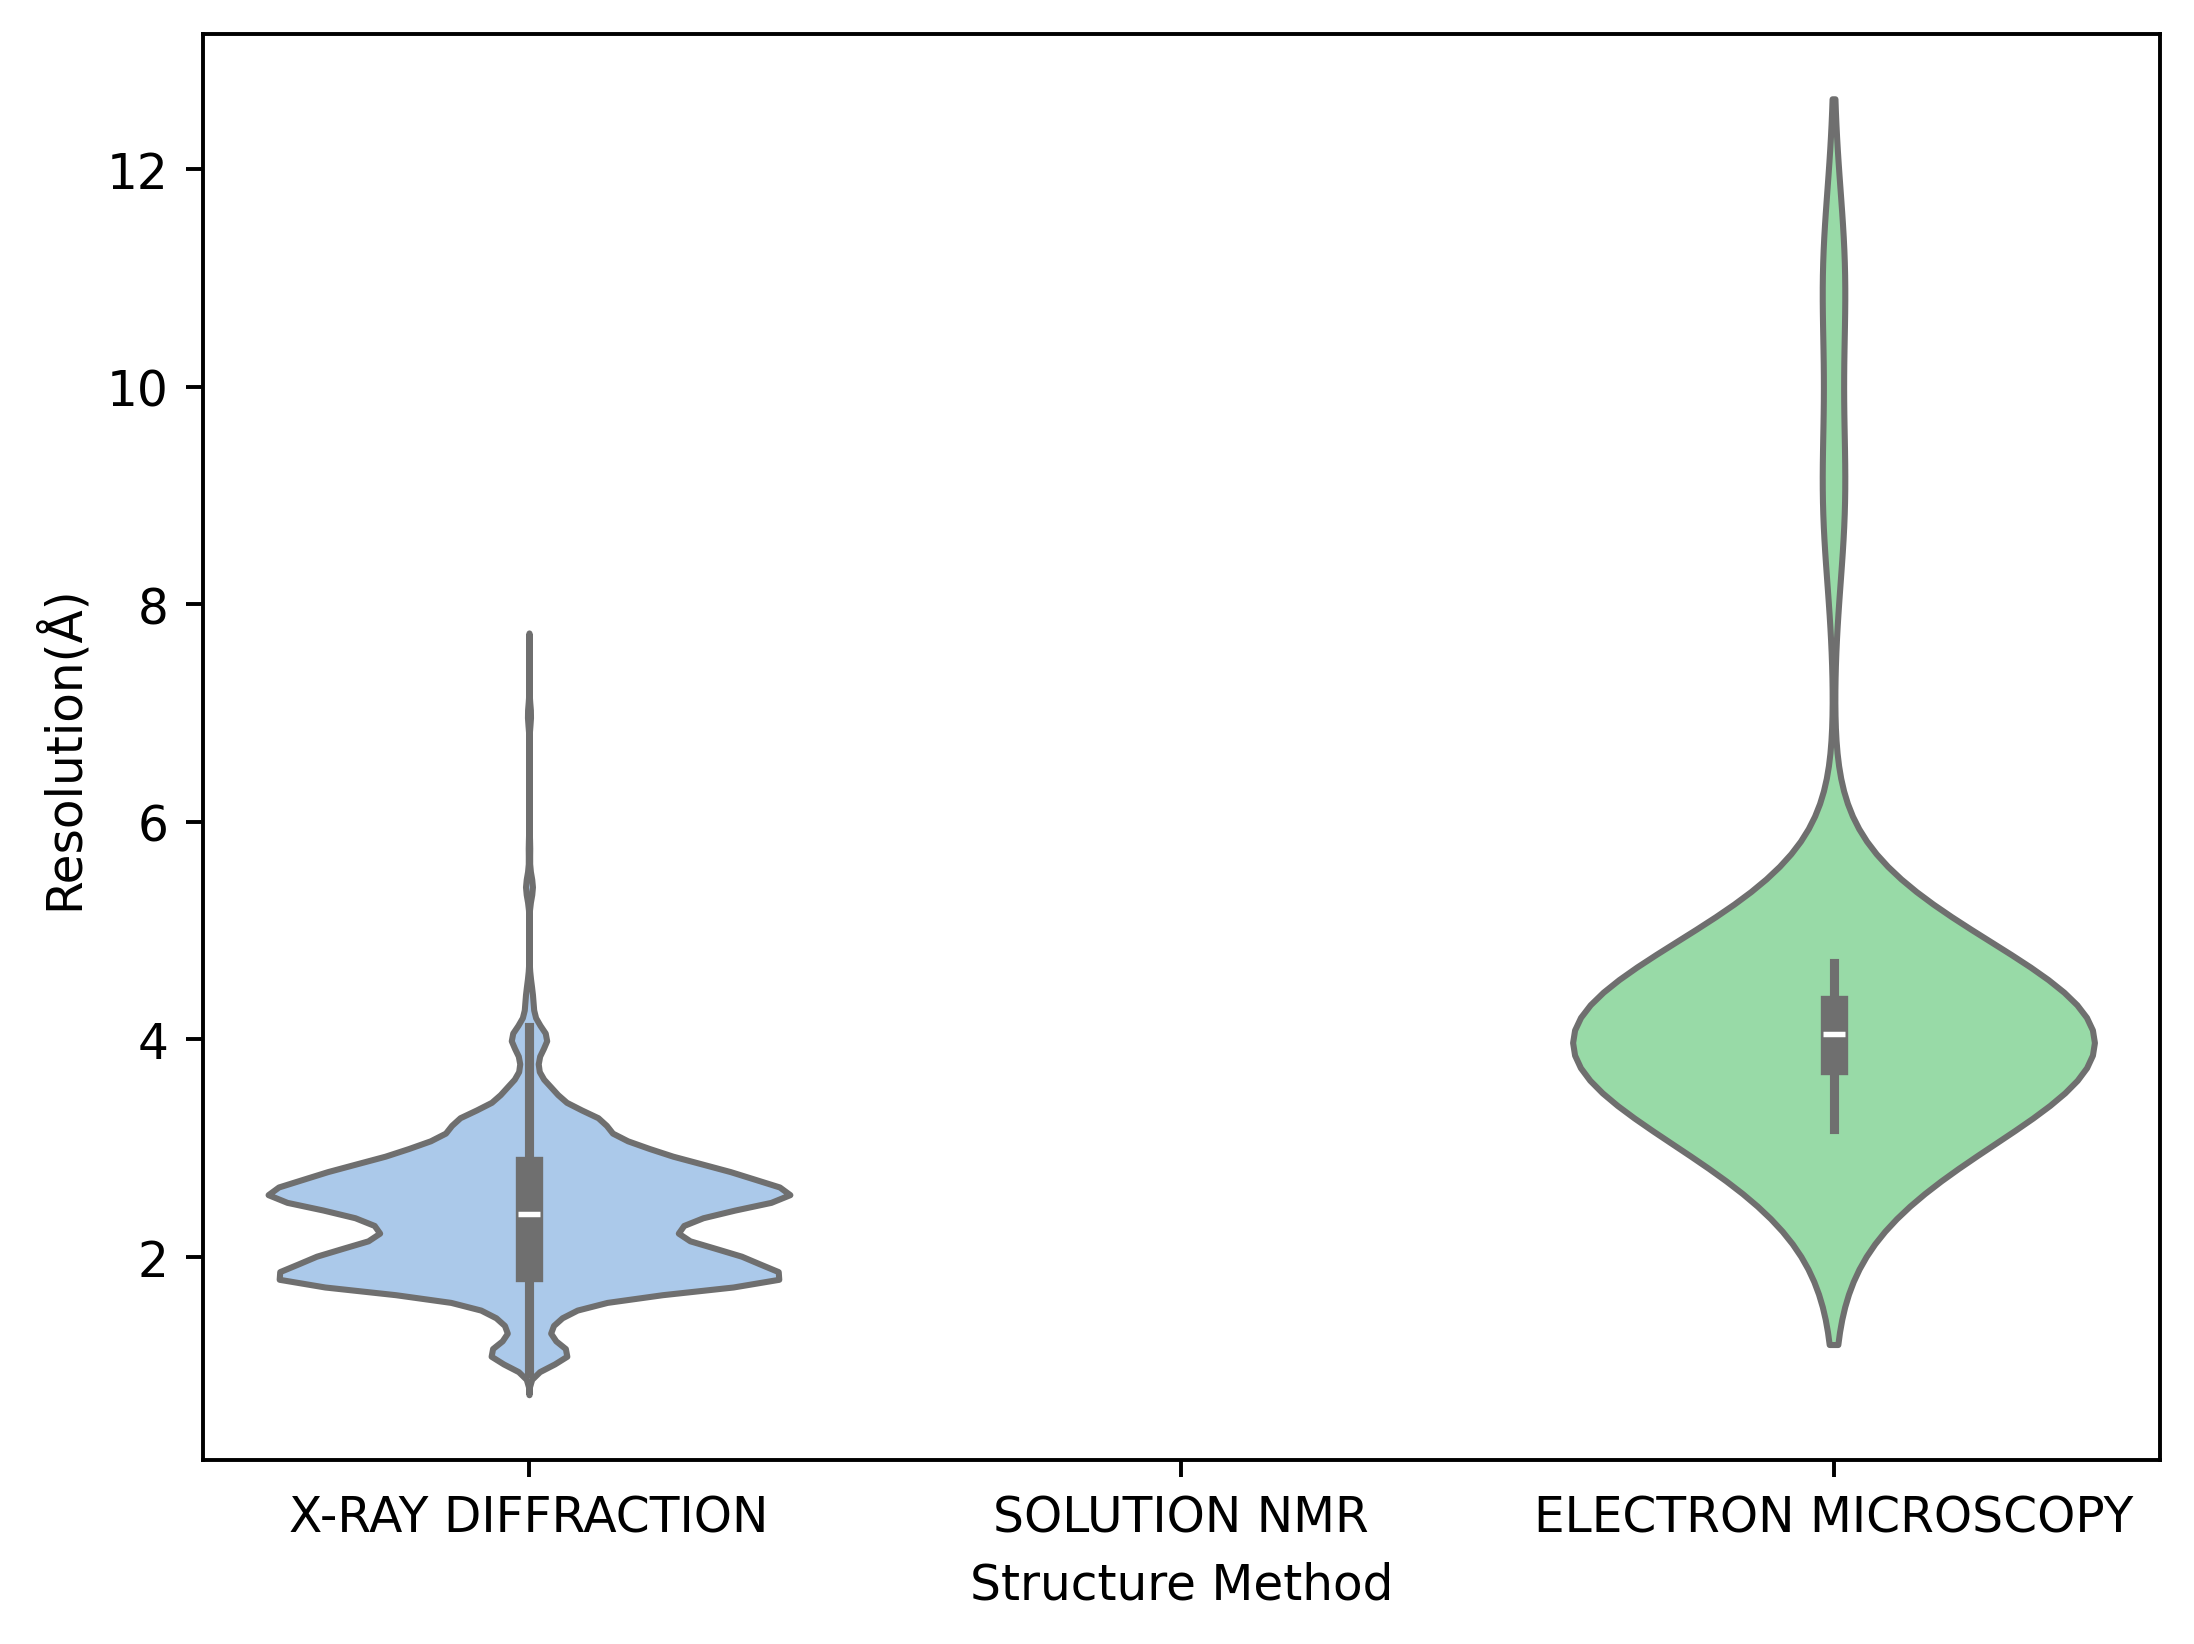

In [15]:
df_tmp = df_merge.loc[:,['Structure Method','Resolution(Å)']].replace('Unknown',np.nan)
df_tmp['Resolution(Å)'] = df_tmp['Resolution(Å)'].replace('NMR',np.nan)
df_tmp['Resolution(Å)'] = df_tmp['Resolution(Å)'].astype(float)
plt.figure(dpi=dpi)
palette = sns.color_palette(palette='pastel')
sns.violinplot(data=df_tmp, x='Structure Method', y='Resolution(Å)', palette=palette)#, inner="point")
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f'Distribution of Structural Resolution by Different Structural Determination Methods.{suffix}'), dpi=dpi  )
plt.show()

In [16]:
df_merge[df_merge['Structure Method']=='SOLUTION NMR']['Resolution(Å)']

55       NaN
163      NaN
7002     NaN
7003     NaN
7004     NaN
        ... 
12187    NaN
12251    NaN
12352    NaN
12356    NaN
12372    NaN
Name: Resolution(Å), Length: 300, dtype: object

### barplot

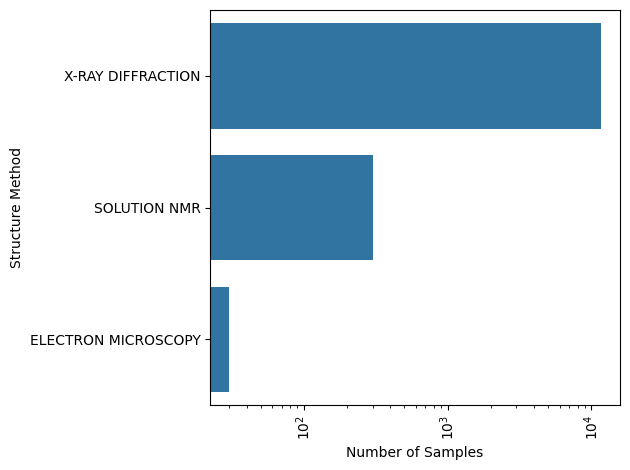

In [17]:
# sns.histplot(data=df_merge, x="Structure_Method", kde=False, log_scale=False, alpha=0.5)
value_counts = df_merge["Structure Method"].value_counts()
df_tmp = pd.DataFrame(value_counts).reset_index()#.rename(columns={'index':'Structure Method', 'Structure Method':'count'})
sns.barplot(data=df_tmp,x="count",y="Structure Method")
plt.xlabel("Number of Samples")
plt.xscale("log")
# 设置x轴标签倾斜45度
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

This dataset has 3027 unique PDBs in total.


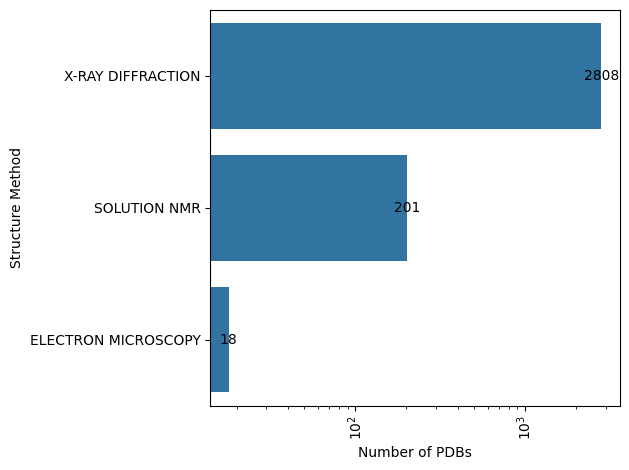

In [18]:
value_counts = df_merge.drop_duplicates(subset=['PDB'],keep='first')["Structure Method"].value_counts()
print(f"This dataset has {value_counts.sum()} unique PDBs in total.")
df_tmp = pd.DataFrame(value_counts).reset_index()#.rename(columns={'index':'Structure Method', 'Structure Method':'count'})
ax = sns.barplot(data=df_tmp, x="count", y="Structure Method")
# 在每个柱子上方添加数值标签
for i, (key,value) in enumerate(dict(value_counts).items()):
    ax.text(x=value, y=i, s=str(value), ha='center', va='center')
plt.xlabel("Number of PDBs")
plt.xscale("log")
# 设置x轴标签倾斜45度
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## Affinity Method

### pie

In [19]:
# Affinity Method
# SPR         2798
# FL          1464
# ITC          616
# IASP         518
# RA           371
# SFFL         365
# SP           349
# ELISA        220
# IAFL         190
# KinExA       134
# IARA         133
# BI            72
# CSPRIA        45
# ELFA          26
# ESMA          23
# SE            14
# SFPF          12
# SPR,SFFL      10
# IAGE           9
# EMSA           7

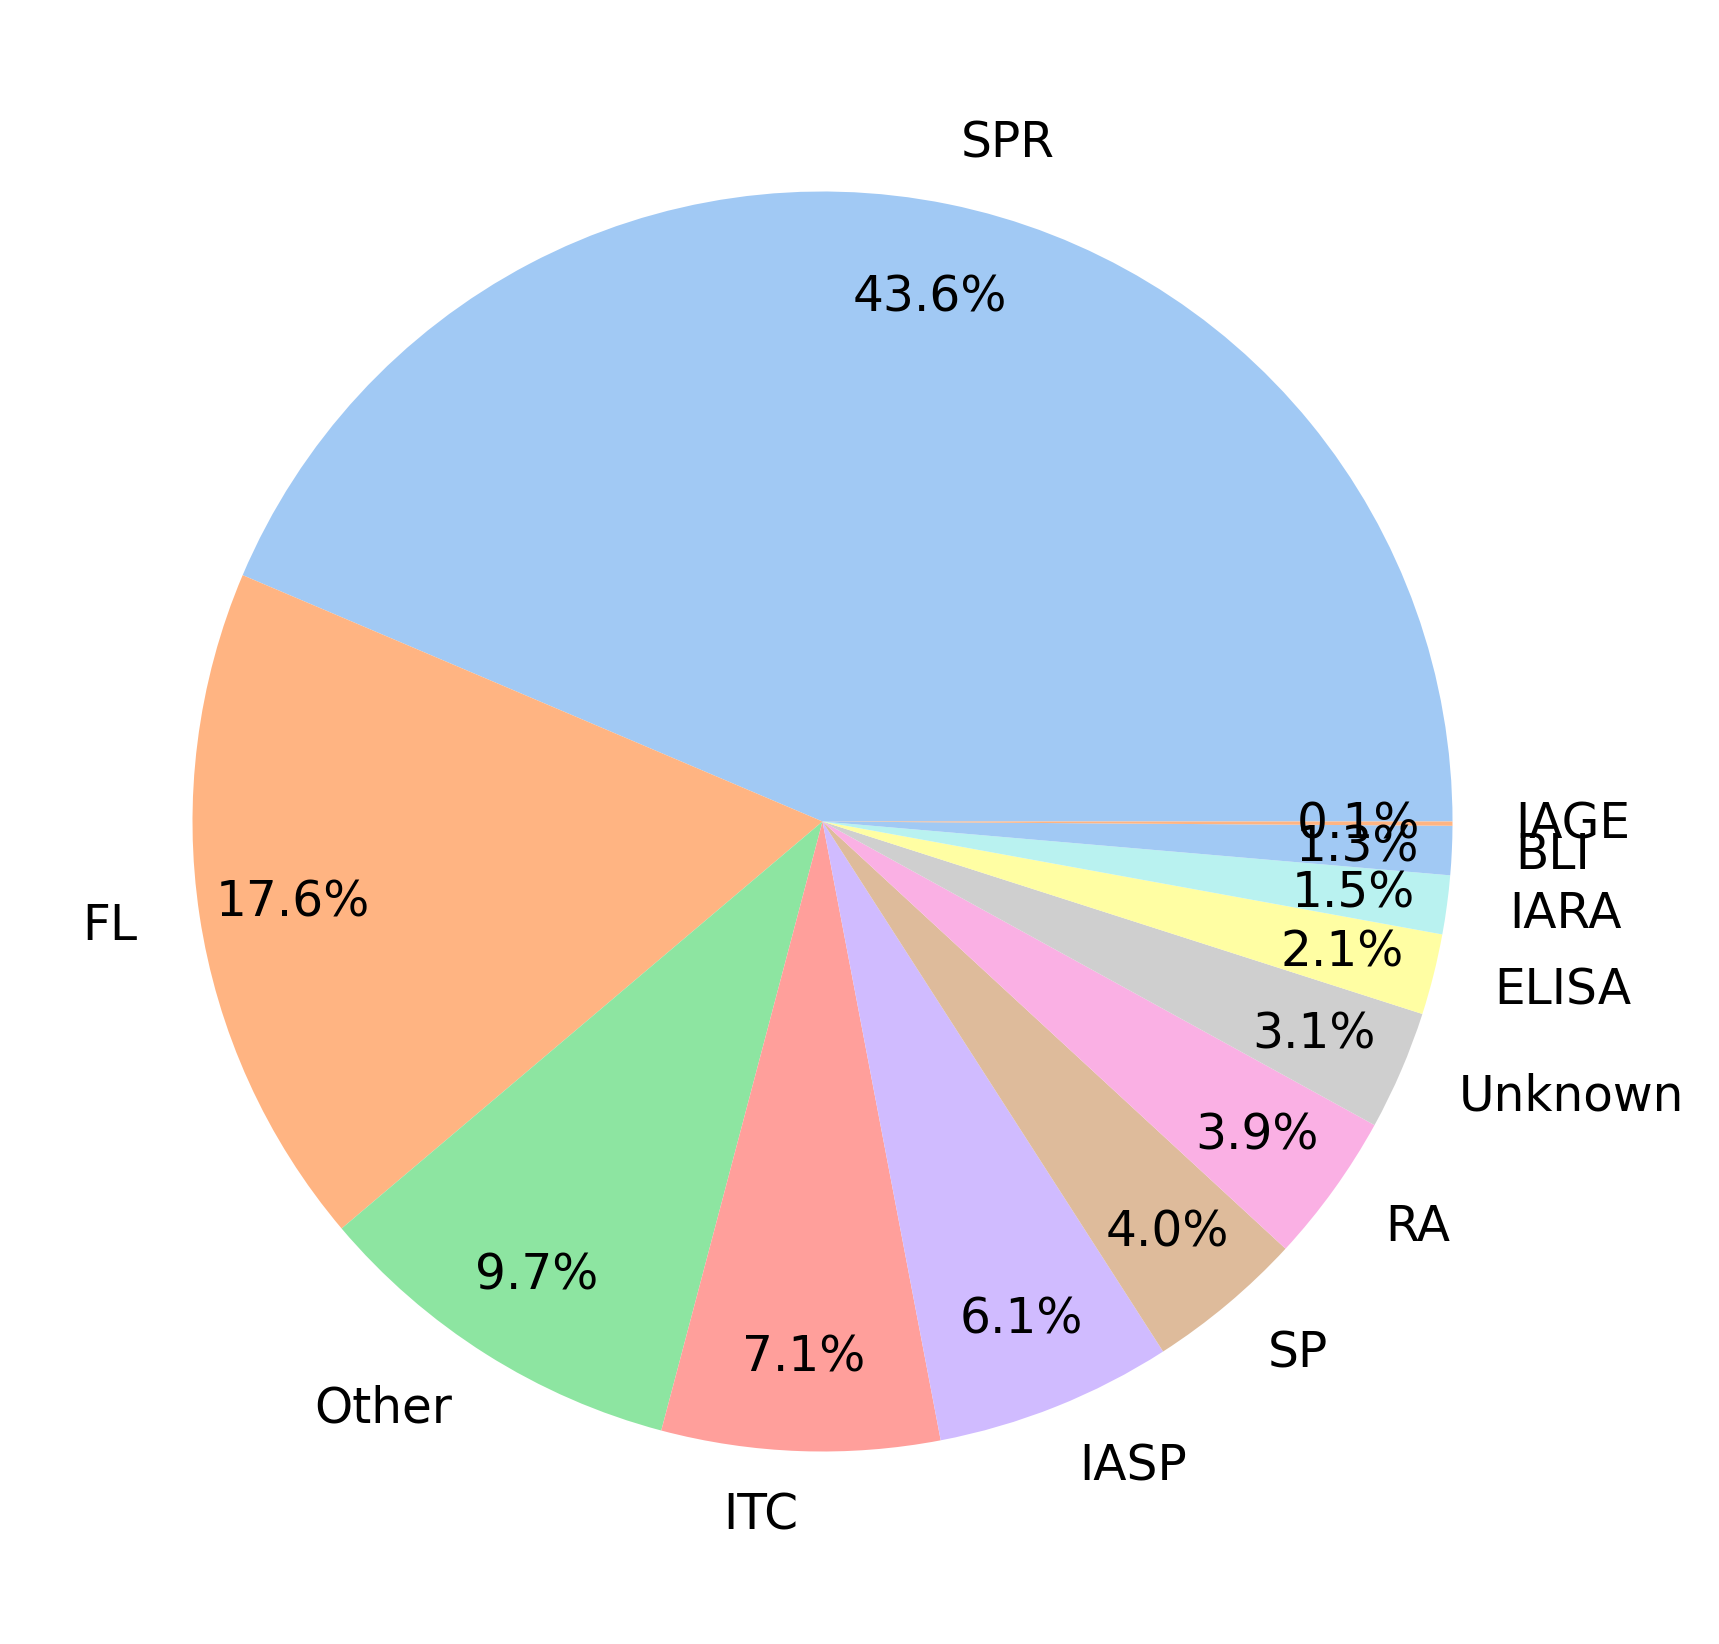

In [20]:
# df_merge["Affinity Method"] = df_merge["Affinity Method"].apply(lambda x: str(x).strip())

renameAffinityMethods = {
    'Biacore': 'SPR',
    'Biacore 3000 | Biacore T100': 'SPR',
    'Biacore 3000': 'SPR',
    'Biacore 2000': 'SPR',
    'Biacore 1000': 'SPR',
    'Biacore T100': 'SPR',
    'Kinetic Exclusion Assay': 'KinExA',
    'Time-resolved fluorescence anisotropy ': 'Other',
    'AUC': 'Other',
    'flow cytometry': 'Other',
    'Saturation Analysis': 'Other',
    'Fluorescence': 'Other',
    'Fluorescence': 'Other',
    'Solution Equilibrium Titration': 'Other',
    'IAFL': 'Other', 
    'KinExA': 'Other', 
#     'IARA': 'Other', 
    'BI': 'BLI', 
    'CSPRIA': 'Other', 
    'ELFA': 'Other', 
    'ESMA': 'Other', 
    'SE': 'Other', 
    'SFPF': 'Other', 
    'SPR,SFFL': 'Other',
    'SFFL': 'Other',
#     'IAGE': 'Other', 
    'EMSA': 'Other'}

for old_name, new_name in renameAffinityMethods.items():
    df_merge["Affinity Method"] = df_merge["Affinity Method"].replace(old_name, new_name)

colors = sns.color_palette('pastel')#('viridis')#pastel
value_counts = df_merge["Affinity Method"].value_counts()
x = value_counts.values
labels = value_counts.index

plt.figure(dpi=dpi)
plt.pie(value_counts, colors=colors, labels=labels, autopct='%1.1f%%', pctdistance=0.85)
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f"Affinity Determination Methods for Each Sample in the Dataset(pie).{suffix}"), dpi=dpi)
plt.show()

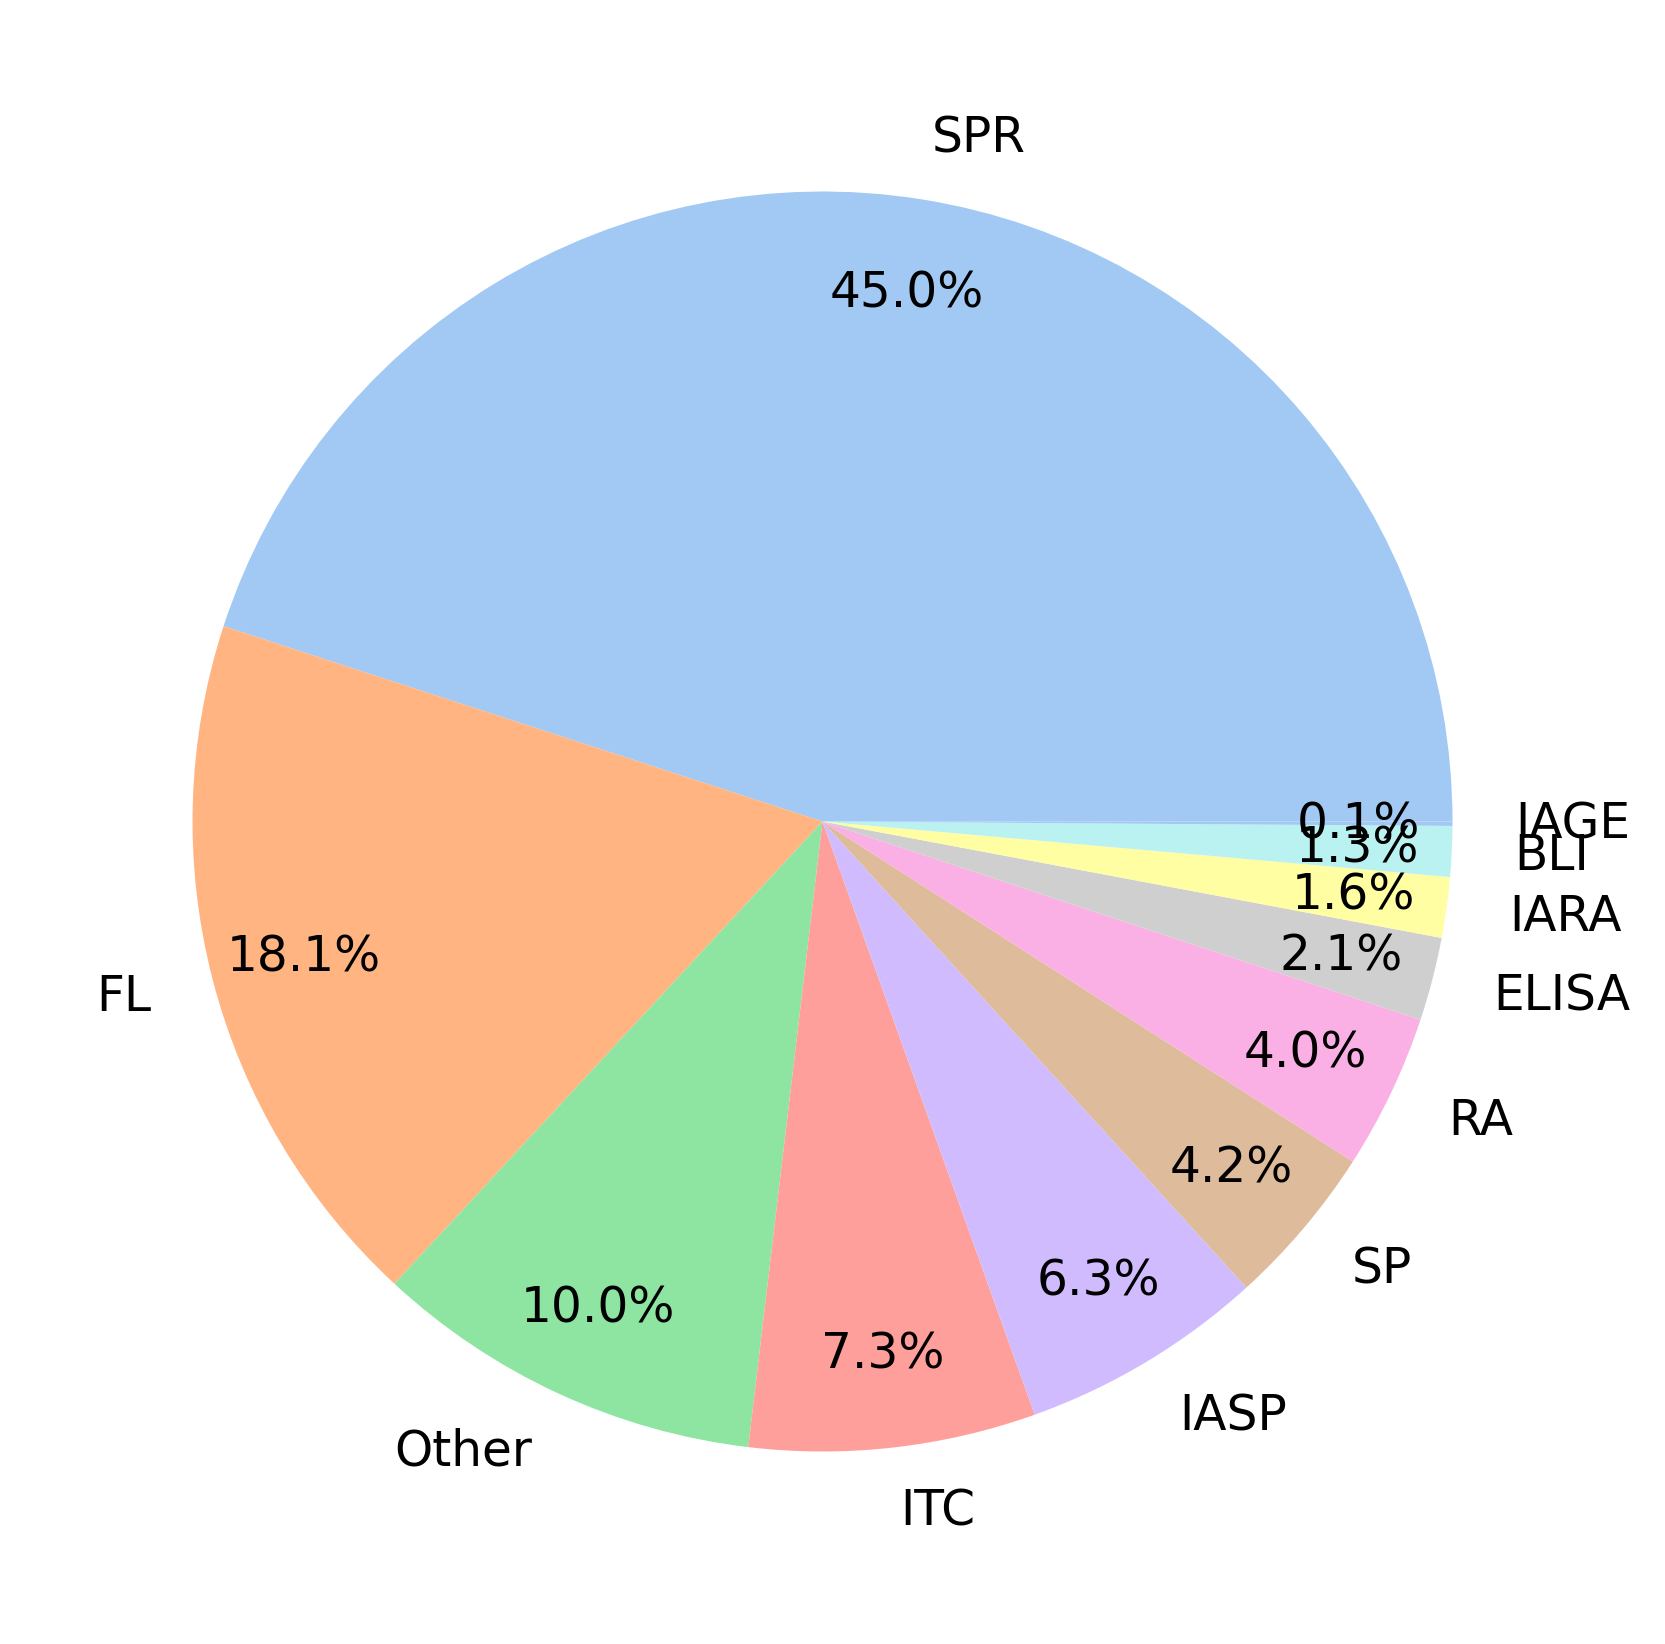

In [21]:
# 除去Unknown后，剩余部分样本的结构测定方法
colors = sns.color_palette('pastel')#('viridis')#pastel
value_counts = df_merge[df_merge["Affinity Method"]!='Unknown']["Affinity Method"].value_counts()
x = value_counts.values
labels = value_counts.index

plt.figure(dpi=dpi)
plt.pie(value_counts, colors=colors, labels=labels, autopct='%1.1f%%', pctdistance=0.85)
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f'Distributions of Known Affinity Measurement Methods(pie).{suffix}'), dpi=dpi )
plt.show()

### barplot

/tmp/ipykernel_177634/1842090681.py:6: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(data=df_tmp, x="count", y="Affinity Method", palette=palette, hue="Affinity Method")


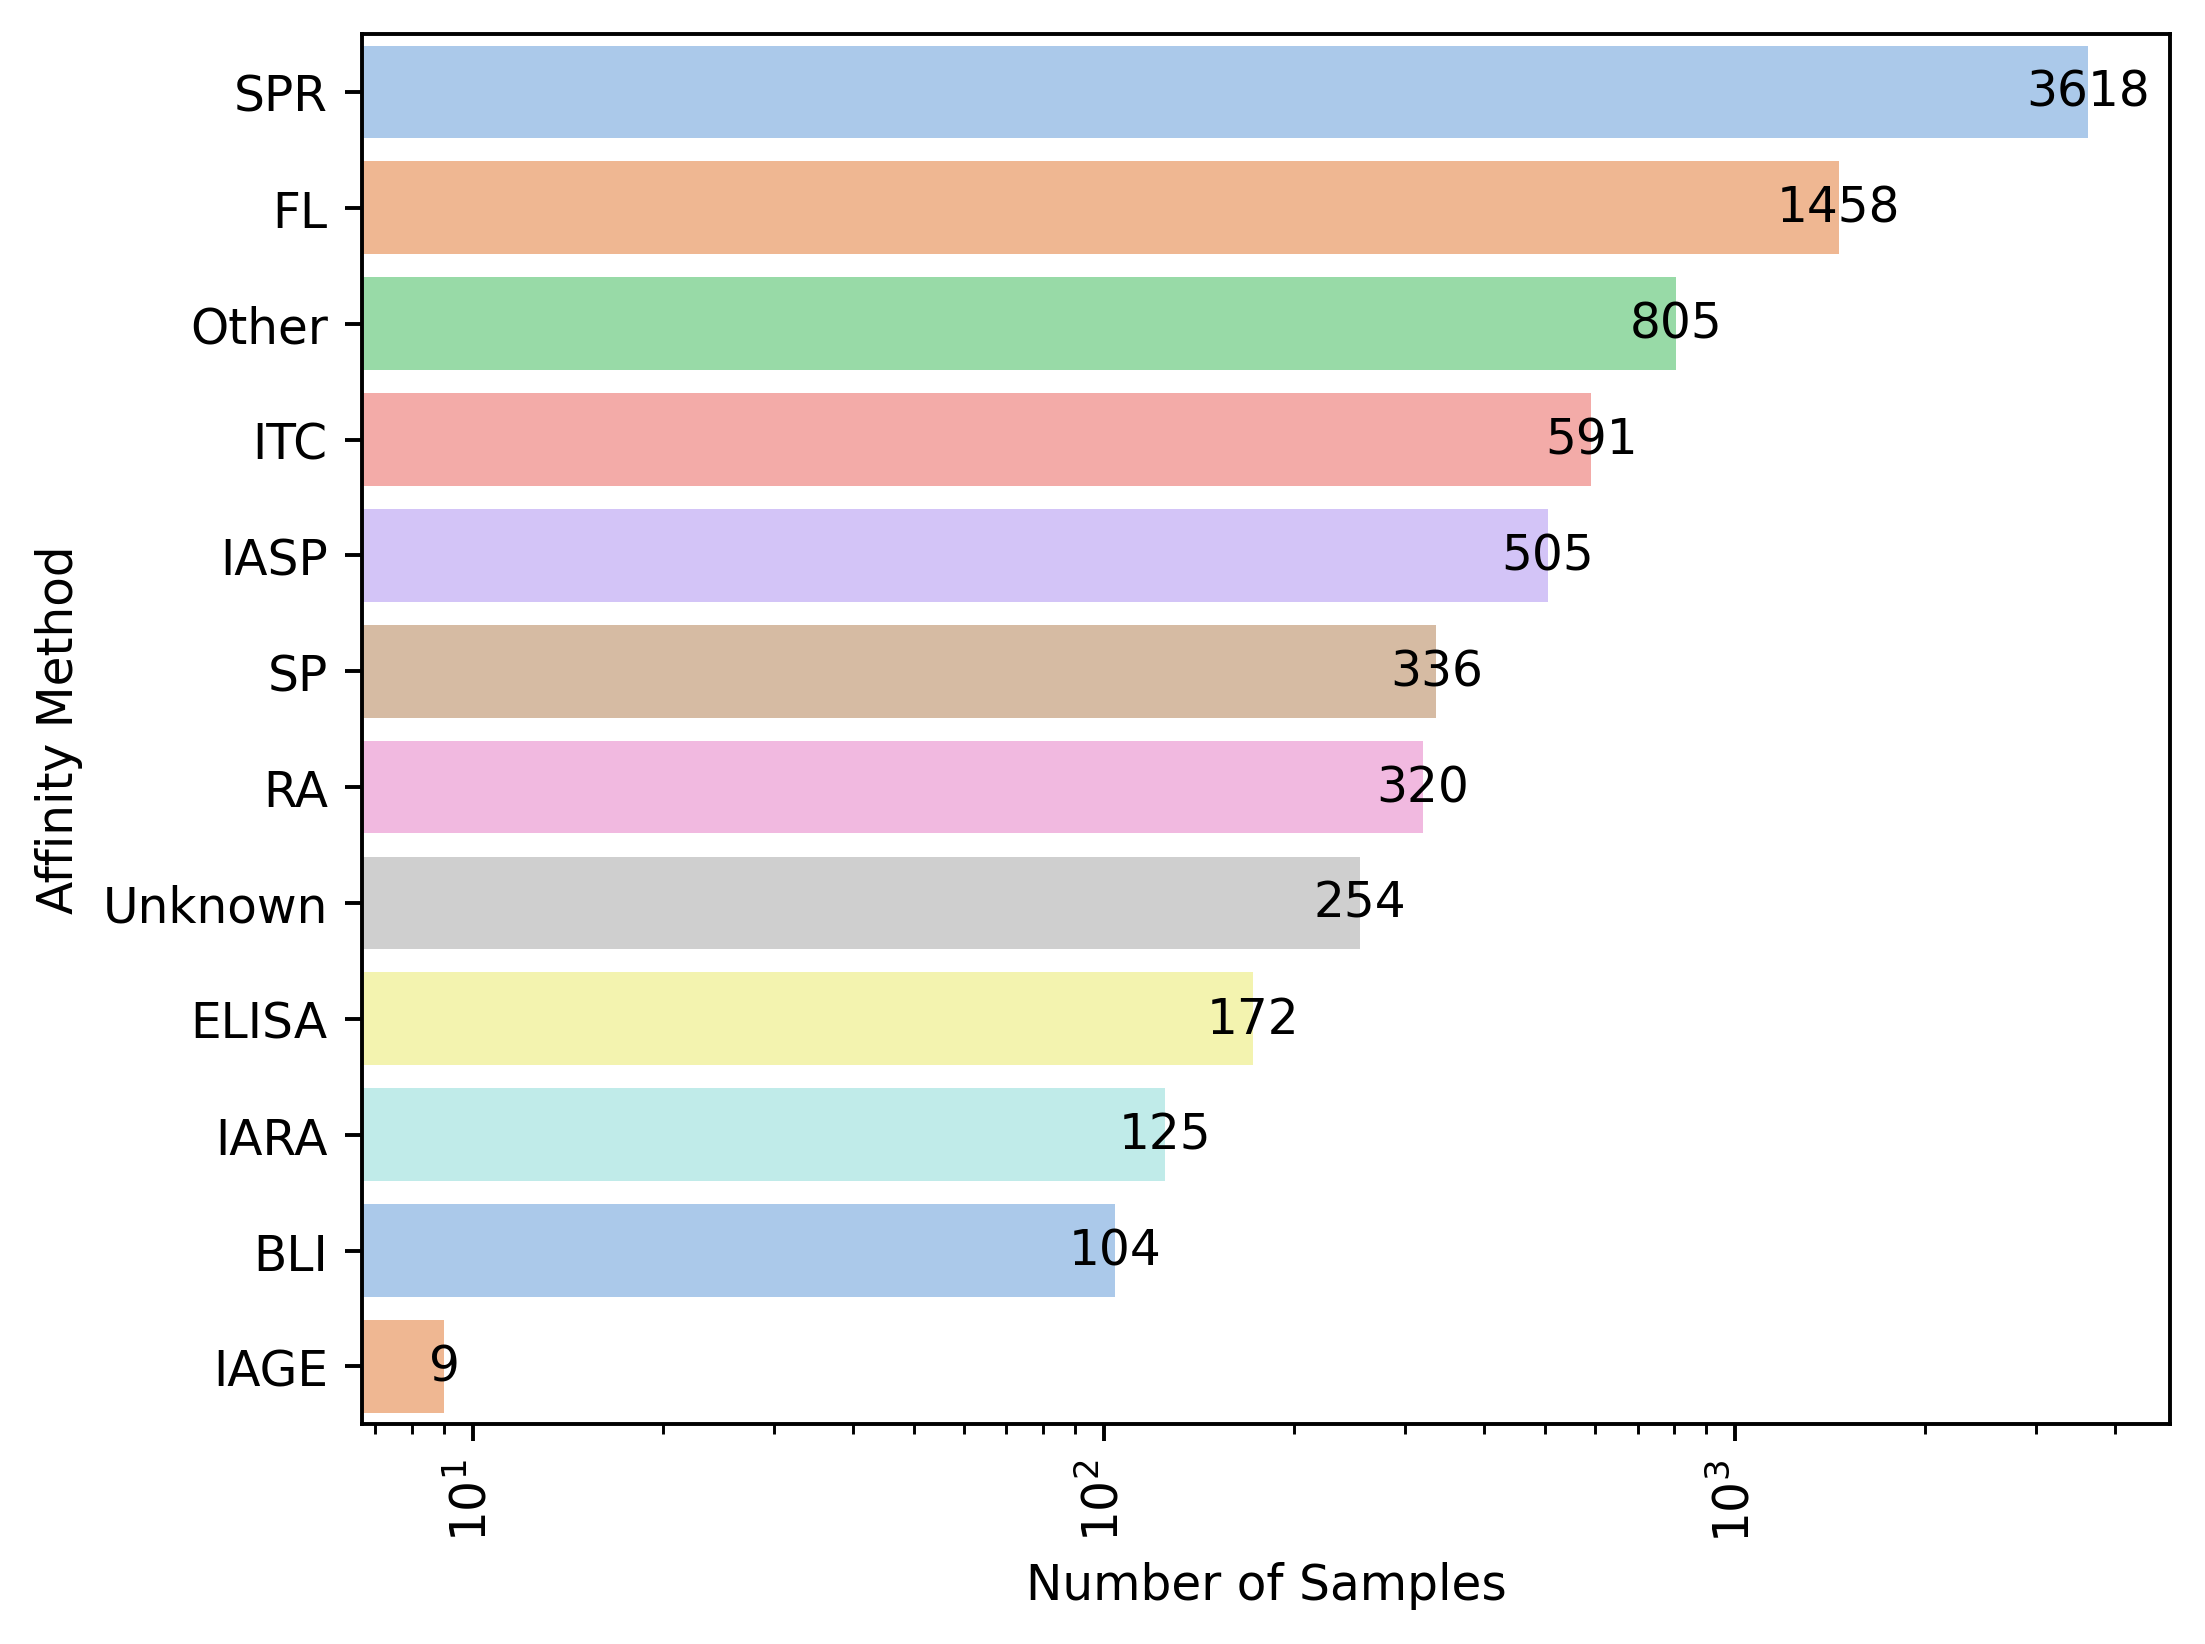

In [22]:
value_counts = df_merge["Affinity Method"].value_counts()
df_tmp = pd.DataFrame(value_counts).reset_index()#.rename(columns={'index':'Affinity Method', 'Affinity Method':'count'})

plt.figure(dpi=dpi)
palette = sns.color_palette('pastel')
ax = sns.barplot(data=df_tmp, x="count", y="Affinity Method", palette=palette, hue="Affinity Method")
# 在每个柱子上方添加数值标签
for i, (key,value) in enumerate(dict(value_counts).items()):
    ax.text(x=value, y=i, s=str(value), ha='center', va='center')
plt.xlabel('Number of Samples')
plt.xscale("log")
# 设置x轴标签倾斜45度
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f"Affinity Determination Methods for Each Sample in the Dataset(bar).{suffix}"), dpi=dpi)
plt.show()

/tmp/ipykernel_177634/597414041.py:7: UserWarning: 
The palette list has fewer values (10) than needed (11) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(data=df_tmp, x="count", y="Affinity Method", palette=palette, hue="Affinity Method")


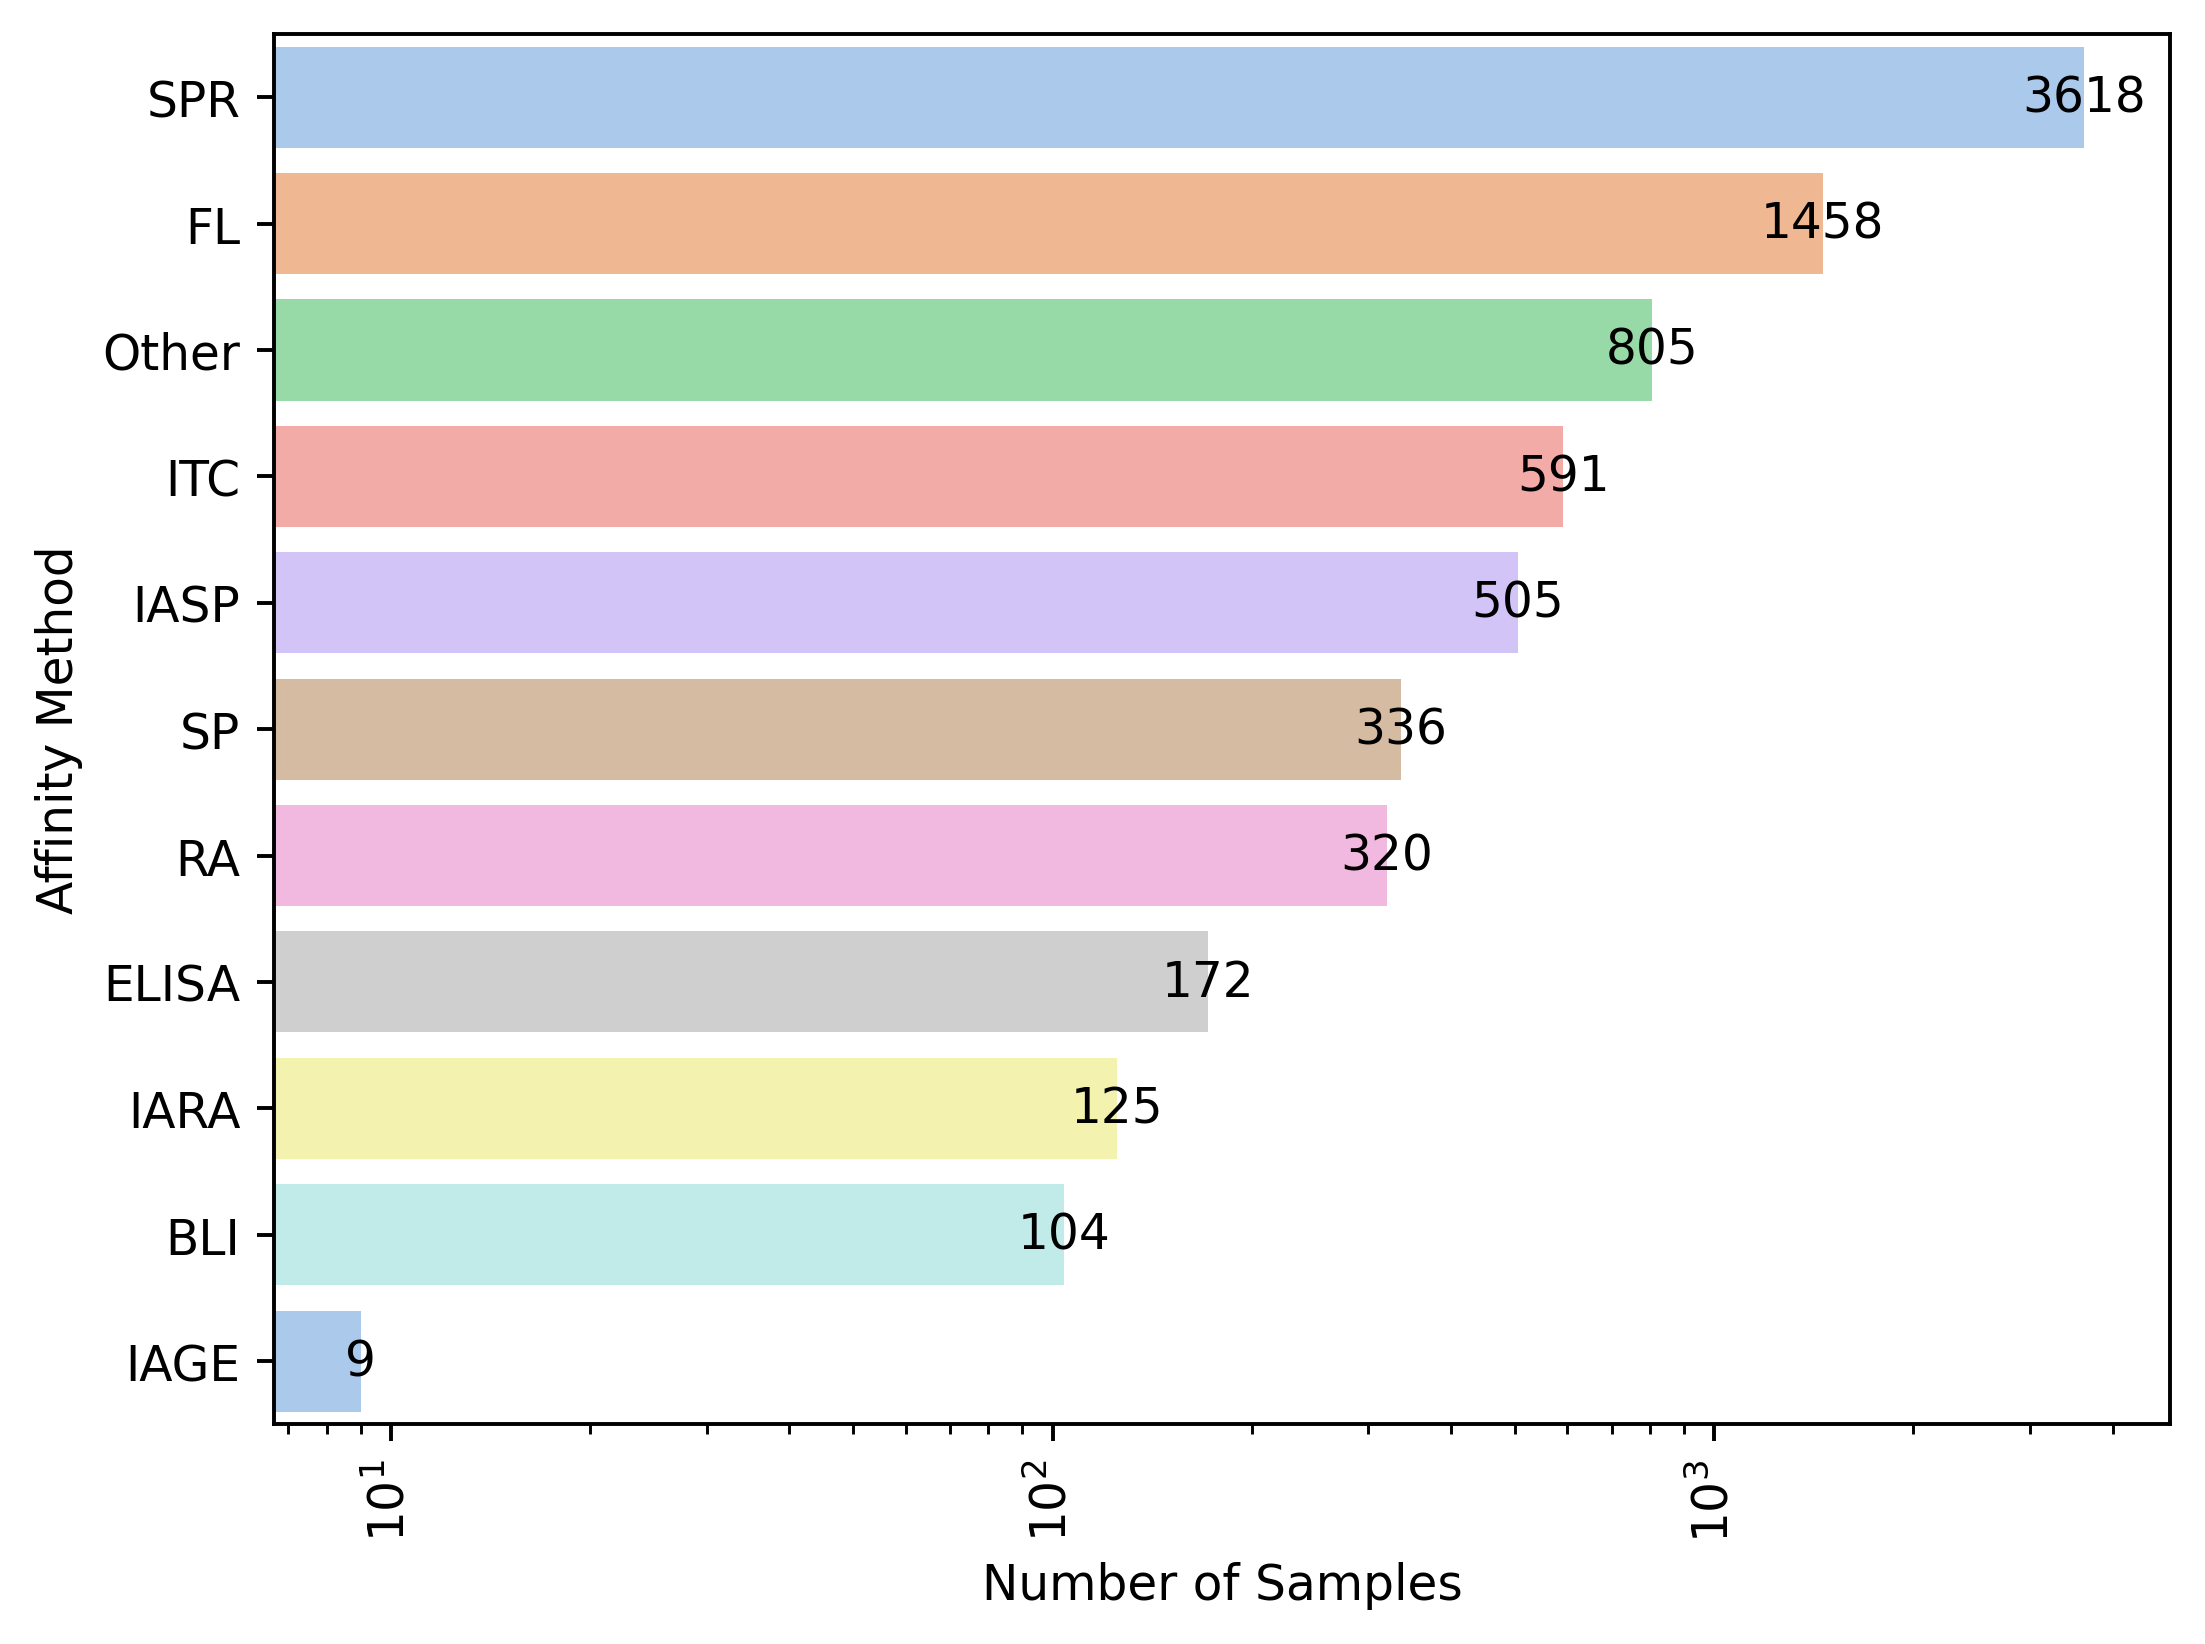

In [23]:
# 除去Unknown后，剩余部分样本的结构测定方法
value_counts = df_merge[df_merge["Affinity Method"]!='Unknown']["Affinity Method"].value_counts()
df_tmp = pd.DataFrame(value_counts).reset_index()#.rename(columns={'index':'Affinity Method', 'Affinity Method':'count'})

plt.figure(dpi=dpi)
palette = sns.color_palette('pastel')
ax = sns.barplot(data=df_tmp, x="count", y="Affinity Method", palette=palette, hue="Affinity Method")
# 在每个柱子上方添加数值标签
for i, (key,value) in enumerate(dict(value_counts).items()):
    ax.text(x=value, y=i, s=str(value), ha='center', va='center')
plt.xlabel('Number of Samples')
plt.xscale("log")
# 设置x轴标签倾斜45度
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f"Distributions of Known Affinity Measurement Methods(bar).{suffix}"), dpi=dpi)
plt.show()

# PDB对应的样本（WT+突变体）体数量

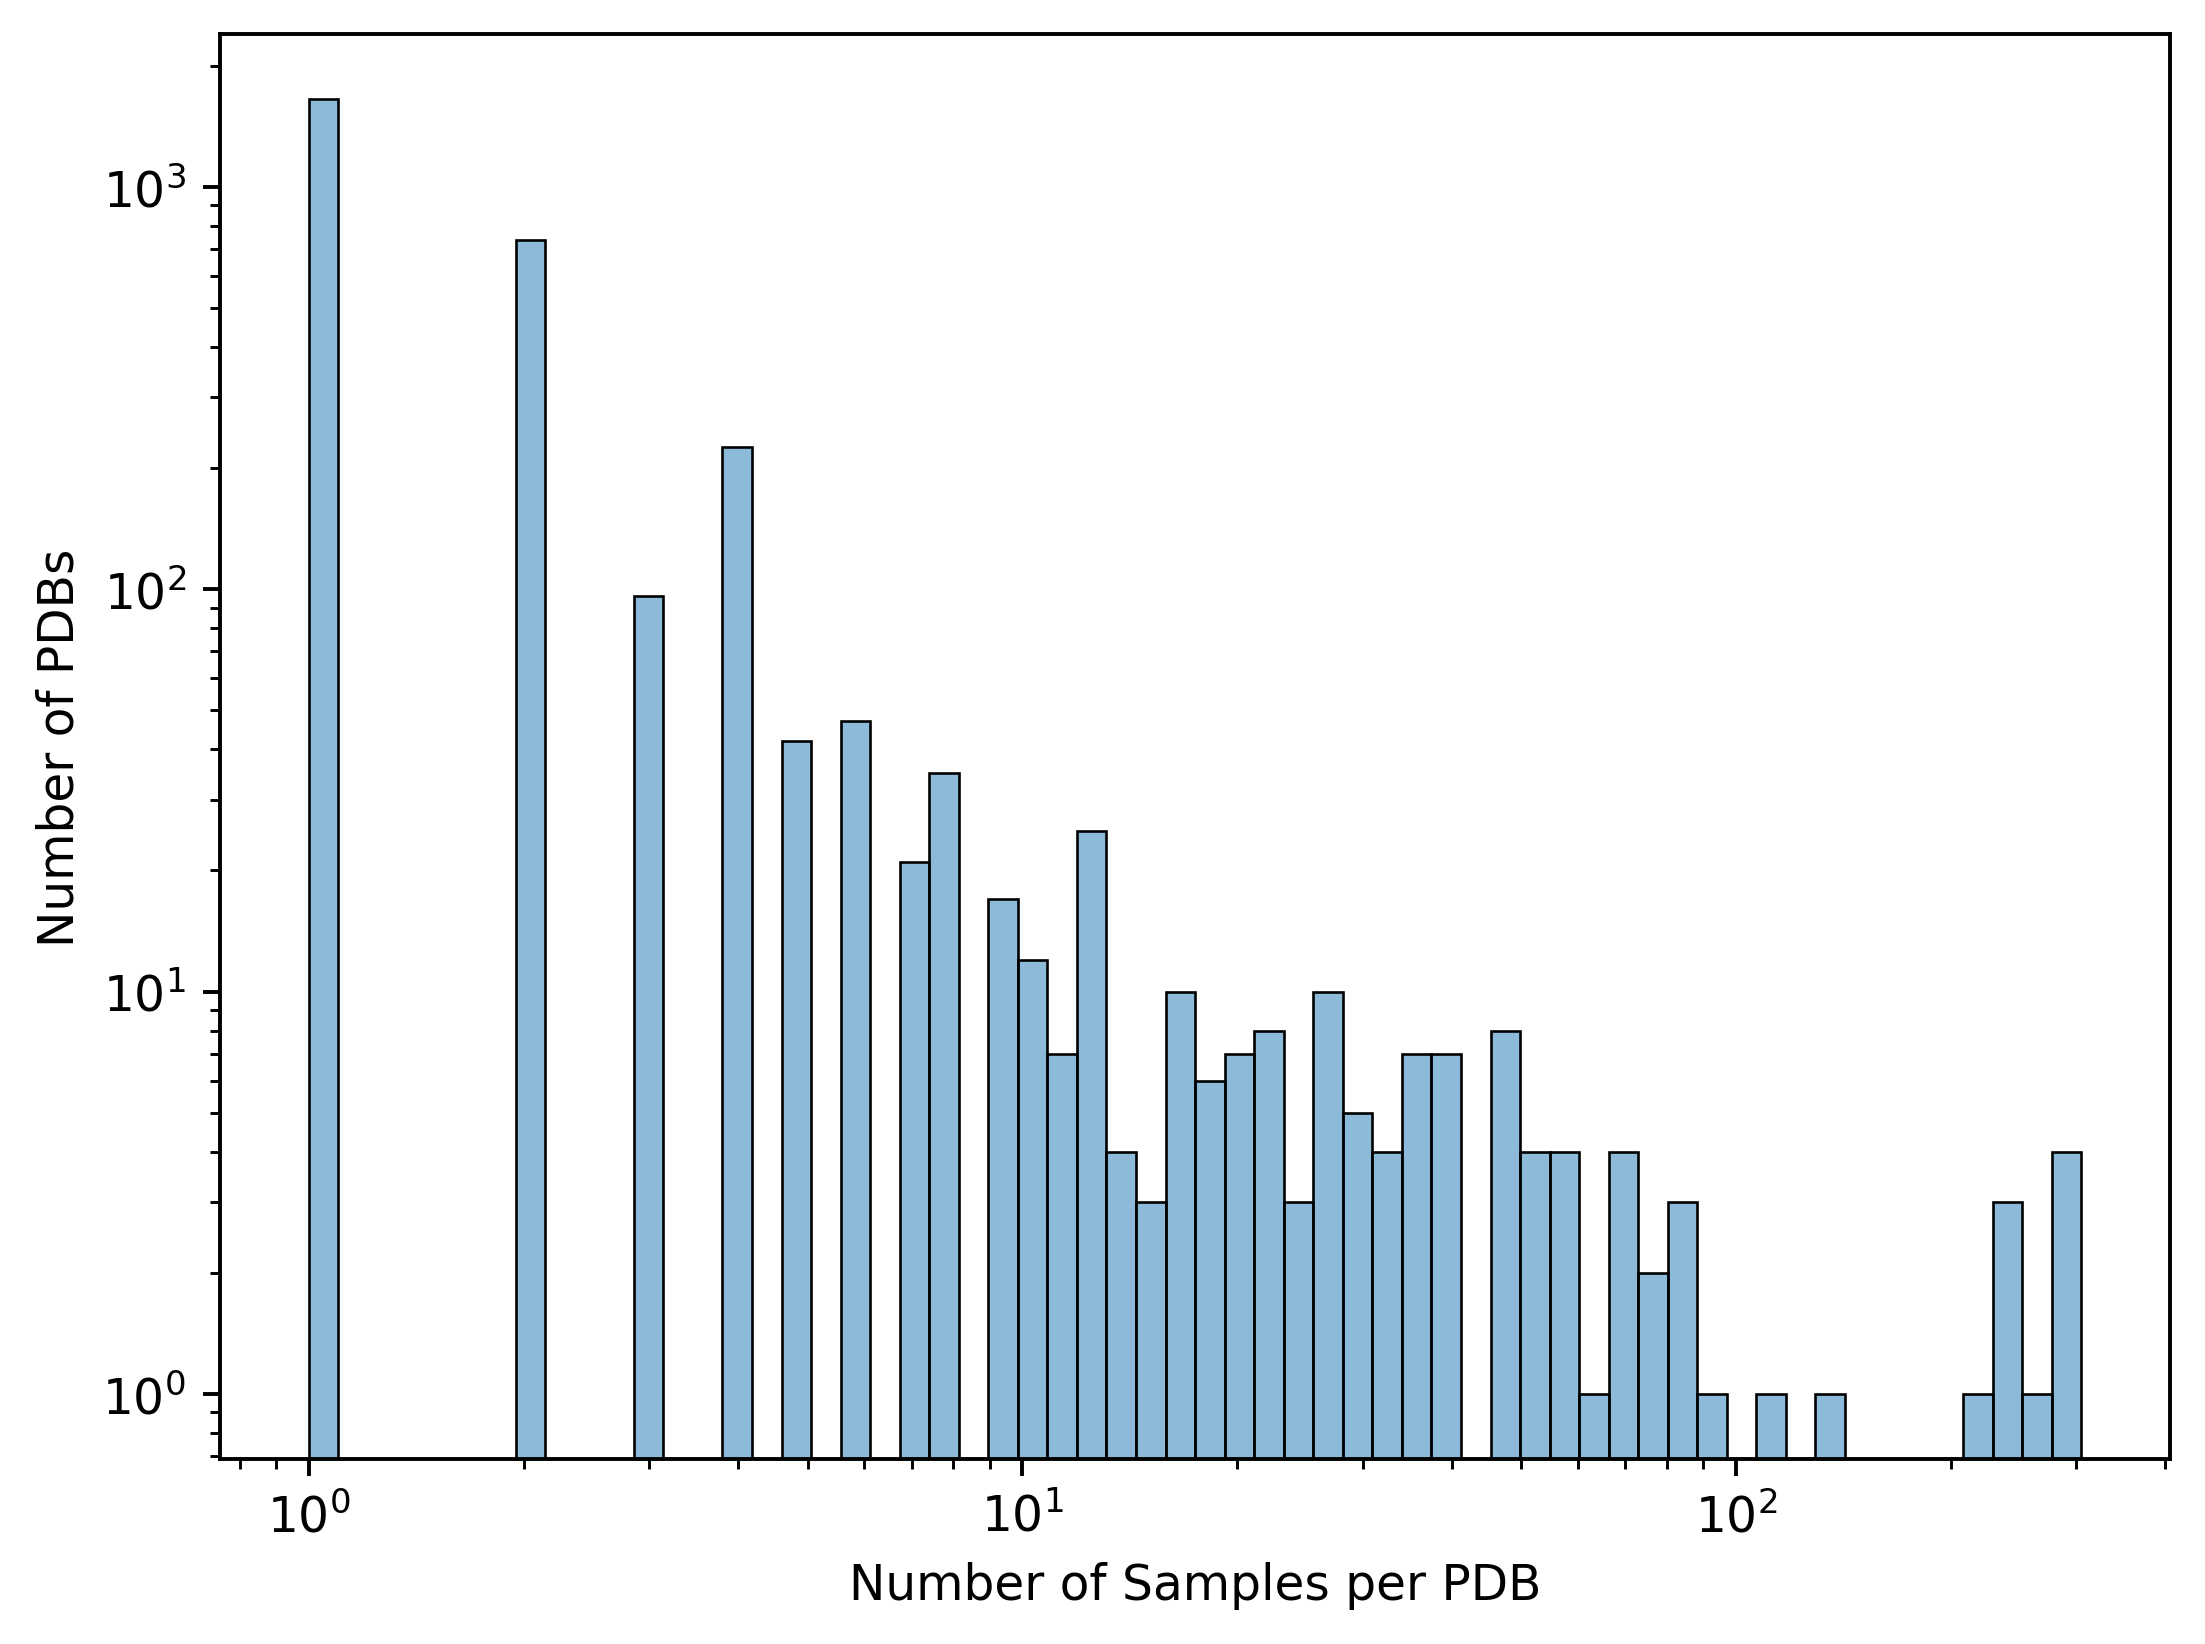

In [24]:
pdb_nb_sp = dict([(pdb,len(gp)) for pdb,gp in df_merge.groupby('PDB')])

plt.figure(dpi=dpi)
sns.histplot(pdb_nb_sp.values(), log_scale=True, legend=False)
plt.xlabel('Number of Samples per PDB')
plt.ylabel('Number of PDBs')
plt.yscale('log')
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f'Number of Samples Corresponding to Each PDB (Including Wild-Type and Mutants)(histograms).{suffix}'), dpi=dpi )
plt.show()

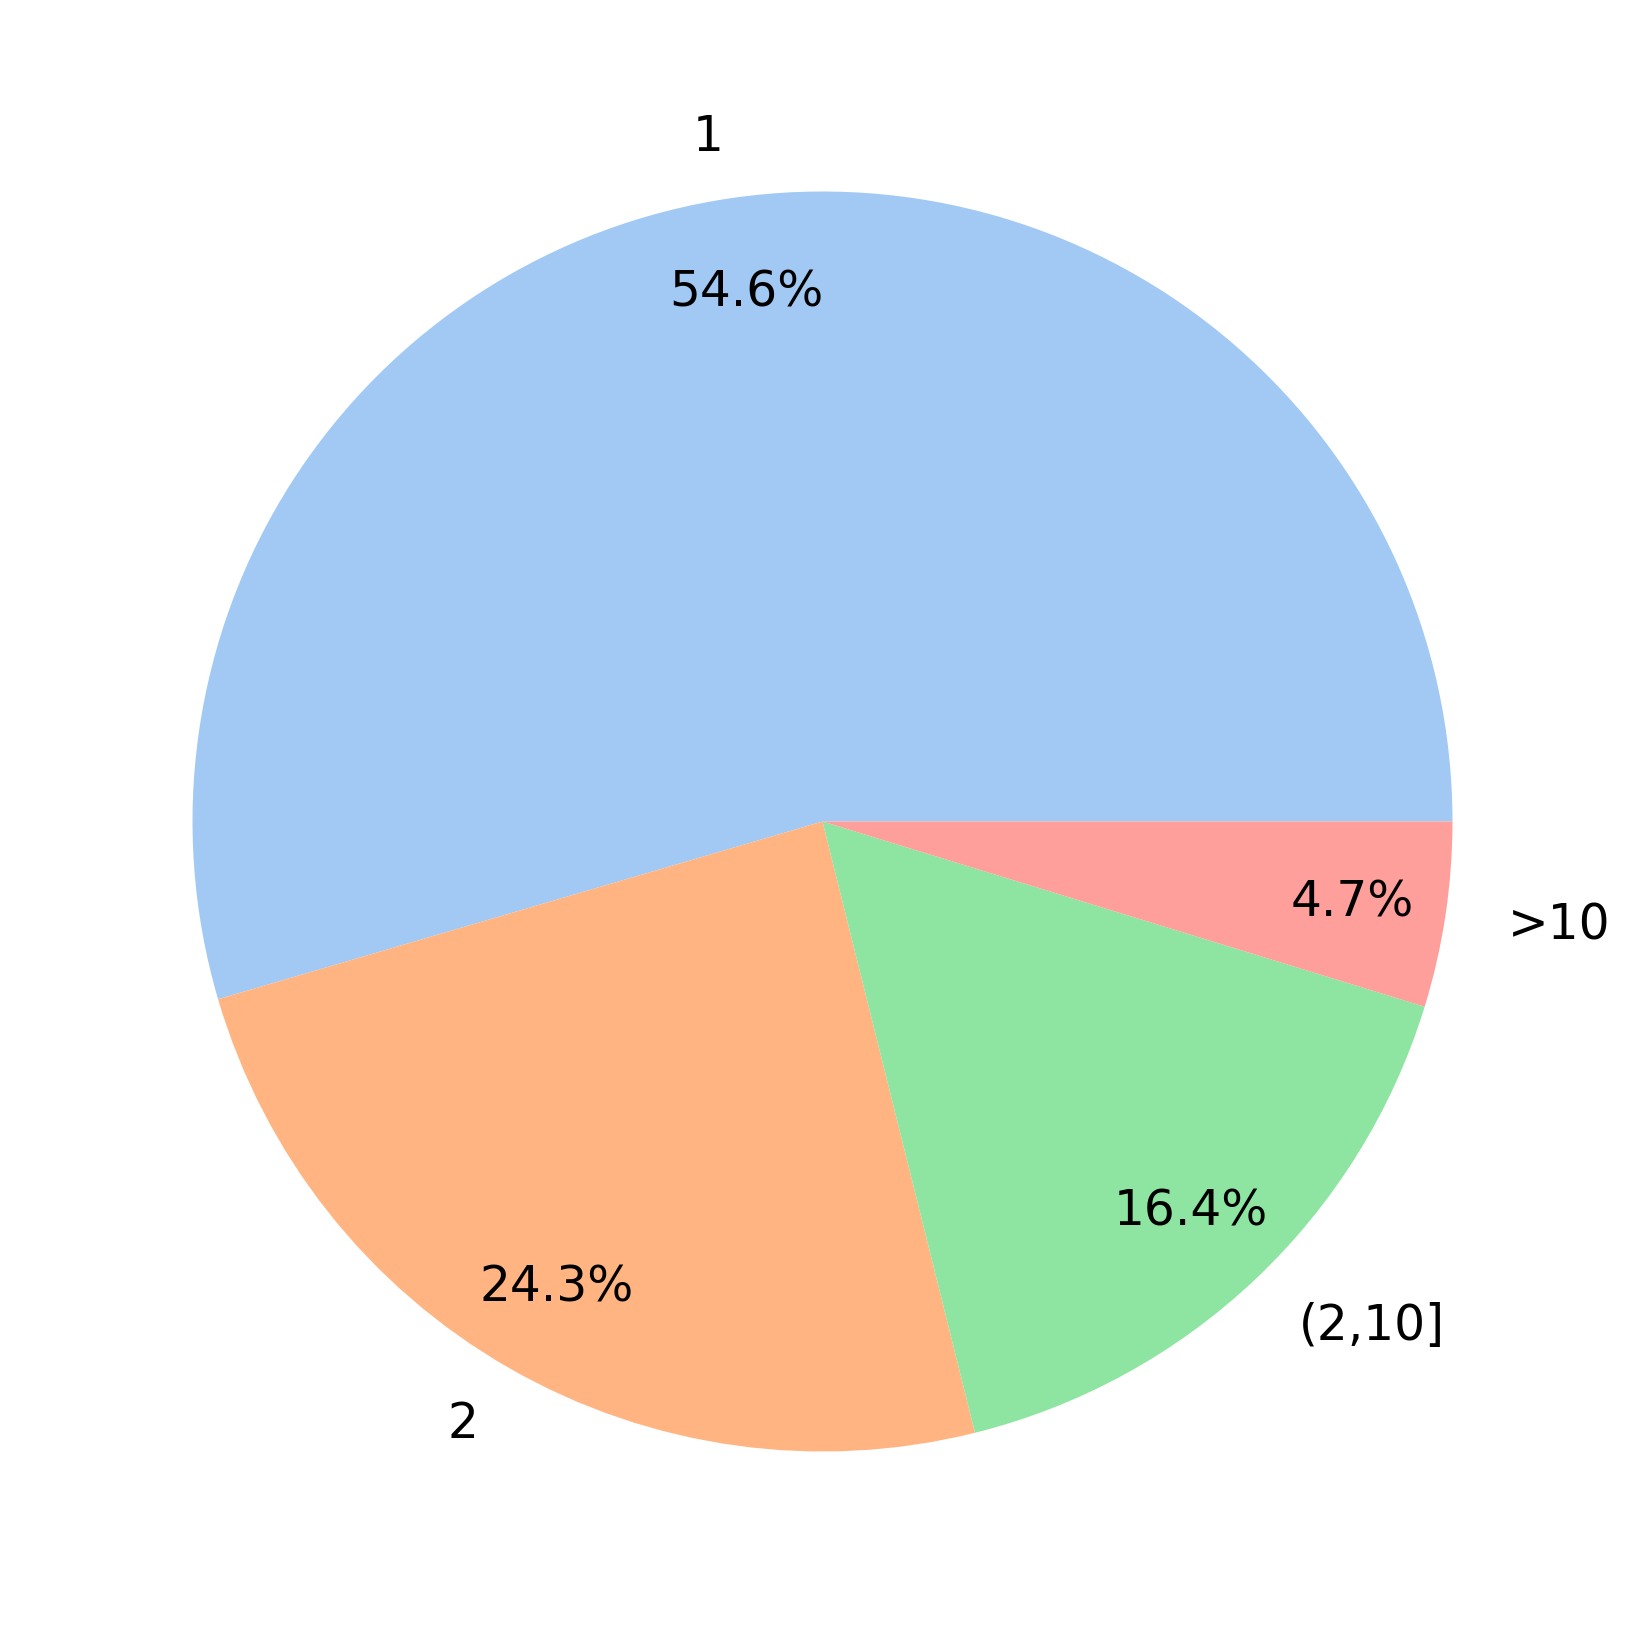

In [25]:
colors = sns.color_palette('pastel')#('viridis')#pastel

df_pdb_nb_sp = pd.DataFrame(pdb_nb_sp,index=[0]).T.rename(columns={0:'numbers'})
def bins_number(x):
    if x<=2:
        return x
    elif x>2 and x<=10:
        return '(2,10]'
    else:
        return '>10'
                
df_pdb_nb_sp['numbers'] = df_pdb_nb_sp['numbers'].apply(bins_number)
value_counts = df_pdb_nb_sp['numbers'].value_counts()
x = value_counts.values
labels = value_counts.index

plt.figure(dpi=dpi)
plt.pie(value_counts, colors=colors, labels=labels, autopct='%1.1f%%', pctdistance=0.85)
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f'Number of Samples Corresponding to Each PDB (Including Wild-Type and Mutants)(pie chart).{suffix}'), dpi=dpi )
plt.show()

# 亚组分析——抗体抗原亚组

SAbDab数据集的样本都是抗体抗原

In [26]:
from abnumber import Chain
from Bio import SeqUtils
from Bio.PDB import PDBParser, is_aa

def is_AntibodyAntigen(pdb_file, ligand_chains, receptor_chains):
    """
    检查一个pdb中的ligand_chains, receptor_chains是否抗体抗原复合物。只要其中一个是抗体即可。
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure('structure', pdb_file)
    
    flag = False
    for model in structure:
        for chain in model:
            chain_id = chain.get_id()
            if chain_id in ligand_chains + receptor_chains:
                amino_acids = [SeqUtils.seq1(residue.get_resname()) for residue in chain.get_residues() if residue.get_id()[0] == ' ']
                seq = ''.join(amino_acids)
                try:
                    chain = Chain(seq, scheme='chothia')
                    flag = True
                    return True
                except:
                    continue
    return flag


from joblib import Parallel, delayed

# 定义需要并行执行的函数
def process_data(gp):
    inds = gp.index.tolist()
    ind = inds[0]
    sourceDataSet = df_merge.loc[ind,'Source Data Set']
    
    #{'ATLAS', 'Affinity Benchmark v5.5', 'PDBbind v2020', 'SAbDab', 'SKEMPI v2.0'}
    if sourceDataSet=='SAbDab':
        # SAbDab都是
        return inds
    else:    
        # 非SAbDab，则判断：
        pdb = df_merge.loc[ind,'PDB']
        if sourceDataSet=='SKEMPI v2.0':
            pdb_file = f'./processed_data/PDB/SKEMPI v2.0/{pdb.upper()}.pdb'
        elif sourceDataSet=='Affinity Benchmark v5.5':
            pdb_file = f'./processed_data/PDB/Affinity Benchmark v5.5/{pdb.upper()}.pdb'
        elif sourceDataSet=='PDBbind v2020':
            pdb_file = f'./processed_data/PDB/PDBbind v2020/{pdb.lower()}.ent.pdb'
        elif sourceDataSet=='ATLAS':
            pdb_file = f'./processed_data/PDB/ATLAS/{pdb.upper()}.pdb'
        ligand_chains = [chain.strip() for chain in df_merge.loc[ind,'Ligand Chains'].split(',')]
        receptor_chains = [chain.strip() for chain in df_merge.loc[ind,'Receptor Chains'].split(',')]
        is_AbAg = is_AntibodyAntigen(pdb_file, ligand_chains, receptor_chains)
        if is_AbAg:
            return inds
        else:
            return []

# 使用joblib的Parallel和delayed实现并行循环
sel_inds = Parallel(n_jobs=-1)(delayed(process_data)(gp) for name, gp in 
                               tqdm.tqdm(df_merge.groupby(by=['PDB','Ligand Chains','Receptor Chains']),desc='Screening Antibody-Antigen complexes...'))
sel_inds = [item for sublist in sel_inds for item in sublist]
df_AbAg = df_merge.loc[sel_inds,:]
assert sum(df_AbAg['Source Data Set']=='ALTAS')==0, 'TCR-pMHC不应该是antibody-antigen复合物'
display(df_AbAg)

Screening Antibody-Antigen complexes...: 100%|██████████| 4801/4801 [02:16<00:00, 35.27it/s]


,PDB,Source Data Set,Model,Mutation(s)_cleaned,Mutation(s)_PDB,Ligand Chains,Receptor Chains,Ligand Name,Receptor Name,KD(M),...,Resolution(Å),PDB PubMed ID,PDB Release Date,Affinity PubMed ID,Affinity Release Date,Complex ID,Complex ID PDB,Complex ID cleaned,Mutations,dG(kcal/mol)
7383,1BJ1,SAbDab,0.0,NaN,NaN,"H, L",W,antibody,vascular endothelial growth factor,3.400000e-09,...,2.4,9753694,1999-01-13,9753694,1998-06-30,"1BJ1:H, L, W::PMID=9753694",NaN,NaN,NaN,-11.552512
7851,1BJ1,SAbDab,0.0,NaN,NaN,"J, K",V,antibody,vascular endothelial growth factor,3.400000e-09,...,2.4,9753694,1999-01-13,9753694,1998-06-30,"1BJ1:J, K, V::PMID=9753694",NaN,NaN,NaN,-11.552512
7627,1BVK,SAbDab,0.0,NaN,NaN,"A, B",C,antibody,lysozyme,1.400000e-08,...,2.7,9463398,1999-02-16,1560463,1998-09-16,"1BVK:A, B, C::PMID=1560463",NaN,NaN,NaN,-10.714025
7862,1BVK,SAbDab,0.0,NaN,NaN,"D, E",F,antibody,lysozyme,1.400000e-08,...,2.7,9463398,1999-02-16,1560463,1998-09-16,"1BVK:D, E, F::PMID=1560463",NaN,NaN,NaN,-10.714025
8116,1CZ8,SAbDab,0.0,NaN,NaN,"H, L",W,antibody,vascular endothelial growth factor,1.100000e-10,...,2.4,10543973,2000-03-20,10543973,1999-09-01,"1CZ8:H, L, W::PMID=10543973",NaN,NaN,NaN,-13.585244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12088,6MI2,PDBbind v2020,NaN,NaN,NaN,"A, B",C,utomilumab Fab,Tumor necrosis factor receptor superfamily mem...,6.900000e-08,...,2.72,30410017,2018-11-21,30410017,2018 Nov 8,"6MI2:A, B, C::PMID=30410017",NaN,NaN,NaN,-9.769035
7499,6MI2,SAbDab,0.0,NaN,NaN,"D, E",F,antibody,tumor necrosis factor receptor superfamily mem...,6.900000e-08,...,2.72,30410017,2018-11-21,TBD,2018-09-19,"6MI2:D, E, F::PMID=TBD",NaN,NaN,NaN,-9.769035
12089,6MI2,PDBbind v2020,NaN,NaN,NaN,"D, E",F,utomilumab Fab,Tumor necrosis factor receptor superfamily mem...,6.900000e-08,...,2.72,30410017,2018-11-21,30410017,2018 Nov 8,"6MI2:D, E, F::PMID=30410017",NaN,NaN,NaN,-9.769035
7890,6MLK,SAbDab,0.0,NaN,NaN,"H, L",A,antibody,"6-deoxyerythronolide-b synthase erya3, modules...",1.300000e-08,...,2.45,30289692,2018-10-17,TBD,2018-09-27,"6MLK:A, H, L::PMID=TBD",NaN,NaN,NaN,-10.757931


## 亲和力分布

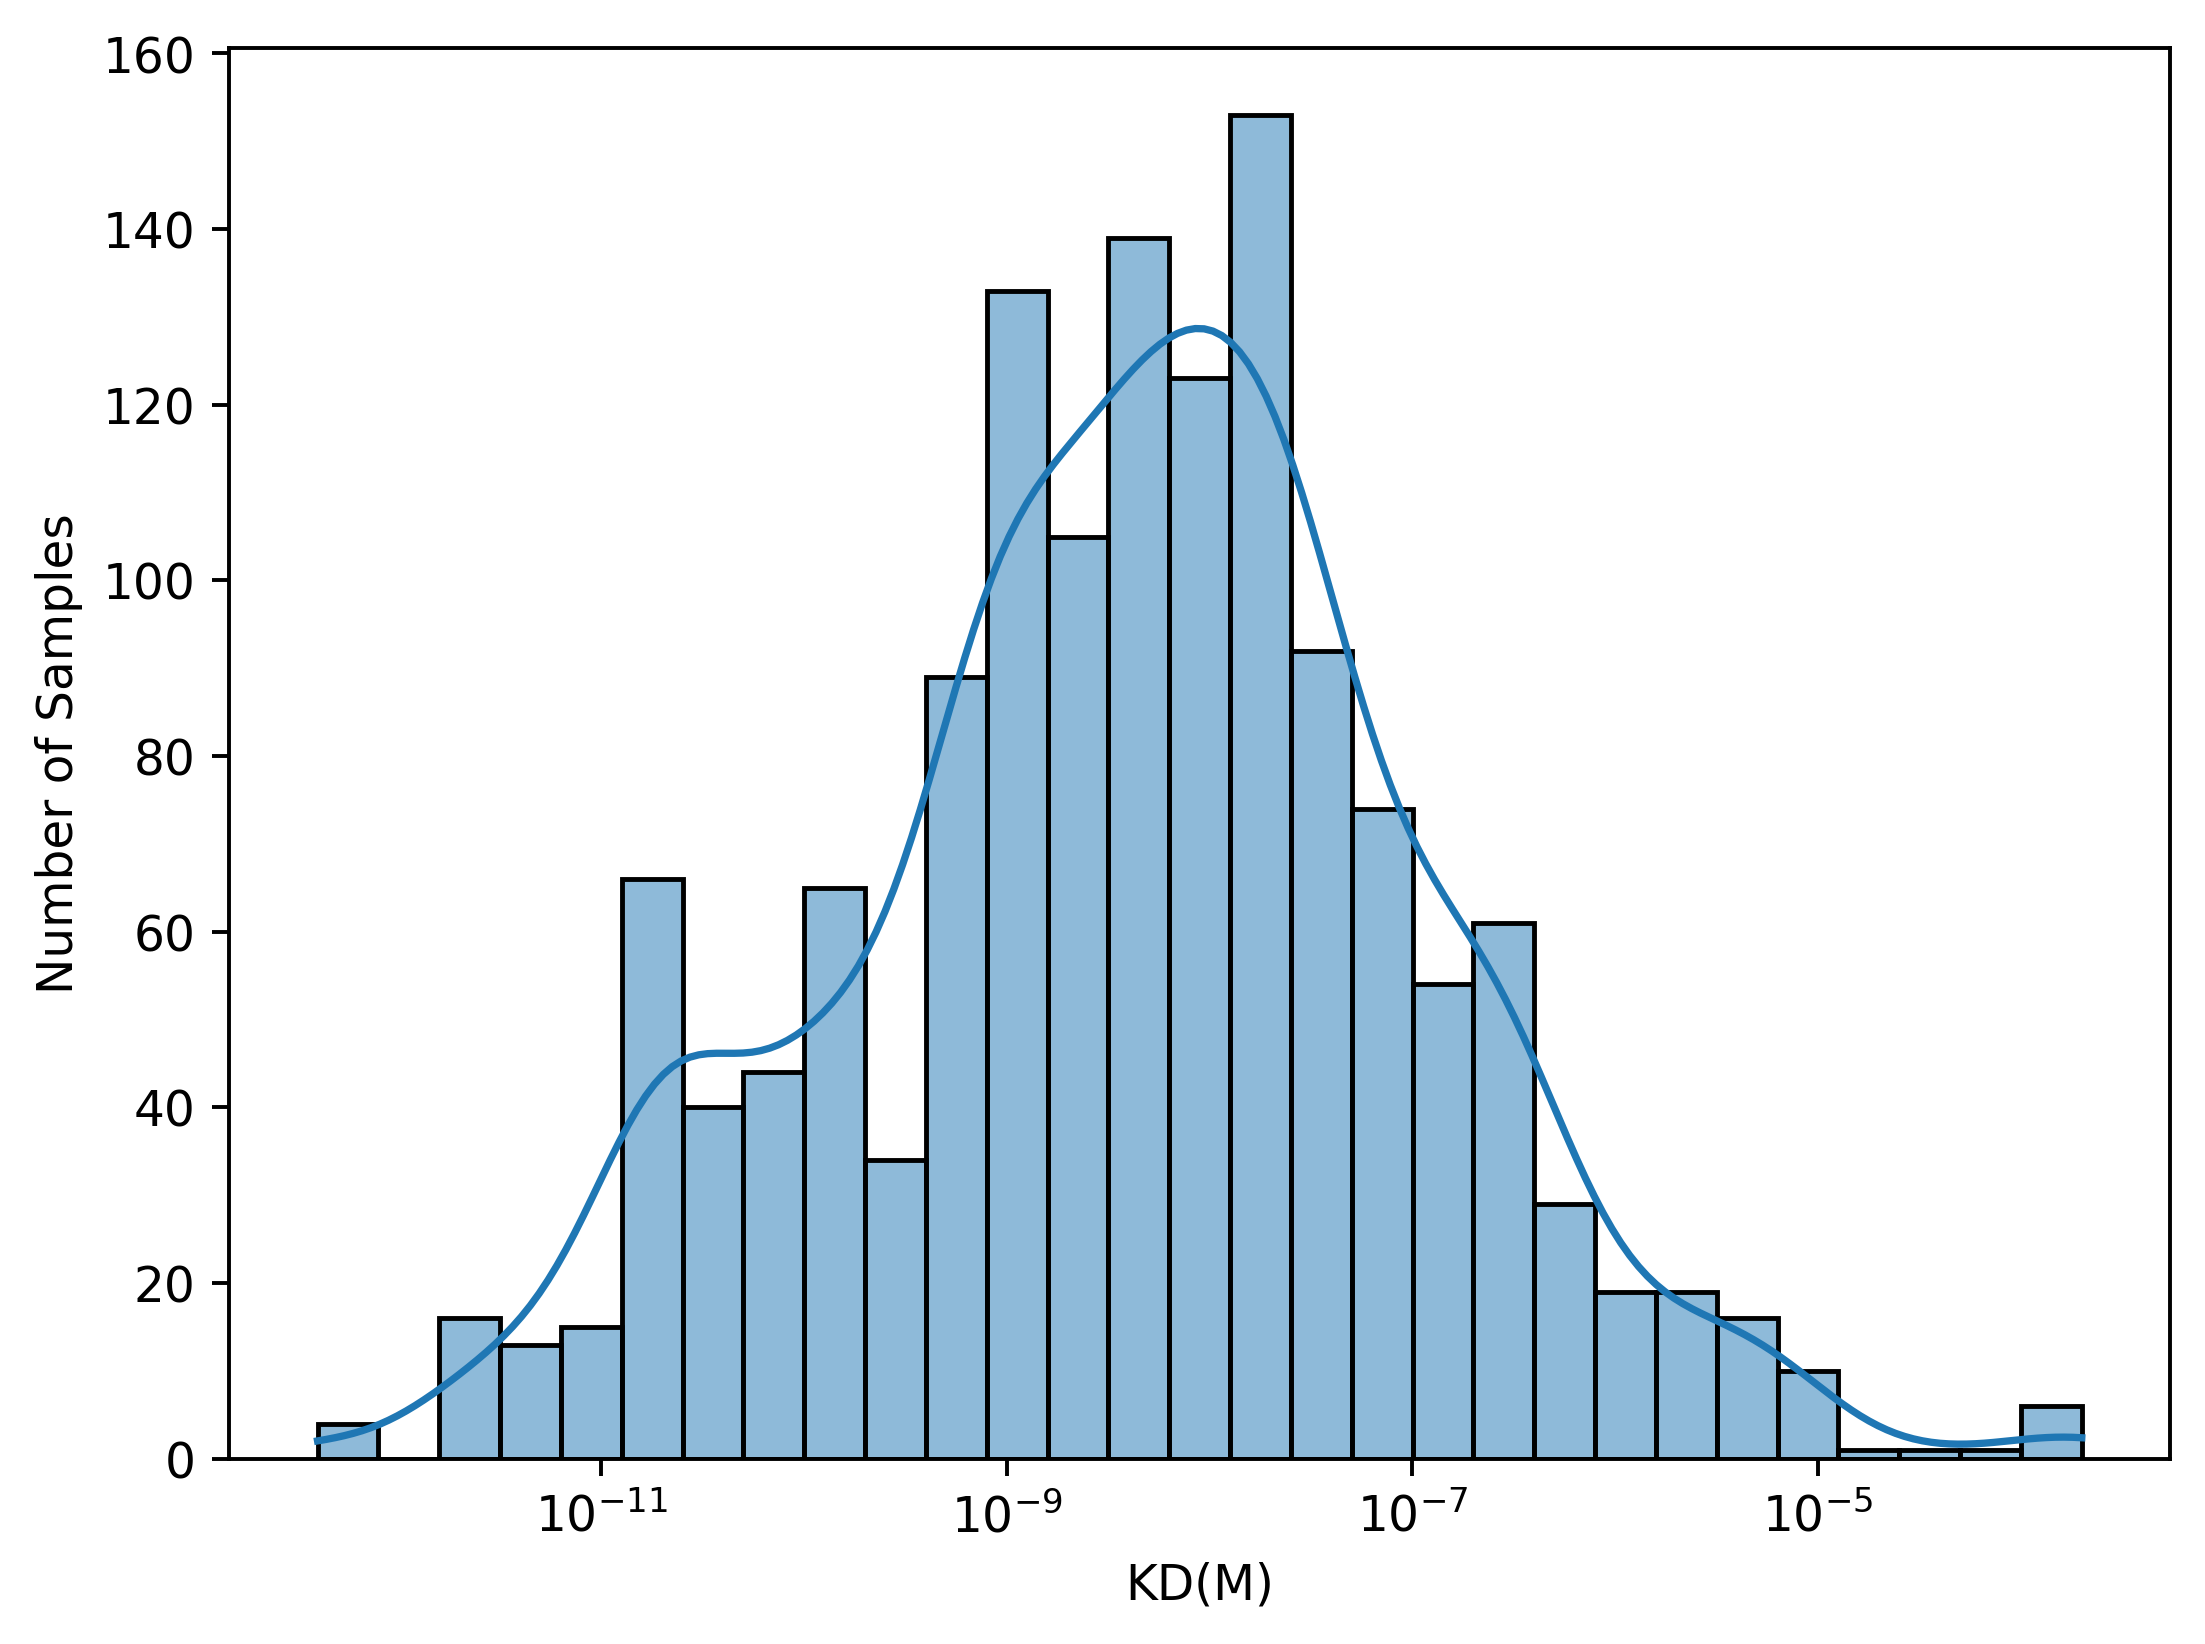

In [27]:
plt.figure(dpi=dpi)
sns.histplot(data=df_AbAg, x="KD(M)", kde=True, log_scale=True)
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.show()

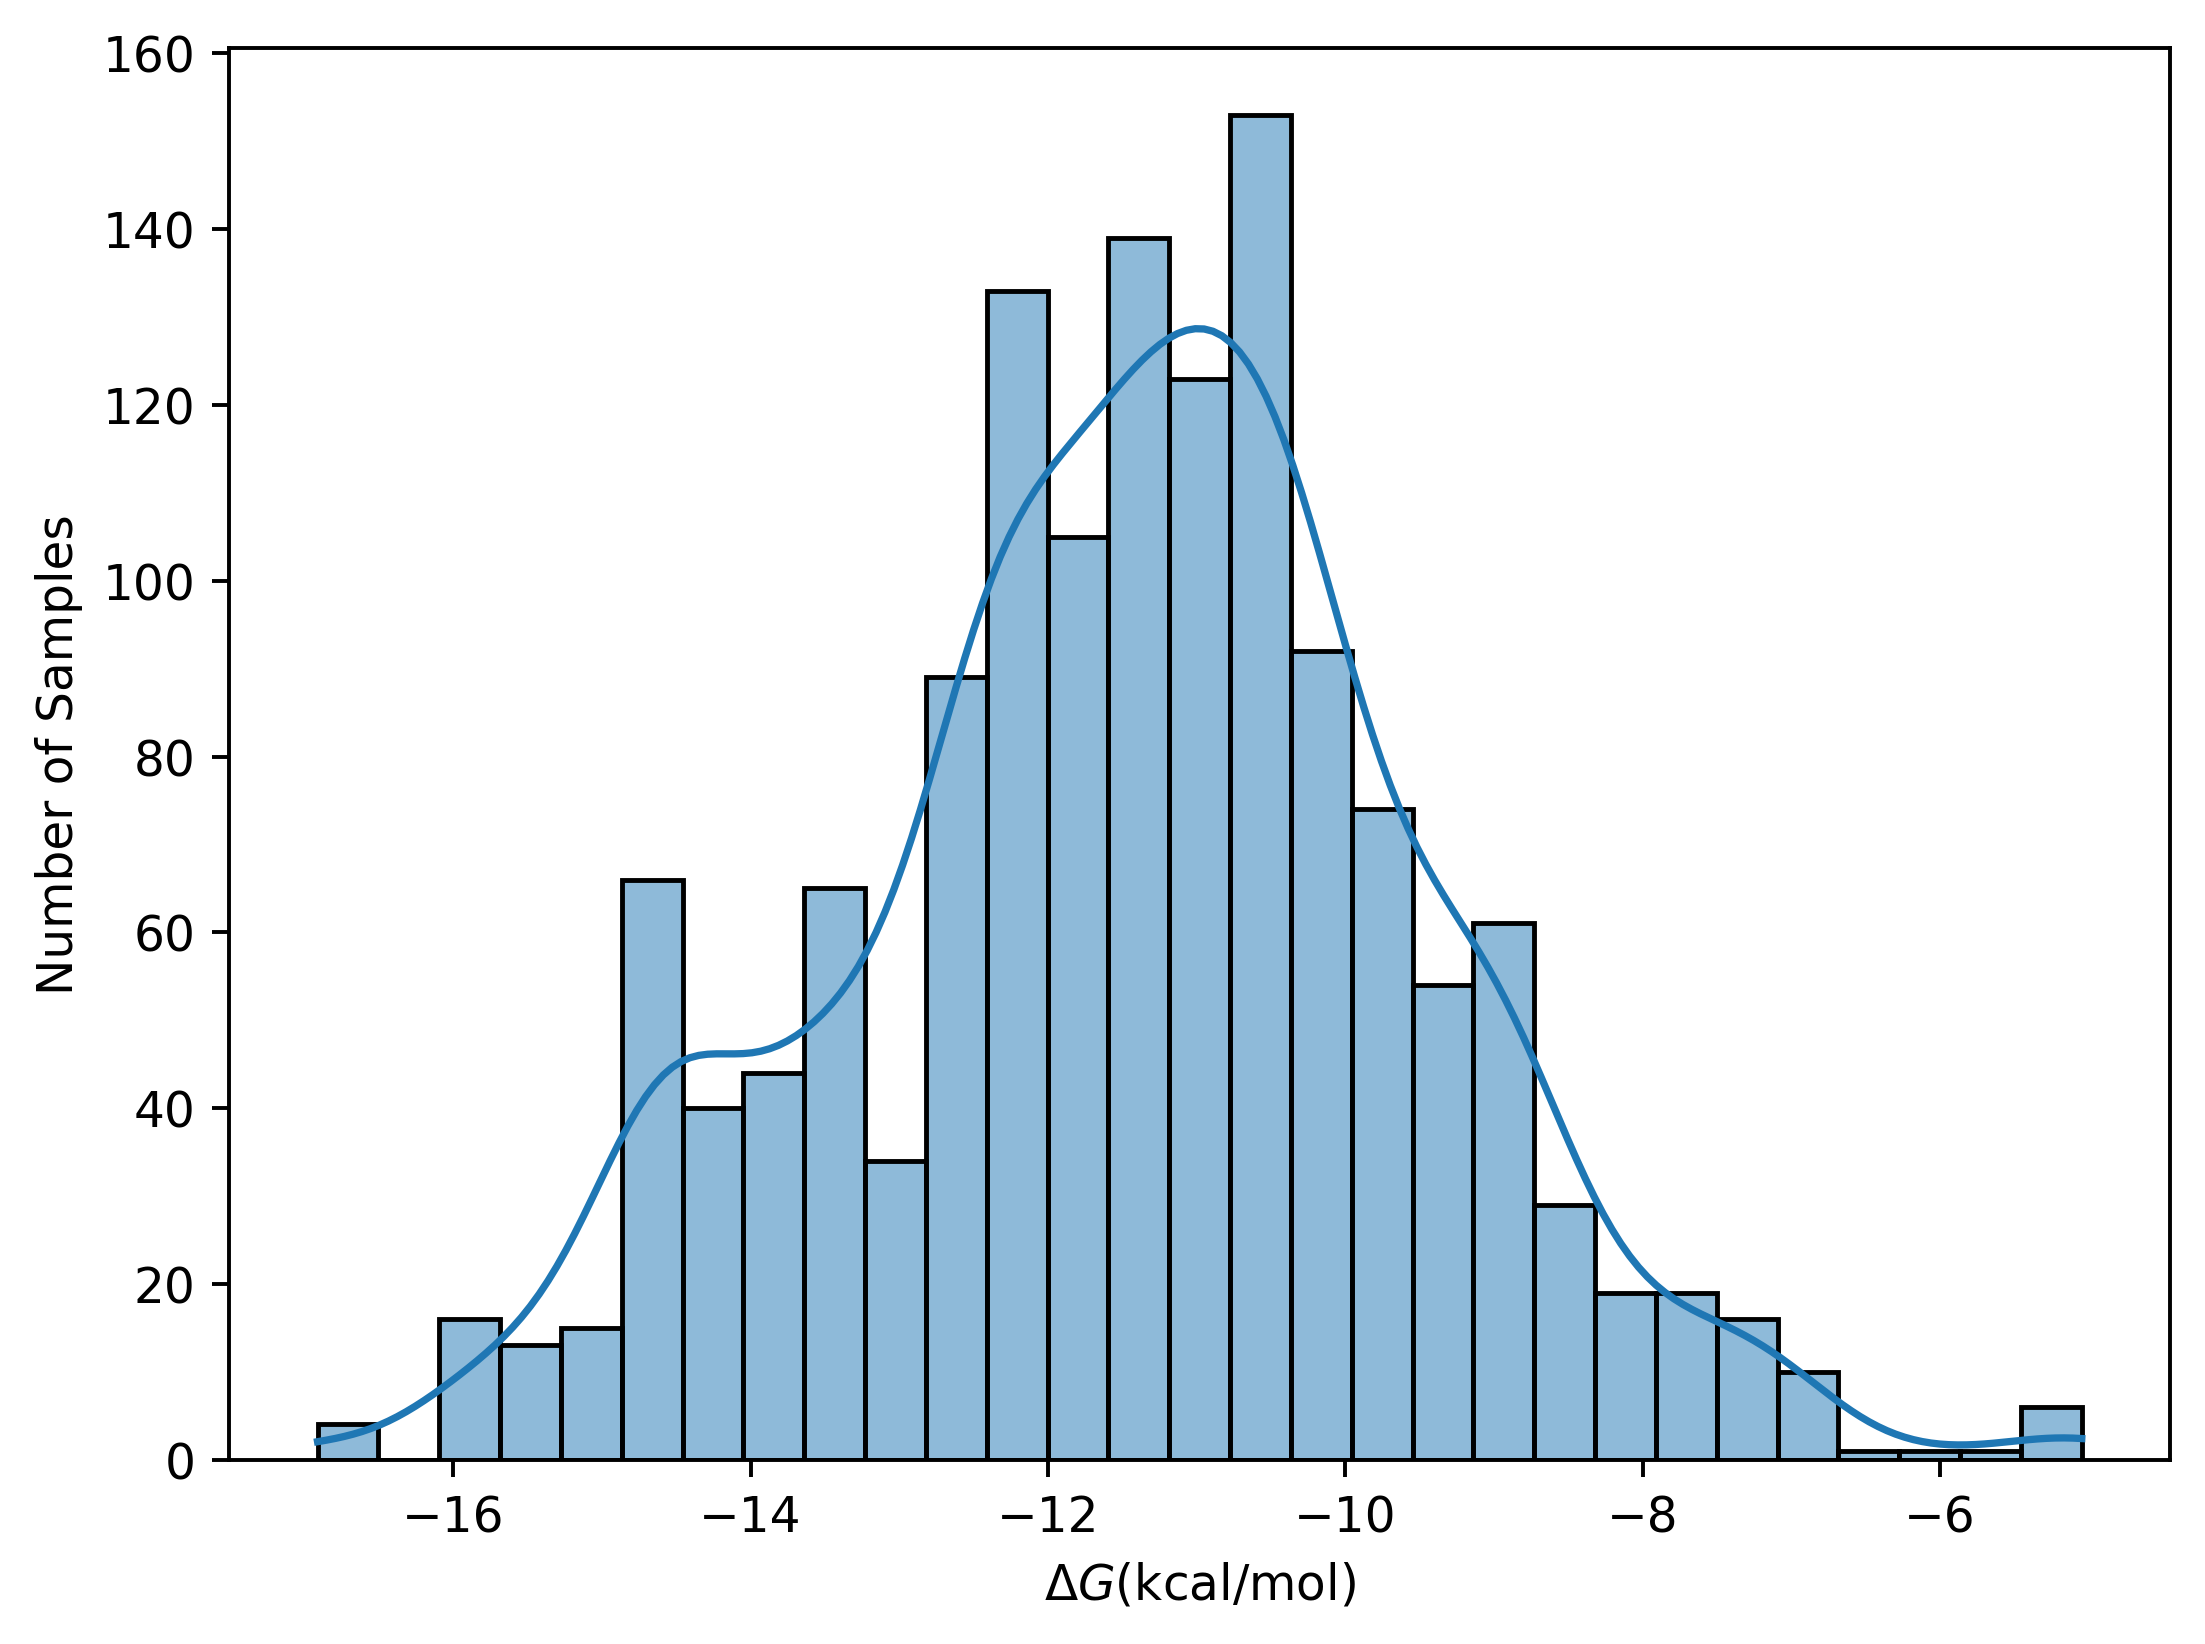

In [28]:
plt.figure(dpi=dpi)
sns.histplot(data=df_AbAg, x="dG(kcal/mol)", kde=True, log_scale=False)
plt.xlabel(r'$\Delta G$(kcal/mol)')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f'Affinity Distribution Among the Antibody-Antigen Subgroup(Total 2531 Samples).{suffix}'), dpi=dpi )
plt.show()

## 单个PDB对应的sample数量

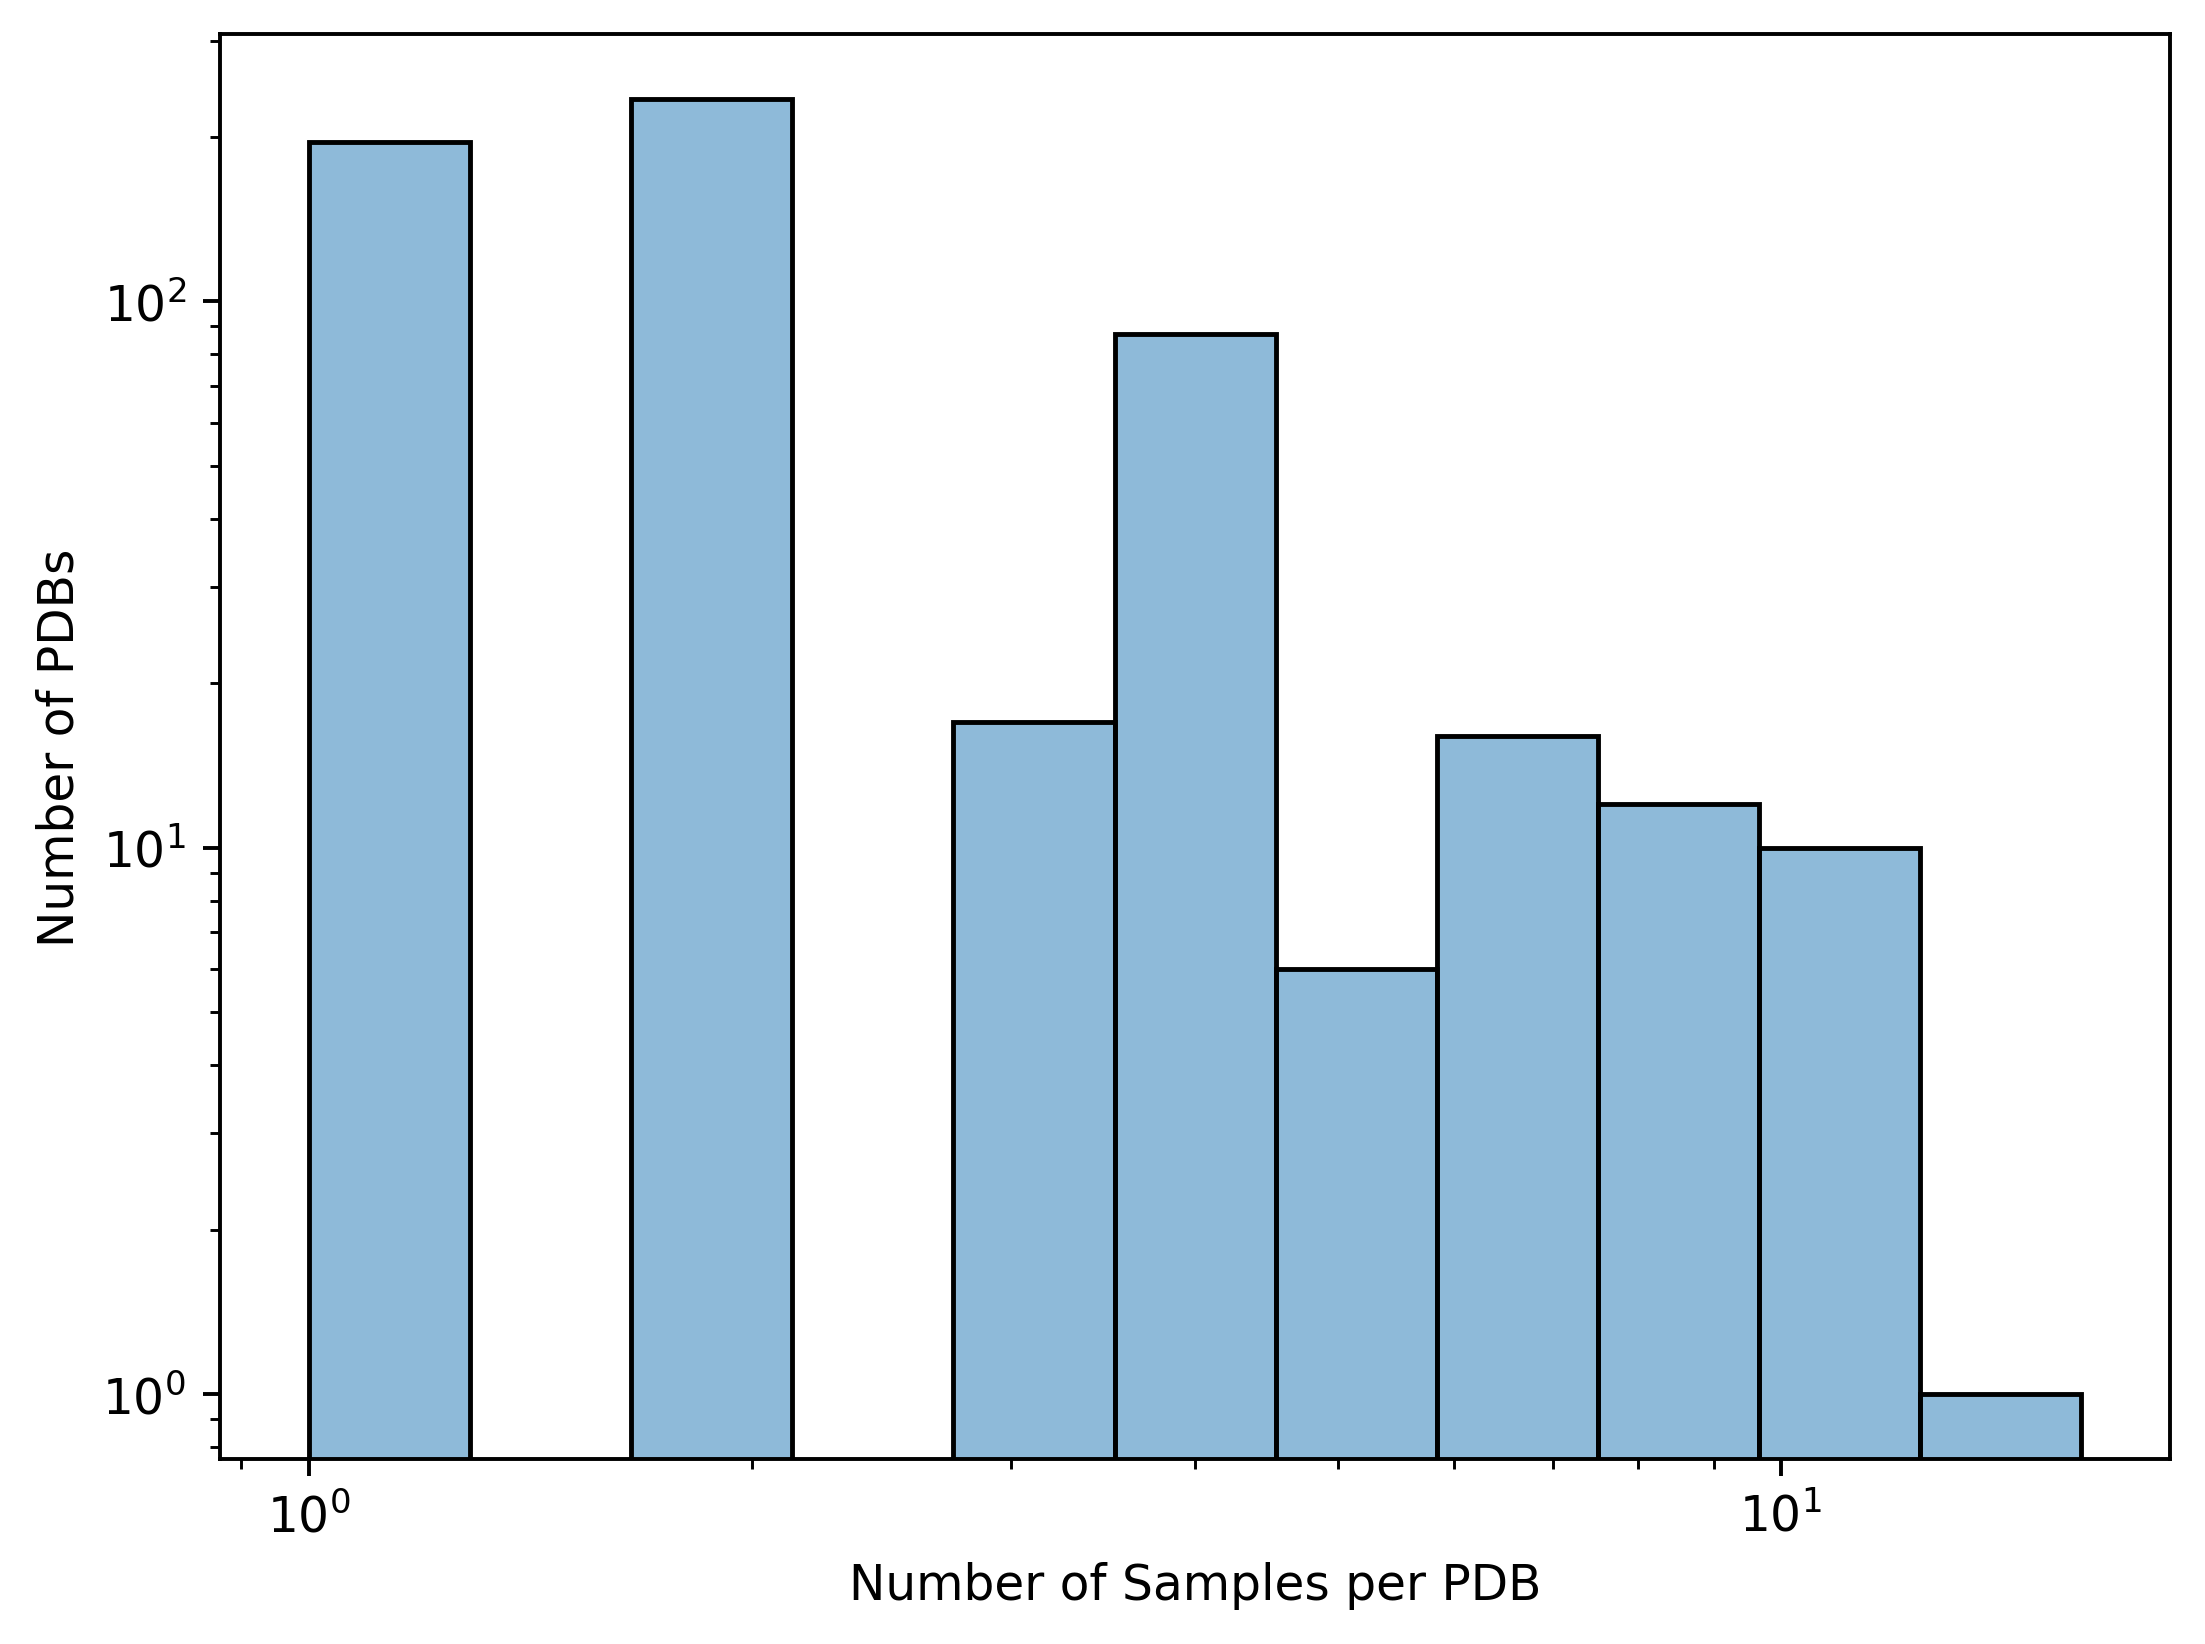

In [29]:
pdb_nb_sp = dict([(pdb,len(gp)) for pdb,gp in df_AbAg.groupby('PDB')])

plt.figure(dpi=dpi)
sns.histplot(pdb_nb_sp.values(), log_scale=True, legend=False)
plt.xlabel('Number of Samples per PDB')
plt.ylabel('Number of PDBs')
plt.yscale('log')
plt.tight_layout()
plt.show()

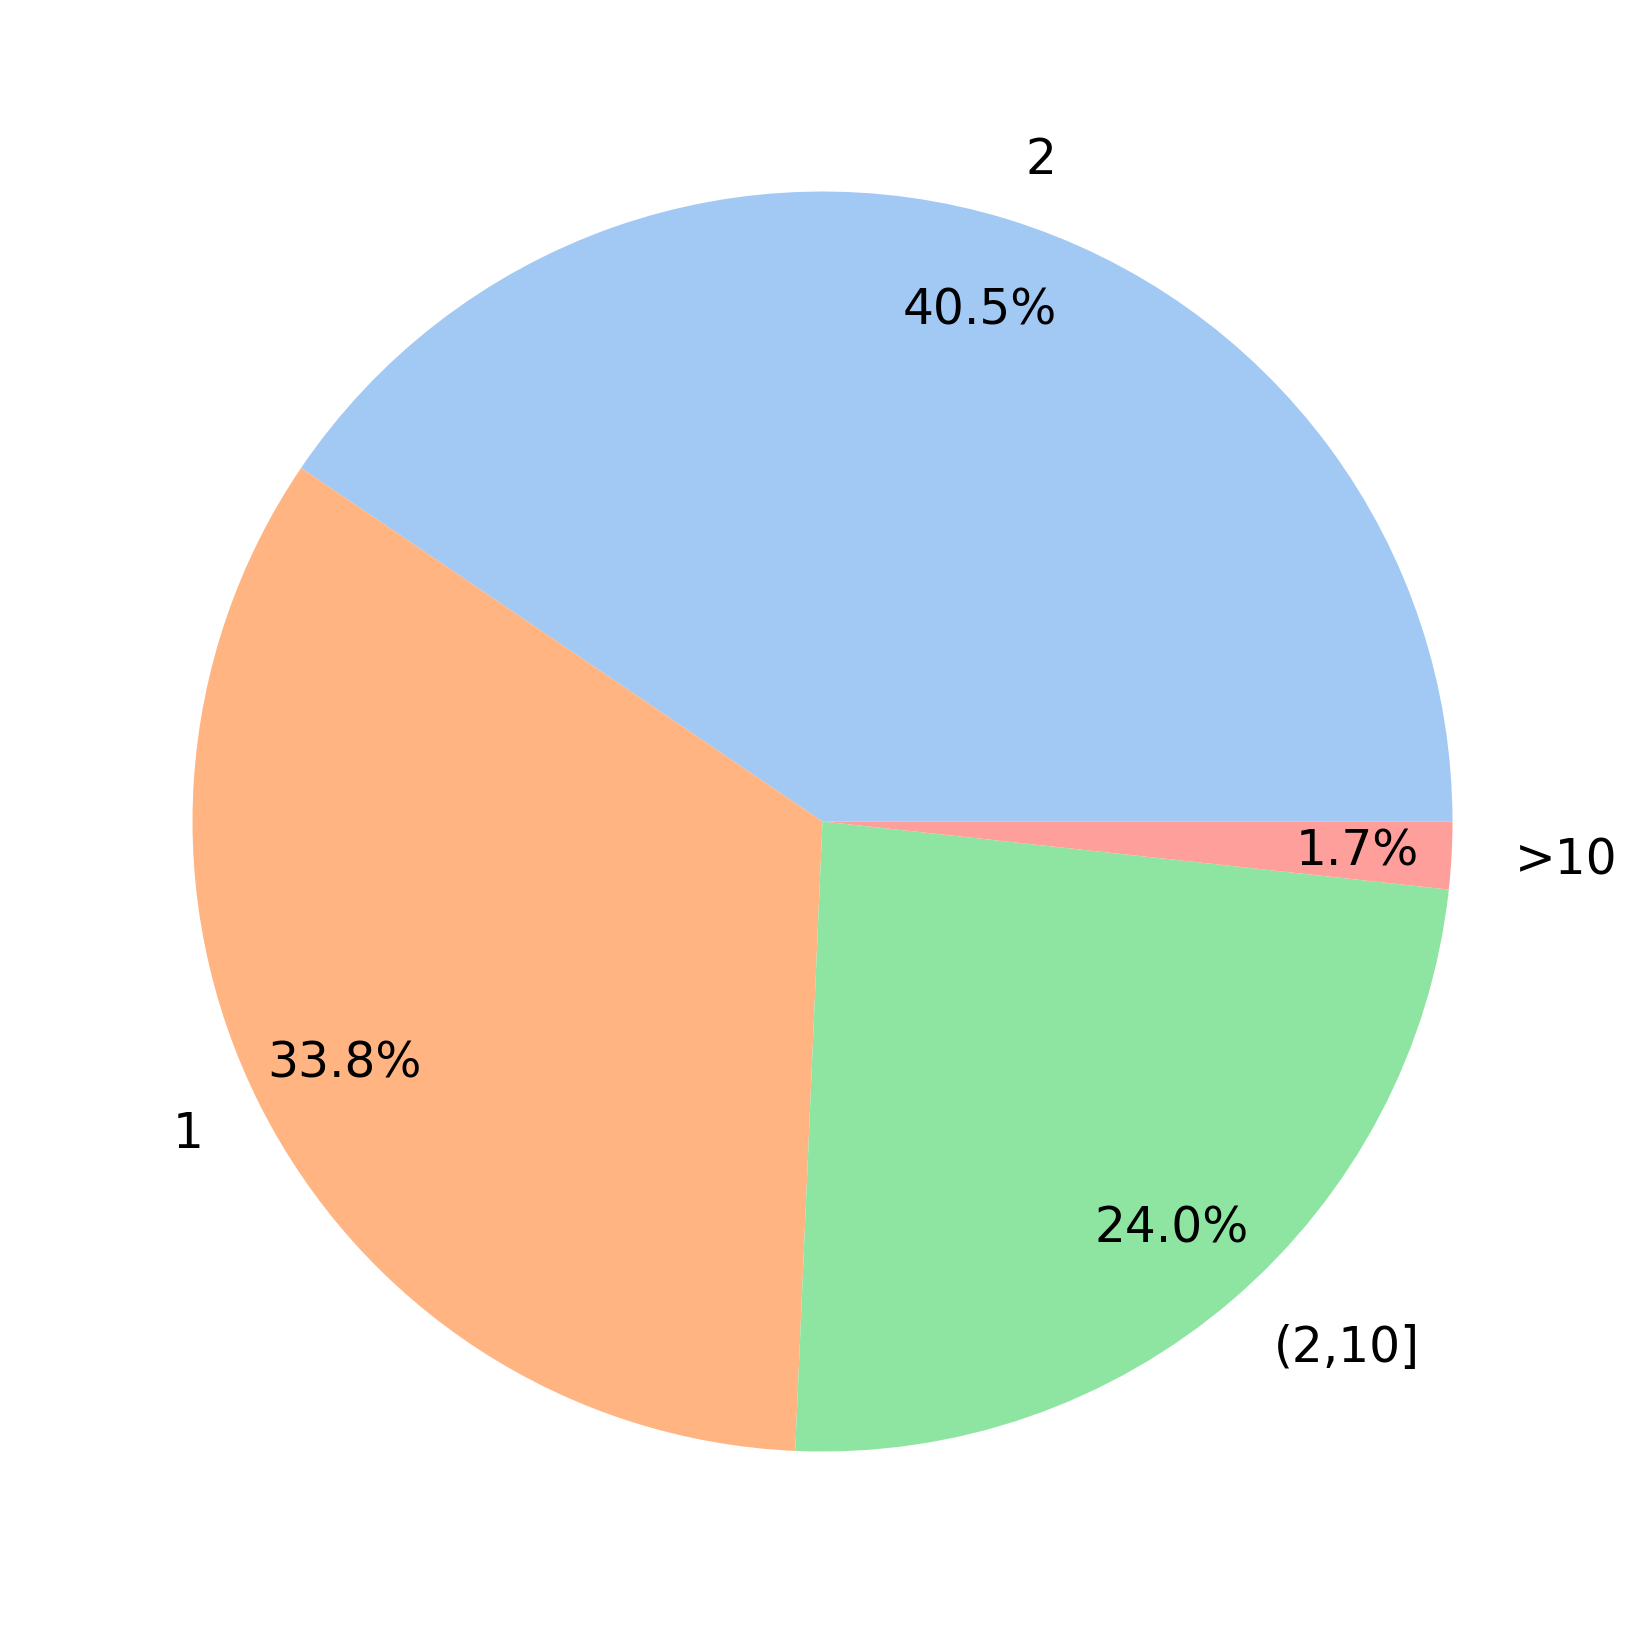

In [30]:
colors = sns.color_palette('pastel')#('viridis')#pastel

df_pdb_nb_sp = pd.DataFrame(pdb_nb_sp,index=[0]).T.rename(columns={0:'numbers'})
def bins_number(x):
    if x<=2:
        return x
    elif x>2 and x<=10:
        return '(2,10]'
    else:
        return '>10'
                
df_pdb_nb_sp['numbers'] = df_pdb_nb_sp['numbers'].apply(bins_number)
value_counts = df_pdb_nb_sp['numbers'].value_counts()
x = value_counts.values
labels = value_counts.index

plt.figure(dpi=350)
plt.pie(value_counts, colors=colors, labels=labels, autopct='%1.1f%%', pctdistance=0.85)
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f"Number of Samples Corresponding to Each PDB (Including Wild-Type and Mutants) of the Antibody-Antigen Subgroup(Total {len(set(df_AbAg['PDB']))} PDBs).{suffix}"), dpi=dpi )
plt.show()

# 亚组分析——TCR-pMHC亚组

ATLAS数据集的样本都是TCR-pMHC

In [31]:
def is_TCRpMHC(row):
    if row['Source Data Set']=='ATLAS':
        return True
    elif 'HLA' in str(row['Ligand Name']).upper() or 'HLA' in str(row['Receptor Name']).upper():
        return True
    elif 'TCR' in str(row['Ligand Name']).upper() or 'TCR' in str(row['Receptor Name']).upper():
        return True
    elif 'MHC' in str(row['Ligand Name']).upper() or 'MHC' in str(row['Receptor Name']).upper():
        return True
    elif 't-cell receptor' in str(row['Ligand Name']).lower() or 't-cell receptor' in str(row['Receptor Name']).lower():
        return True
    else:
        return False
    
TCRpMHC_inds = []
for ind in tqdm.tqdm(df_merge.index, desc='Screening TCR-pMHC complexes...'):
    row = df_merge.loc[ind,:]
    is_AbAg = is_TCRpMHC(row)
    if is_AbAg:
        TCRpMHC_inds.append(ind)
        
df_TCRpMHC = df_merge.loc[TCRpMHC_inds,:]
df_TCRpMHC

Screening TCR-pMHC complexes...: 100%|██████████| 12062/12062 [00:01<00:00, 9598.72it/s]


,PDB,Source Data Set,Model,Mutation(s)_cleaned,Mutation(s)_PDB,Ligand Chains,Receptor Chains,Ligand Name,Receptor Name,KD(M),...,Resolution(Å),PDB PubMed ID,PDB Release Date,Affinity PubMed ID,Affinity Release Date,Complex ID,Complex ID PDB,Complex ID cleaned,Mutations,dG(kcal/mol)
5,1AO7,SKEMPI v2.0,NaN,NaN,NaN,"A, B, C","D, E",HLA-A2 plus tax peptide,A6 TCR,3.640000e-06,...,2.6,8906788,1997-09-17,23736024,2013,"1AO7:A, B, C, D, E::PMID=23736024","1AO7:A, B, C, D, E::PMID=23736024","1AO7:A, B, C, D, E::PMID=23736024",NaN,-7.419588
10,1BD2,SKEMPI v2.0,NaN,NaN,NaN,"A, B, C","D, E",HLA-A2 plus tax peptide,B7 TCR,1.620000e-06,...,2.5,9586631,1998-08-19,23736024,2013,"1BD2:A, B, C, D, E::PMID=23736024","1BD2:A, B, C, D, E::PMID=23736024","1BD2:A, B, C, D, E::PMID=23736024",NaN,-7.899212
62,1LP9,SKEMPI v2.0,NaN,NaN,NaN,"A, B, C","E, F",HLA-A2 plus P1049 peptide,AHIII TCR,9.300000e-06,...,2.0,14563323,2003-11-11,17825839,2007 Oct 19,"1LP9:A, B, C, E, F::PMID=17825839","1LP9:A, B, C, E, F::PMID=17825839","1LP9:A, B, C, E, F::PMID=17825839",NaN,-6.863850
66,1MI5,SKEMPI v2.0,NaN,NaN,NaN,"A, B, C","D, E",HLA-B8 plus EB peptide,LC13 TCR,1.250000e-05,...,2.5,12530975,2003-02-04,15640805,2005 Feb,"1MI5:A, B, C, D, E::PMID=15640805","1MI5:A, B, C, D, E::PMID=15640805","1MI5:A, B, C, D, E::PMID=15640805",NaN,-6.688654
73,1OGA,SKEMPI v2.0,NaN,NaN,NaN,"A, B, C","D, E",HLA-A2 plus flu peptide,JM22 TCR,5.200000e-06,...,1.4,12796775,2003-06-19,18275829,2008 Feb,"1OGA:A, B, C, D, E::PMID=18275829","1OGA:A, B, C, D, E::PMID=18275829","1OGA:A, B, C, D, E::PMID=18275829",NaN,-7.208276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13039,4L3E,ATLAS,NaN,NaN,NaN,"A, C","D, E",ELAGIGILTV-HLA-A*02:01,DMF5,3.220000e-05,...,2.56,24550723,2014-06-11,23736024,2013-01-01,"4L3E:A, C, D, E:A_E166A:PMID=23736024",NaN,NaN,A_E166A,-6.128053
13040,4L3E,ATLAS,NaN,NaN,NaN,"A, C","D, E",ELAGIGILTV-HLA-A*02:01,DMF5,7.710000e-05,...,2.56,24550723,2014-06-11,23736024,2013-01-01,"4L3E:A, C, D, E:A_Q155A, D_Y50A:PMID=23736024",NaN,NaN,"A_Q155A, D_Y50A",-5.610762
13041,4L3E,ATLAS,NaN,NaN,NaN,"A, C","D, E",ELAGIGILTV-HLA-A*02:01,DMF5,2.610000e-05,...,2.56,24550723,2014-06-11,23736024,2013-01-01,"4L3E:A, C, D, E:A_E166A, D_N52A:PMID=23736024",NaN,NaN,"A_E166A, D_N52A",-6.252487
13042,4L3E,ATLAS,NaN,NaN,NaN,"A, C","D, E",ELAGIGILTV-HLA-A*02:01,DMF5,4.300000e-08,...,2.56,24550723,2014-06-11,22611242,2012-06-15,"4L3E:A, C, D, E:D_D26Y, E_L98W:PMID=22611242",NaN,NaN,"D_D26Y, E_L98W",-10.049209


## 亲和力分布

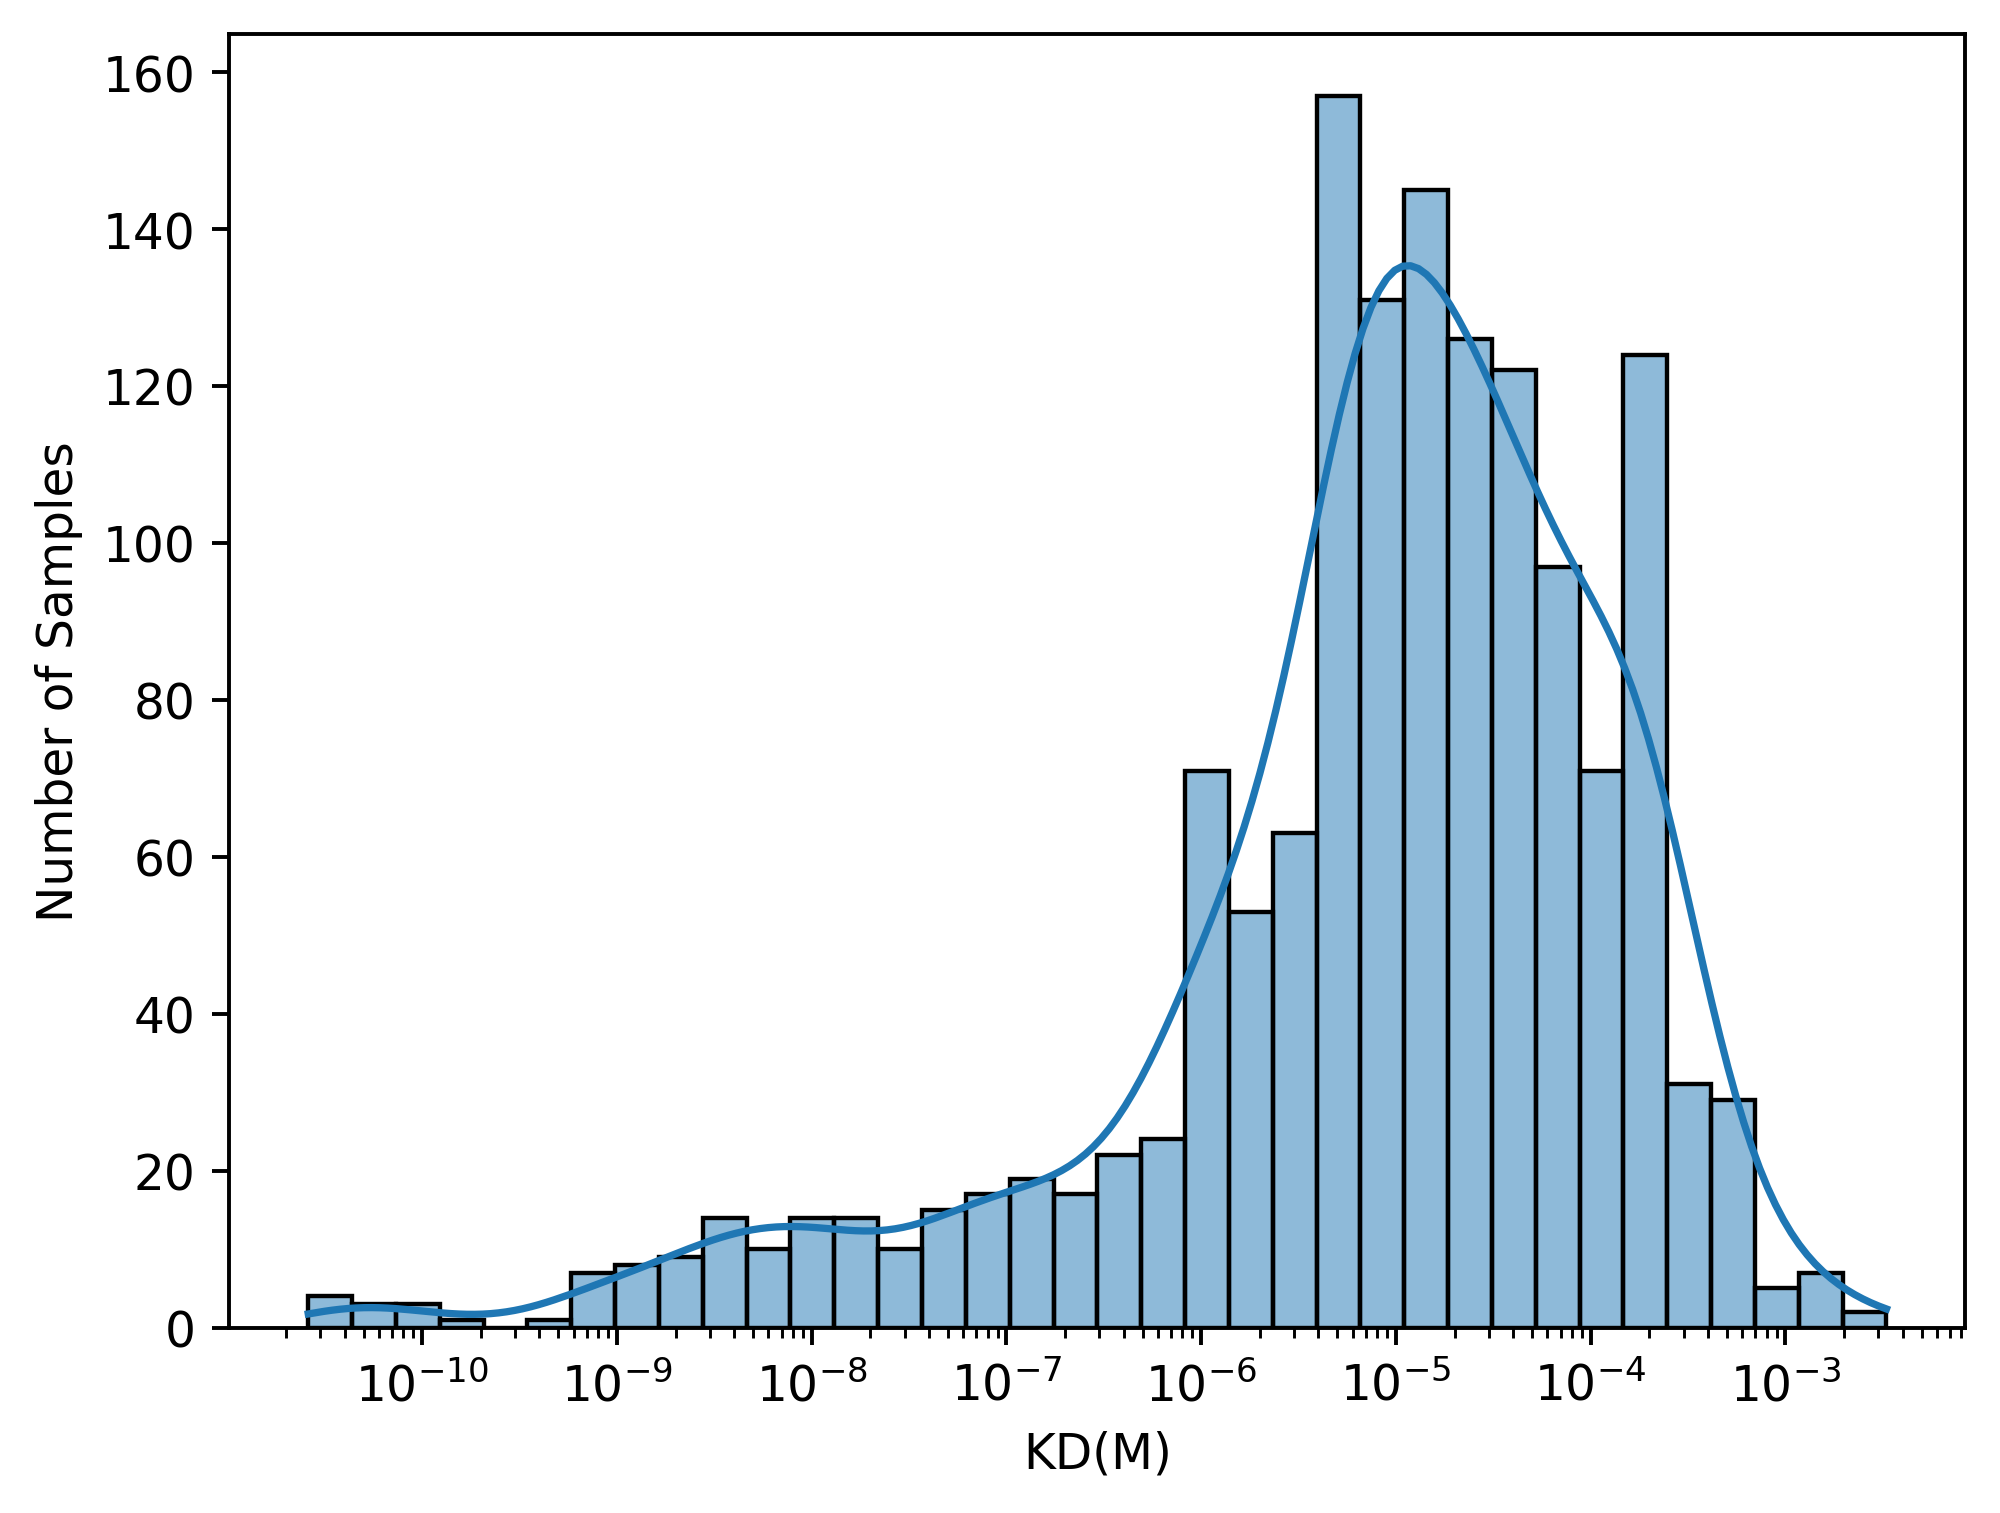

In [32]:
plt.figure(dpi=dpi)
plt.tight_layout()
sns.histplot(data=df_TCRpMHC, x="KD(M)", kde=True, log_scale=True)
plt.ylabel('Number of Samples')
plt.show()

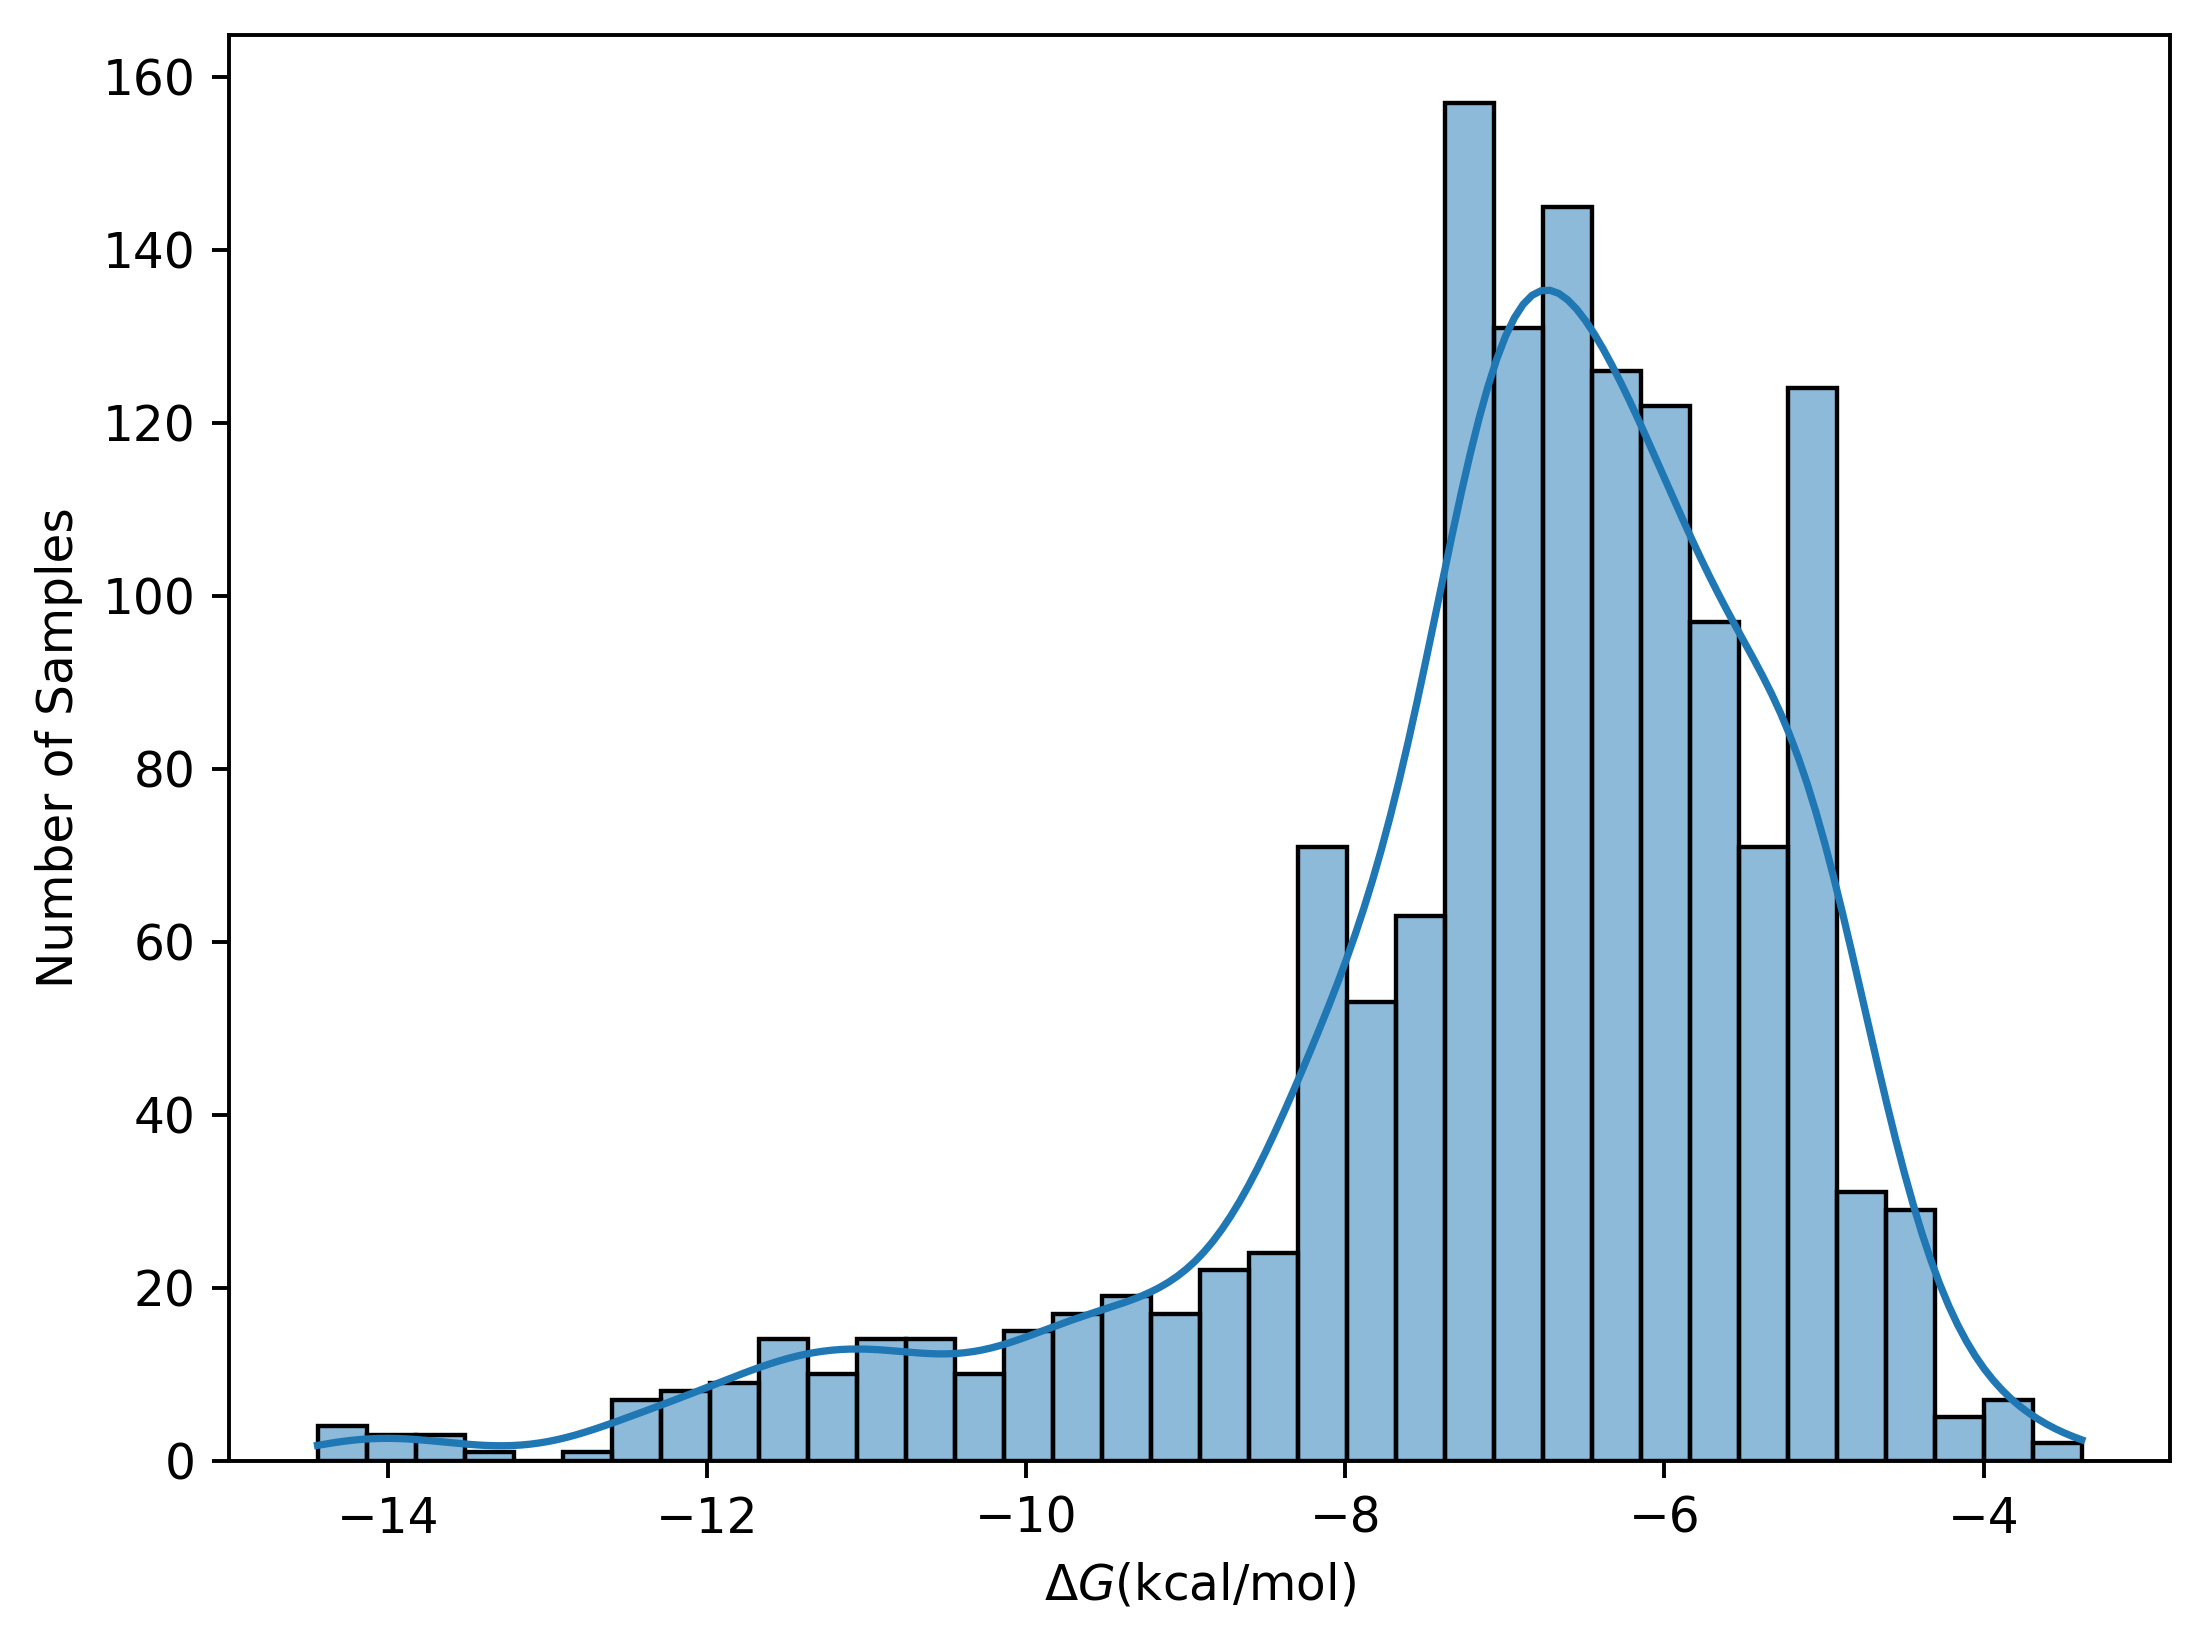

In [33]:
plt.figure(dpi=dpi)
sns.histplot(data=df_TCRpMHC, x="dG(kcal/mol)", kde=True, log_scale=False)
plt.xlabel(r'$\Delta G$(kcal/mol)')
plt.ylabel('Number of Samples')
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f'Affinity Distribution Among the TCR-pMHC Subgroup (Total 1448 Samples).{suffix}'), dpi=dpi )
plt.show()

## 单个PDB对应的sample数量

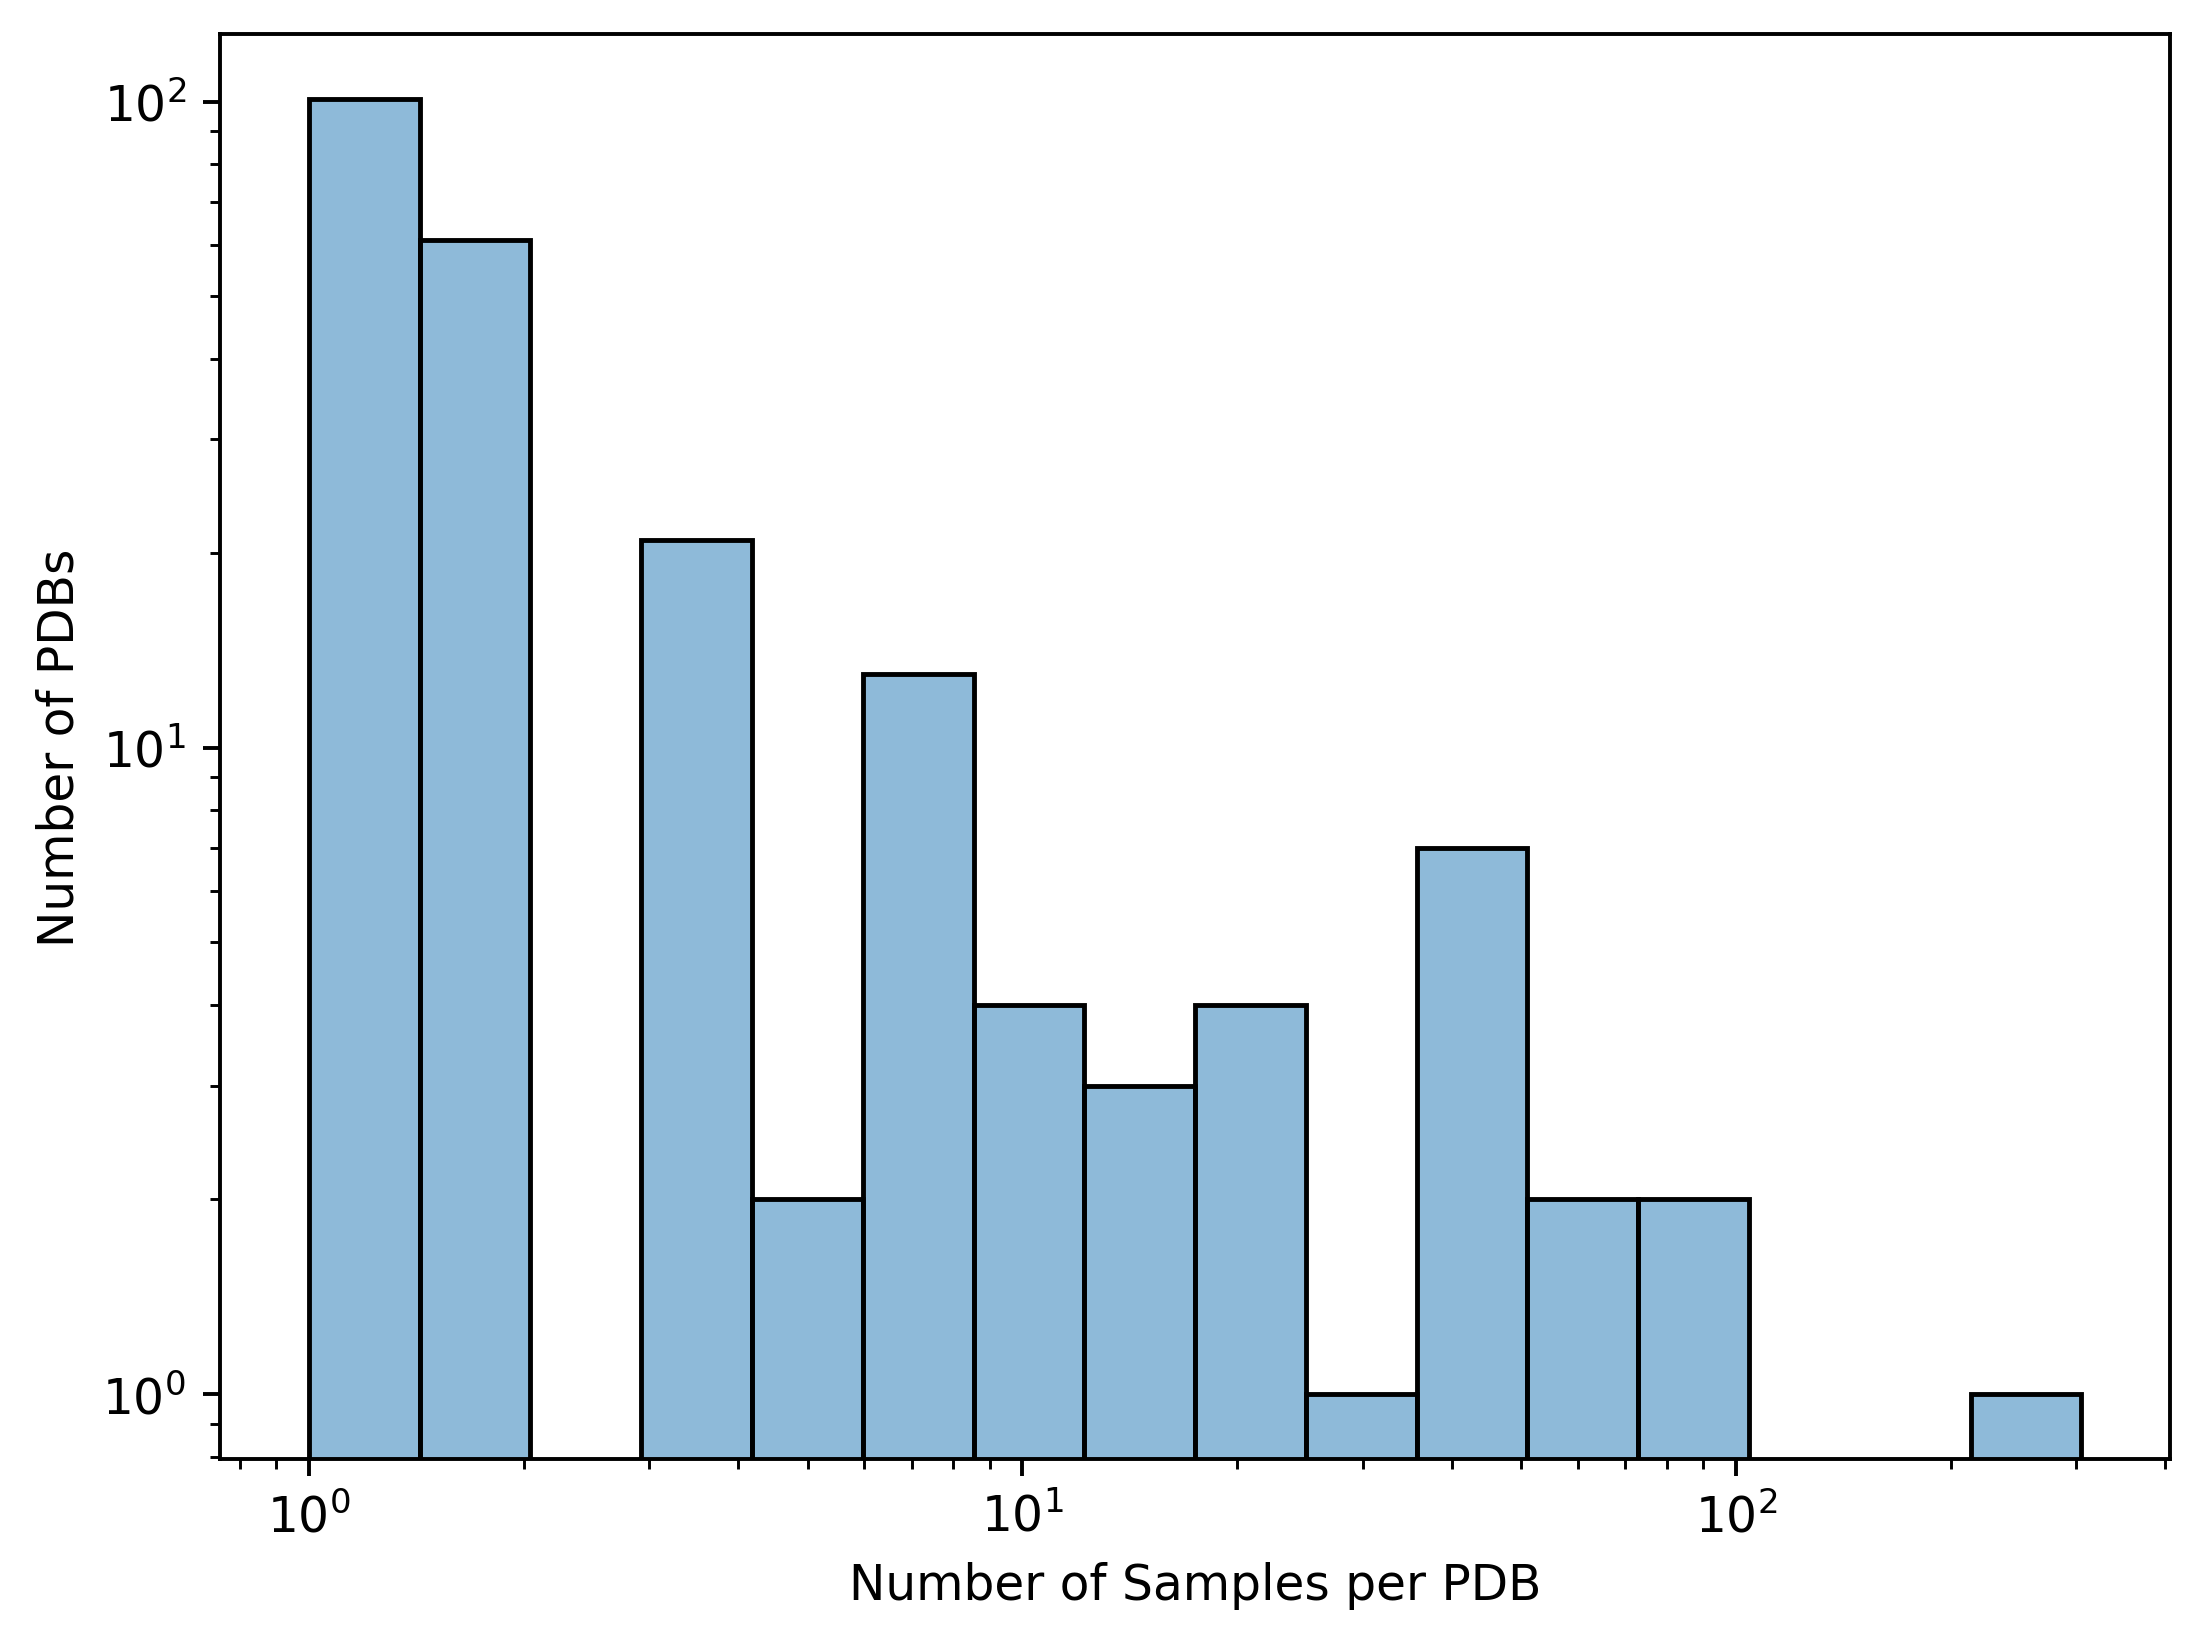

In [34]:
pdb_nb_sp = dict([(pdb,len(gp)) for pdb,gp in df_TCRpMHC.groupby('PDB')])

plt.figure(dpi=dpi)
sns.histplot(pdb_nb_sp.values(), log_scale=True, legend=False)
plt.xlabel('Number of Samples per PDB')
plt.ylabel('Number of PDBs')
plt.yscale('log')
plt.tight_layout()
plt.show()

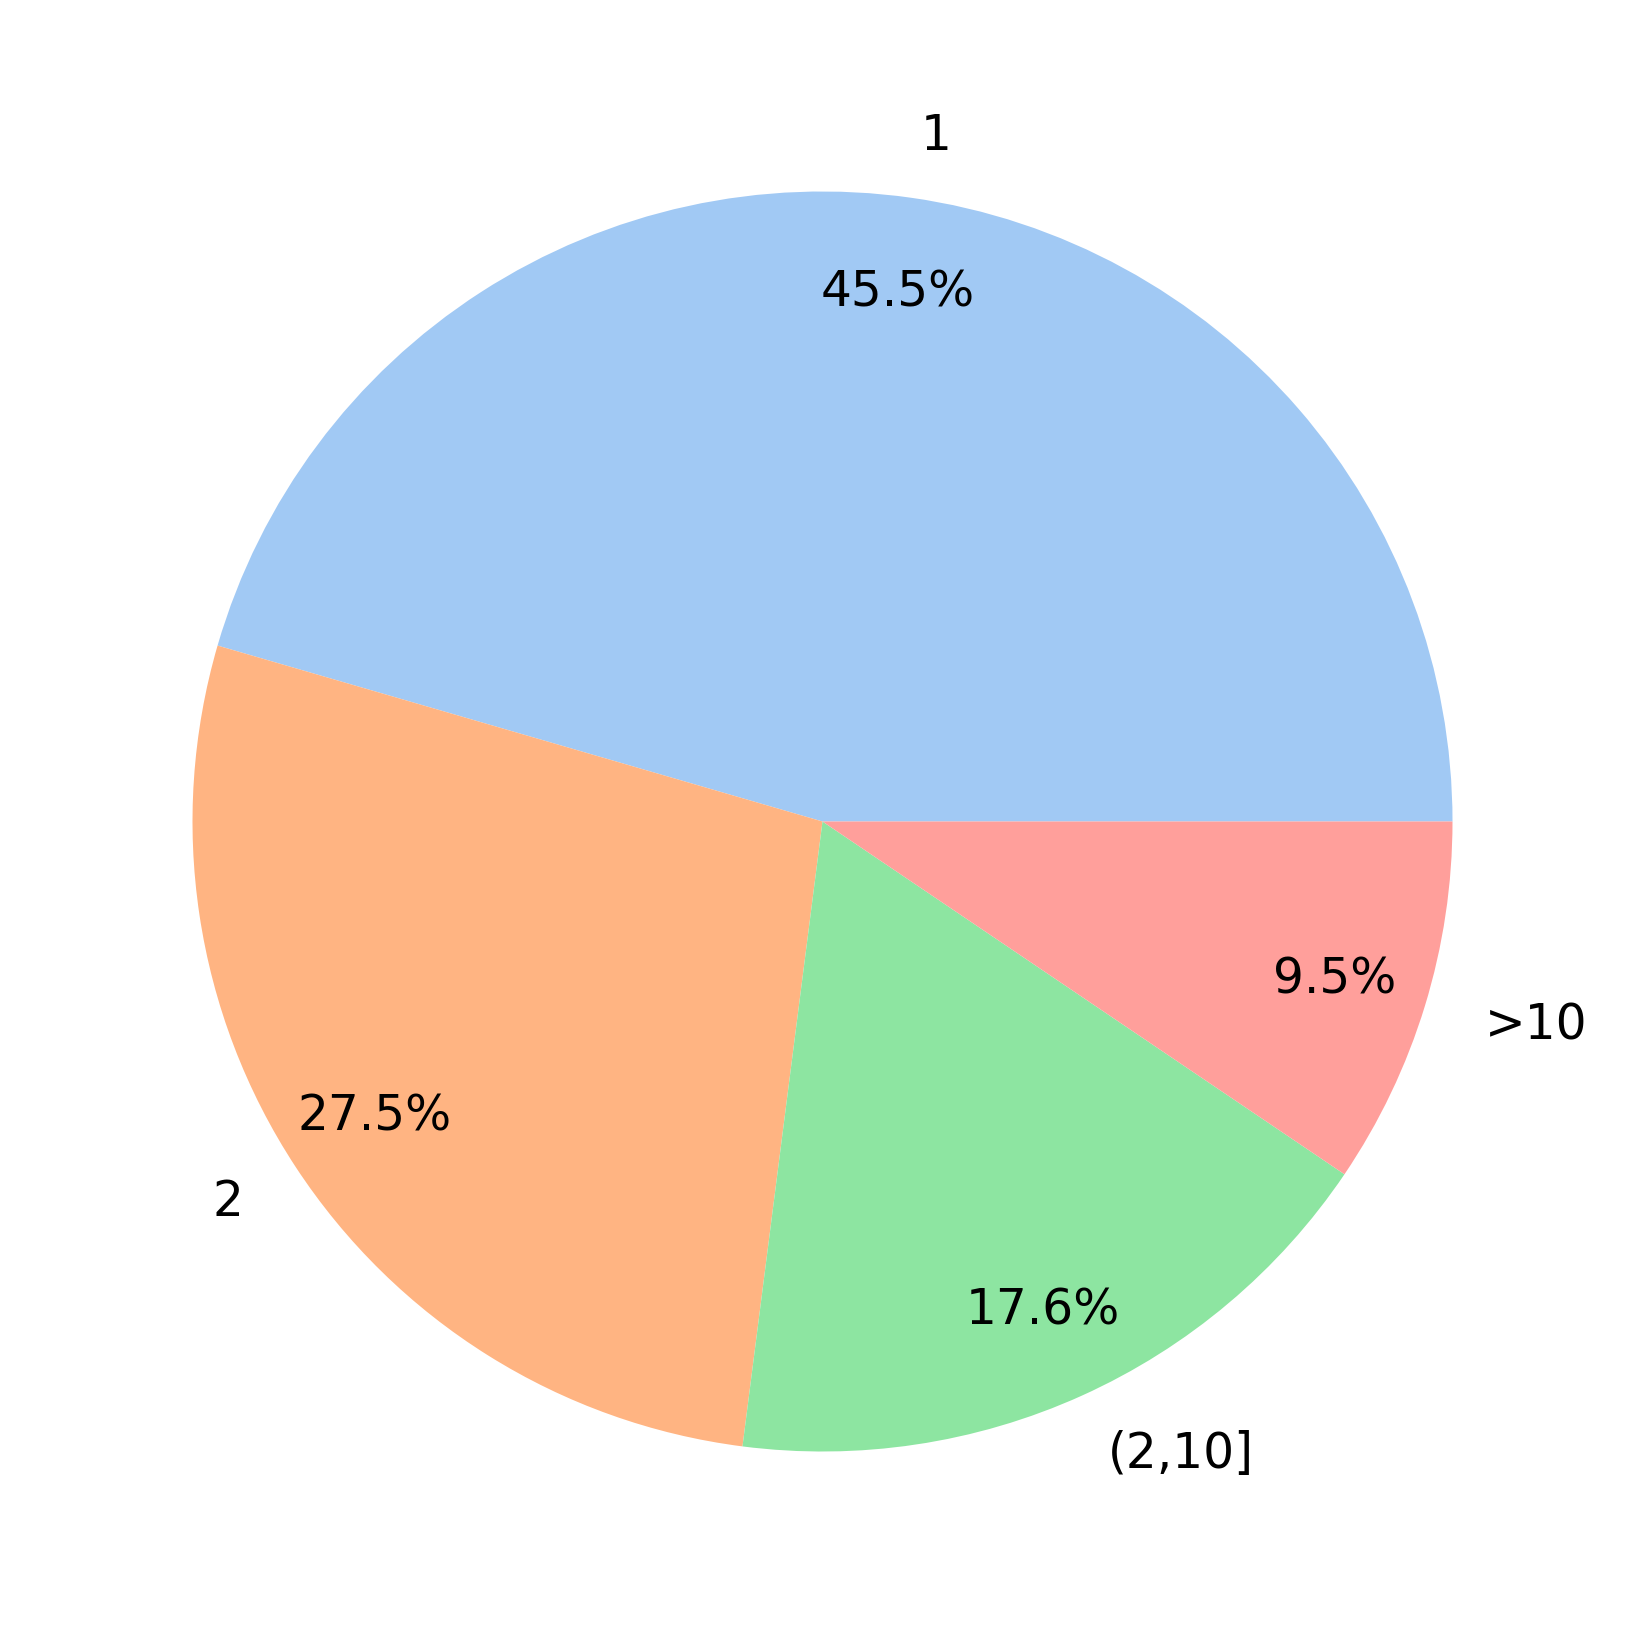

In [35]:
colors = sns.color_palette('pastel')#('viridis')#pastel

df_pdb_nb_sp = pd.DataFrame(pdb_nb_sp,index=[0]).T.rename(columns={0:'numbers'})
def bins_number(x):
    if x<=2:
        return x
    elif x>2 and x<=10:
        return '(2,10]'
    else:
        return '>10'
                
df_pdb_nb_sp['numbers'] = df_pdb_nb_sp['numbers'].apply(bins_number)
value_counts = df_pdb_nb_sp['numbers'].value_counts()
x = value_counts.values
labels = value_counts.index

plt.figure(dpi=dpi)
plt.pie(value_counts, colors=colors, labels=labels, autopct='%1.1f%%', pctdistance=0.85)
plt.tight_layout()
plt.savefig( os.path.join(save_dir,f"Number of Samples Corresponding to Each PDB (Including Wild-Type and Mutants) of the TCR-pMHC Subgroup(Total {len(set(df_TCRpMHC['PDB']))} PDBs).{suffix}"), dpi=dpi )
plt.show()

# Sample size growth curve

In [36]:
# # from utils import parse_date, parse_year

# from dateutil import parser
# # 定义一个函数来解析日期，返回年份
# def parse_year(date_str:str, return_None:bool=False):
#     try:
#         return parser.parse(date_str).year
#     except (parser.ParserError, TypeError):
#         if return_None:
#             return None
#         else:
#             return date_str

# # 定义一个函数来解析日期,返回年-月-日
# def parse_date(date_str:str, return_None:bool=False):
#     try:
#         return parser.parse(date_str)
#     except (parser.ParserError, TypeError):
#         if return_None:
#             return None
#         else:
#             return date_str

# # # 解析日期并提取年份
# df_merge['Affinity Release Year'] =  df_merge['Affinity Release Date'].astype(str).apply(lambda x:parse_year(x,return_None=True))
# # df_merge['Affinity Release Year'] 

# # 计算每年的样本量
# yearly_counts = df_merge['Affinity Release Year'].value_counts().sort_index()

# # 绘制年度增长柱状图
# plt.figure(figsize=(10, 6),dpi=dpi)
# yearly_counts.plot(kind='bar', color='skyblue')
# plt.xlabel('Year')
# plt.ylabel('Number of Samples')
# plt.title('Annual Growth of Sample Volume')
# plt.xticks(rotation=45)
# plt.show()

# df_merge.drop(columns=['Affinity Release Year'],inplace=True)

# save

In [38]:
df_merge['Subgroup'] = np.nan
df_merge.loc[df_AbAg.index,'Subgroup']='Antibody-Antigen'
df_merge.loc[df_TCRpMHC.index,'Subgroup']='TCR-pMHC'
df_merge = df_merge.drop(columns=['Complex ID PDB', 'Complex ID cleaned'])

cols = ['Source Data Set', 'Complex ID', 'PDB', 'Mutations', 
        'Ligand Chains','Receptor Chains','Ligand Name','Receptor Name', 'KD(M)',
        'Affinity Method','Structure Method','Temperature(K)','Resolution(Å)',
        'PDB PubMed ID', 'PDB Release Date','Affinity PubMed ID','Affinity Release Date',
        'Subgroup']

df_merge = df_merge.loc[:,cols]
save_dir = './processed_data'
# Protein-Protein Binding Affinity(PPB-Affinity)
df_merge.to_excel( os.path.join(save_dir,'PPB-Affinity.xlsx') )

In [39]:
for name,data in df_dict.items():
    print(f"{name}: {len(data)}")
print(f"PPB-Affinity: {len(df_merge)}")

SKEMPI v2.0: 7146
SAbDab: 1069
Affinity Benchmark v5.5: 207
PDBbind v2020: 3985
ATLAS: 637
PPB-Affinity: 12062
